In [ ]:
import urllib.request

url = "https://raw.githubusercontent.com/avnyadav/sensor-fault-detection/main/aps_failure_training_set1.csv"
urllib.request.urlretrieve(url, "aps_failure_training_set1.csv")


In [ ]:
import sys; print(sys.prefix)

In [ ]:
pip install seaborn numpy pandas matplotlib scikit-learn xgboost catboost

In [4]:

import seaborn as sns
import numpy as np
import pandas as pd
from statistics import mean
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,recall_score,confusion_matrix

from sklearn import metrics
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_val_score
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler ,MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier


warnings.filterwarnings("ignore")
%matplotlib inline

In [5]:
df = pd.read_csv(r"https://raw.githubusercontent.com/avnyadav/sensor-fault-detection/main/aps_failure_training_set1.csv",na_values="na")

In [6]:
#checking values of target class
df["class"].value_counts()

class
neg    35188
pos     1000
Name: count, dtype: int64

In [7]:
#seperate numrical and categorical columns
numerical_features = [feature for feature in df.columns if df[feature].dtype!="O"]
categorical_features = [feature for feature in df.columns if df[feature].dtype=="O"]

print(f"we have {len(numerical_features)} numerical features :{numerical_features}")
print(f"we have {len(categorical_features)} categorical features :{categorical_features}")


we have 170 numerical features :['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000',

As  it it sensor Data. Interpretation of data is not require 

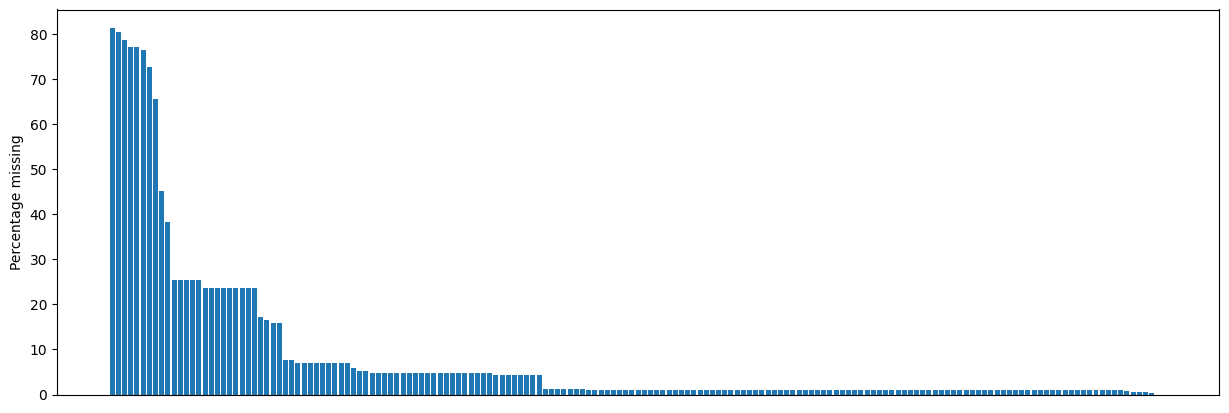

In [8]:
#plotting Missing values count for each column

fig, ax = plt.subplots(figsize = (15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0,ascending = False)

ax.bar(missing.index , missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

Dropping Columns which has more than 70% of missing values

In [9]:
dropcolumns = missing[missing[0]>70]
dropcolumns

,0
br_000,81.410965
bq_000,80.501824
bp_000,78.794075
ab_000,77.086327
cr_000,77.086327
bo_000,76.533658
bn_000,72.761689


In [10]:
 df.drop(list(dropcolumns.index),axis=1,inplace = True)
 

In [11]:
df.shape

(36188, 164)

Total missing values in total data

In [12]:
missing_values_count = df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()


print(f"Percentage of total missing cells in data {(total_missing/total_cells)*100}")

Percentage of total missing cells in data 5.37059852747306


Positive: 1000,Negative:35188


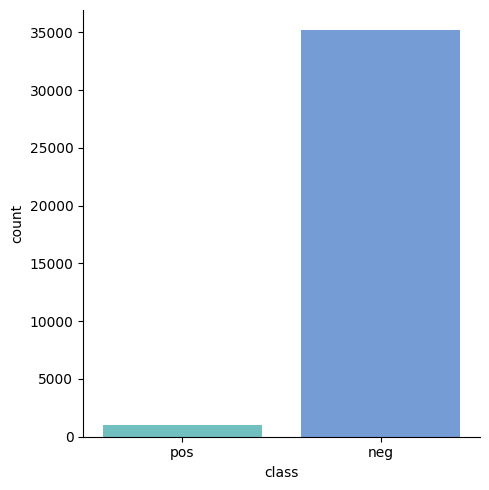

In [13]:
pos = df[df["class"]=="pos"].shape[0]
neg = df[df["class"]=="neg"].shape[0]

print("Positive: "+str(pos)+",Negative:"+str(neg))
sns.catplot(data=df,x="class",kind= "count",palette = "winter_r",alpha=0.6)
plt.show()

In [14]:
#will add the report here on this

In [15]:
from sklearn.metrics import roc_auc_score
def evaluate_clf(true,predicted):
  """
  This function takes in true values and predicted values
  Returns: Accuracy,F1-Score, Precision,Recall,Roc-auc Score"""

  acc = accuracy_score(true,predicted)  #calculate Accuracy
  f1 = f1_score(true,predicted)
  precision = precision_score(true,predicted)
  recall = recall_score(true,predicted)
  roc_auc = roc_auc_score(true,predicted)
  return acc,f1,precision,recall,roc_auc

In [16]:
#create cost of model as per data description
def total_cost(Y_true,Y_pred):
  """
  This funciton takes Y_true,Y_predicted and prints Total cost due to miscalcullation
  """
  tn,fp,fn,tp = confusion_matrix(Y_true,Y_pred).ravel()
  cost = 10*fp+500*fn
  return cost

In [17]:
def evaluate_models(X, Y, models):
    """
    This function takes in X, Y, and a dictionary of models as input.
    It will split the data into train and test sets,
    iterate through the model dictionary, and evaluate the metrics.
    Returns: DataFrame which contains the report of all models' metrics with cost.
    """
    # Split data into train and test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12)

    cost_list = []
    models_list = []

    for i in range(len(models)):
        model_name = list(models.keys())[i]
        model = models[model_name]
        model.fit(X_train, Y_train)  # Model training

        # Make predictions
        Y_train_pred = model.predict(X_train)
        Y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1, model_train_precision, model_train_recall, model_train_rocauc_score = evaluate_clf(Y_train, Y_train_pred)
        train_cost = total_cost(Y_train, Y_train_pred)

        # Test set performance
        model_test_accuracy, model_test_f1, model_test_precision, model_test_recall, model_test_rocauc_score = evaluate_clf(Y_test, Y_test_pred)
        test_cost = total_cost(Y_test, Y_test_pred)

        print(model_name)
        models_list.append(model_name)

        print("Model performance for Training set")
        print(f"--Accuracy: {model_train_accuracy:.4f}")
        print(f"--F1 score: {model_train_f1:.4f}")
        print(f"--Precision: {model_train_precision:.4f}")
        print(f"--Recall: {model_train_recall:.4f}")
        print(f"--ROC AUC score: {model_train_rocauc_score:.4f}")
        print(f"---Cost: {train_cost}")

        print("---------------------------------------------------")

        print("Model performance for Testing set")
        print(f"--Accuracy: {model_test_accuracy:.4f}")
        print(f"--F1 score: {model_test_f1:.4f}")
        print(f"--Precision: {model_test_precision:.4f}")
        print(f"--Recall: {model_test_recall:.4f}")
        print(f"--ROC AUC score: {model_test_rocauc_score:.4f}")
        print(f"---Cost: {test_cost}")

        cost_list.append(test_cost)
        print("="*40)
        print("\n")

    report = pd.DataFrame(list(zip(models_list, cost_list)), columns=["Model Name", "Cost"]).sort_values(by="Cost")

    return report


Plotting Batches:   0%|                                                                                                                                                                                 | 0/17 [00:00<?, ?batch/s]

Processing and plotting batch 1/17


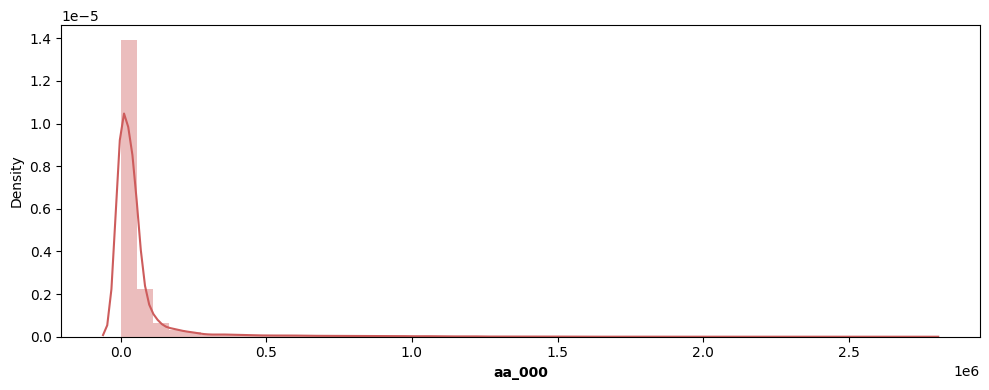

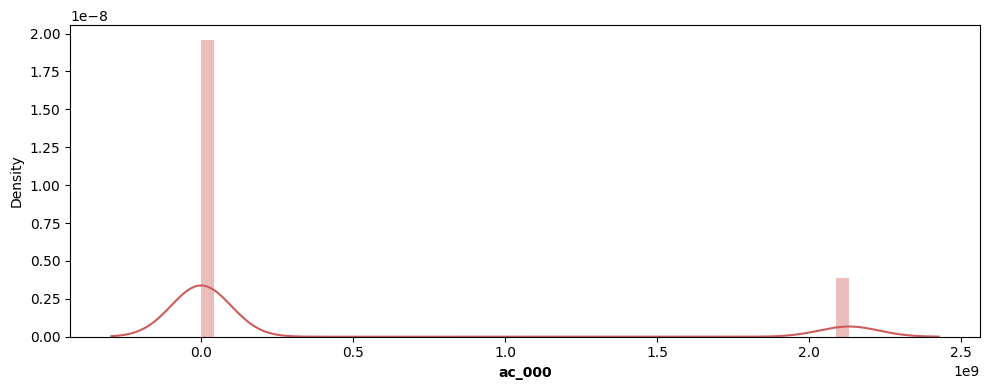

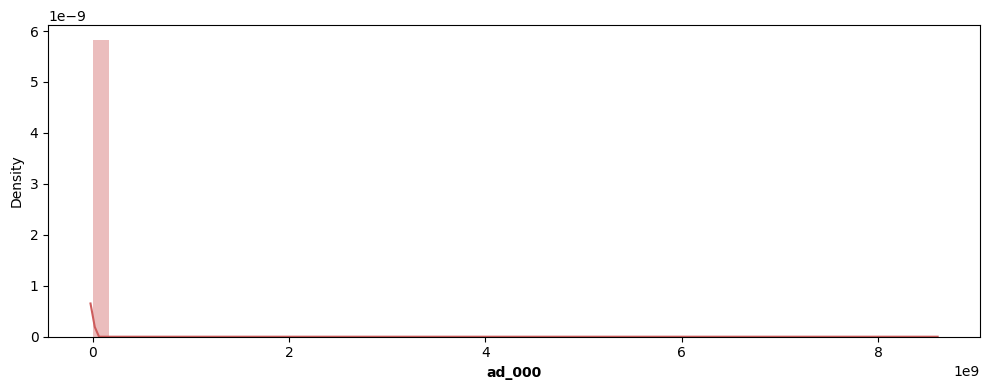

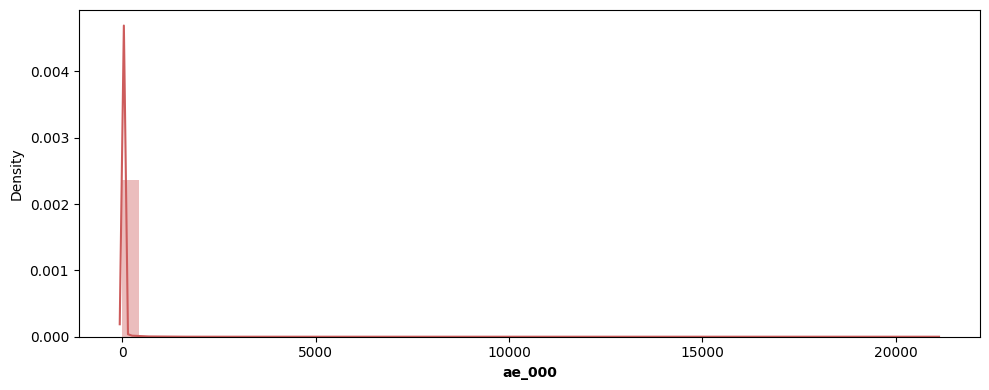

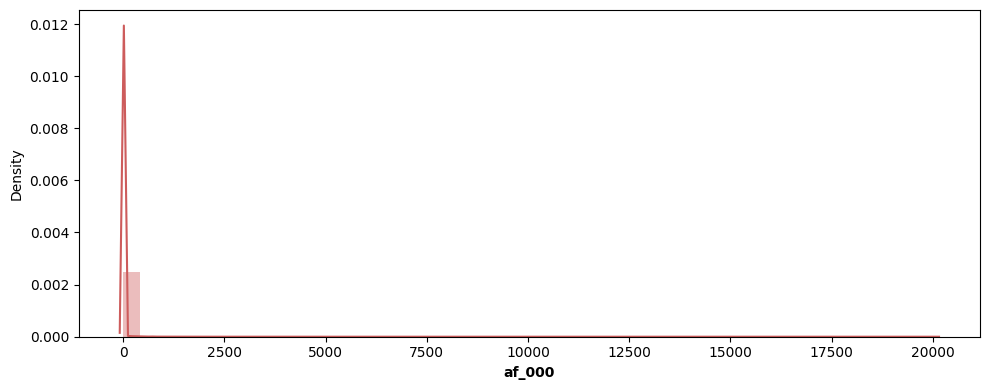

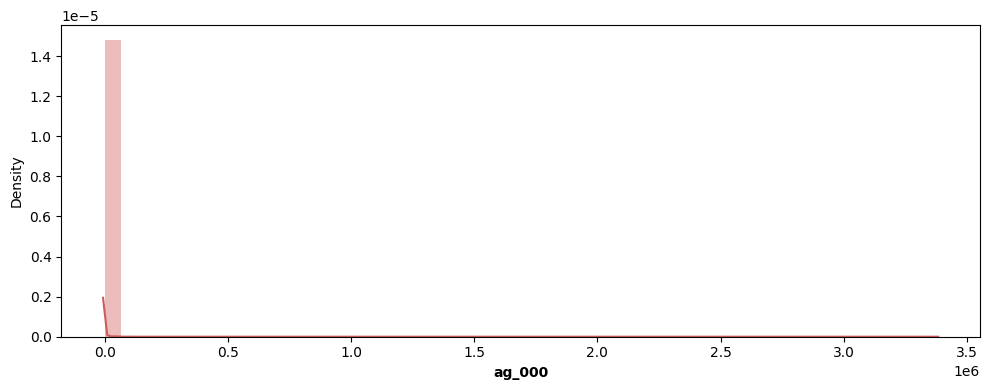

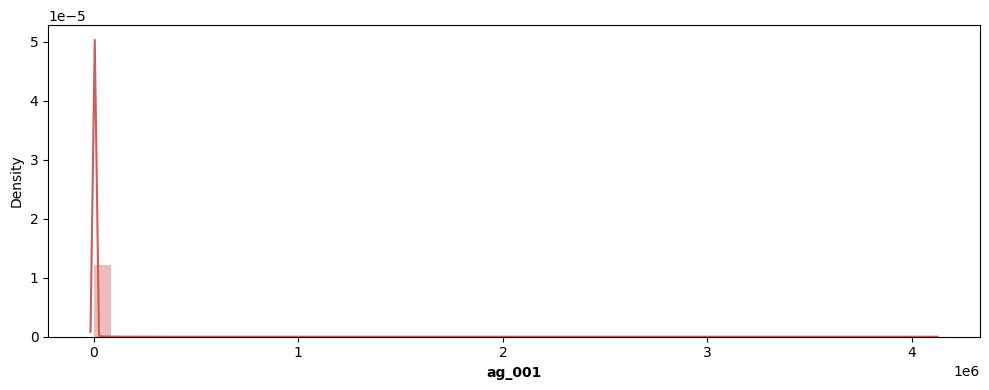

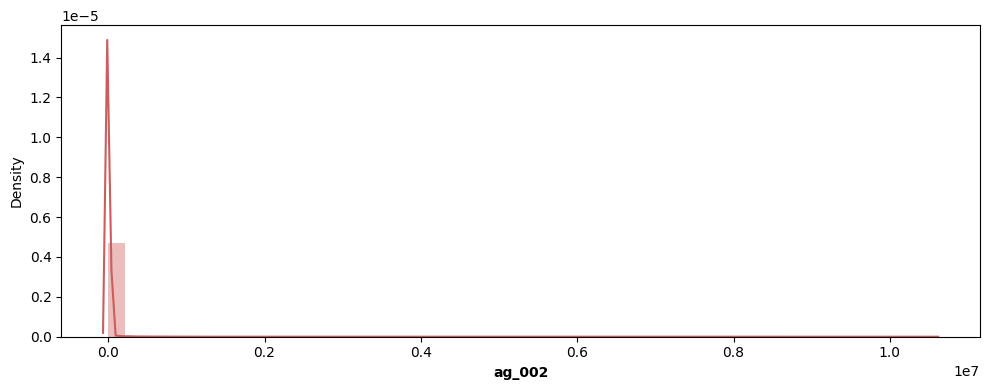

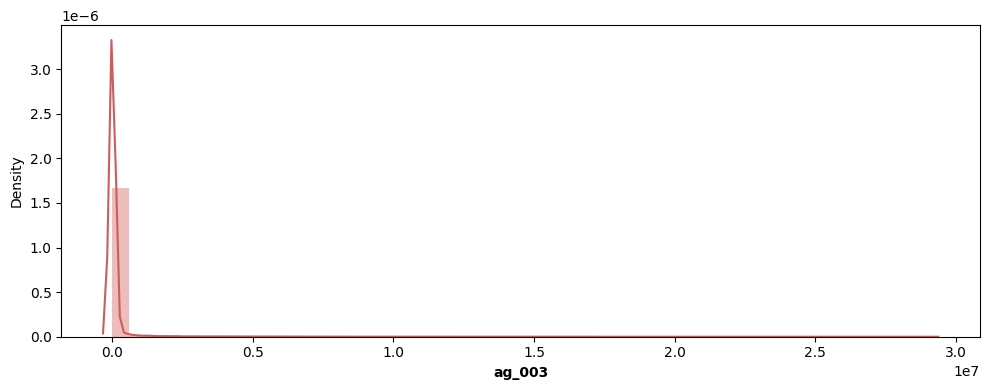

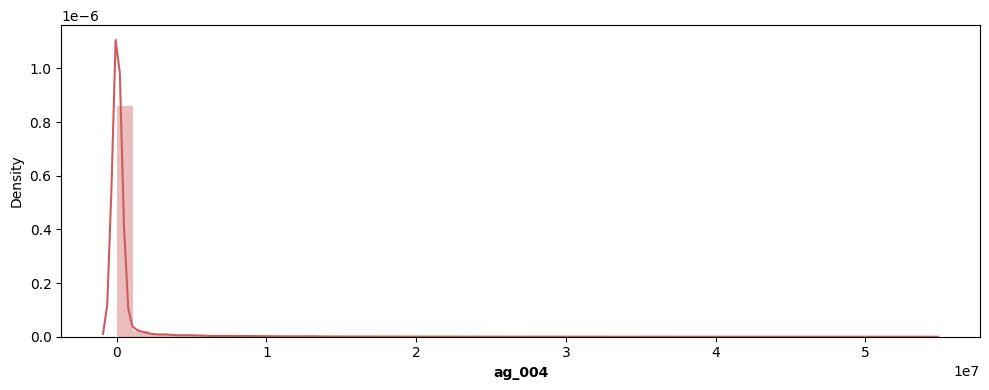

Plotting Batches:   6%|█████████▉                                                                                                                                                               | 1/17 [00:06<01:39,  6.20s/batch]

Processing and plotting batch 2/17


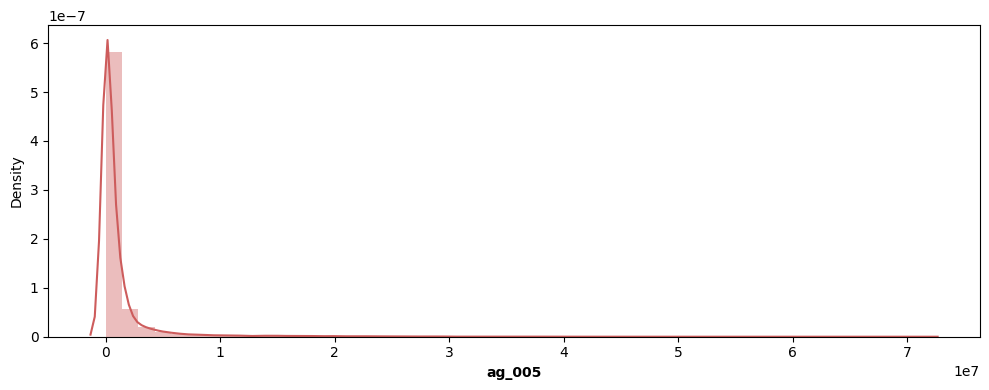

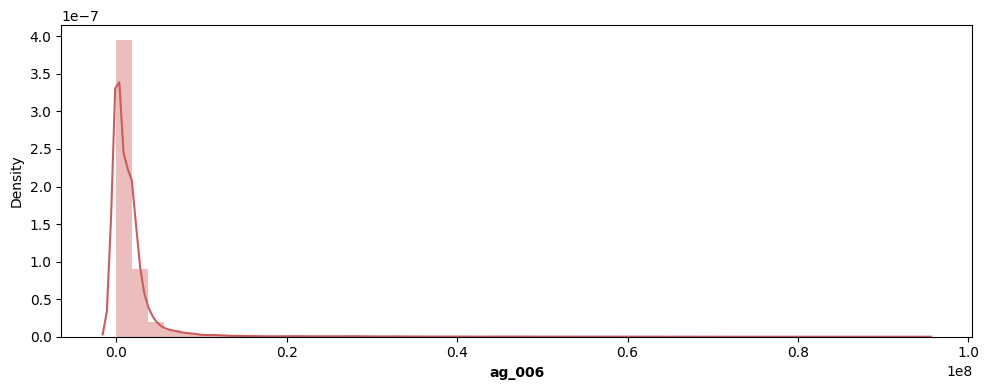

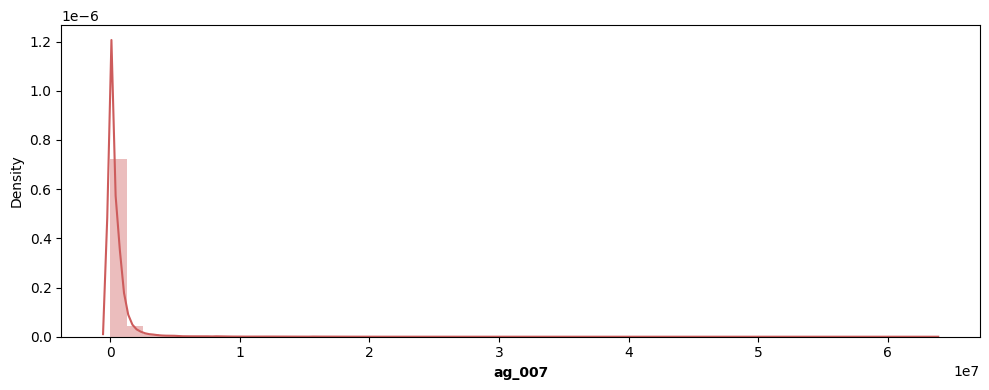

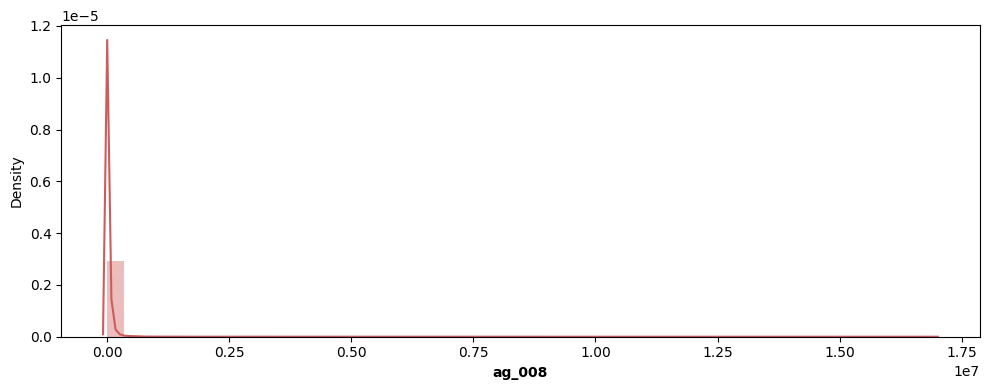

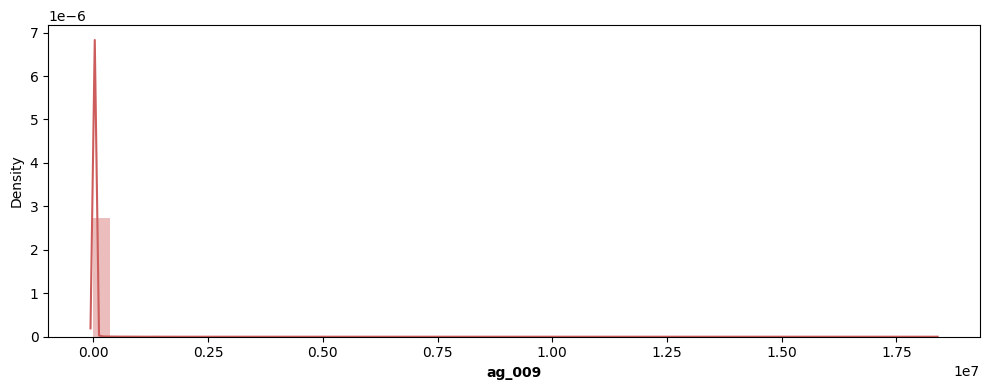

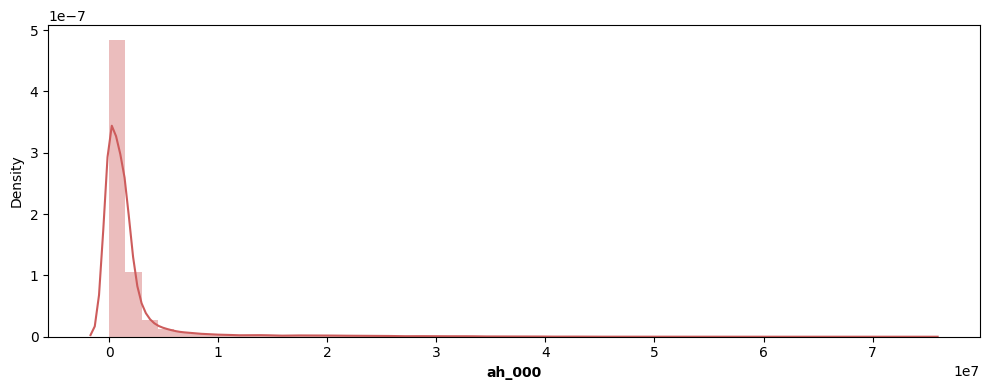

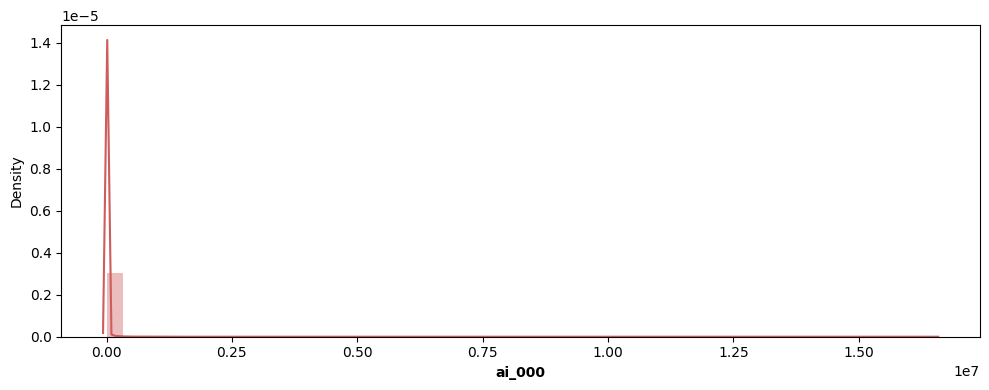

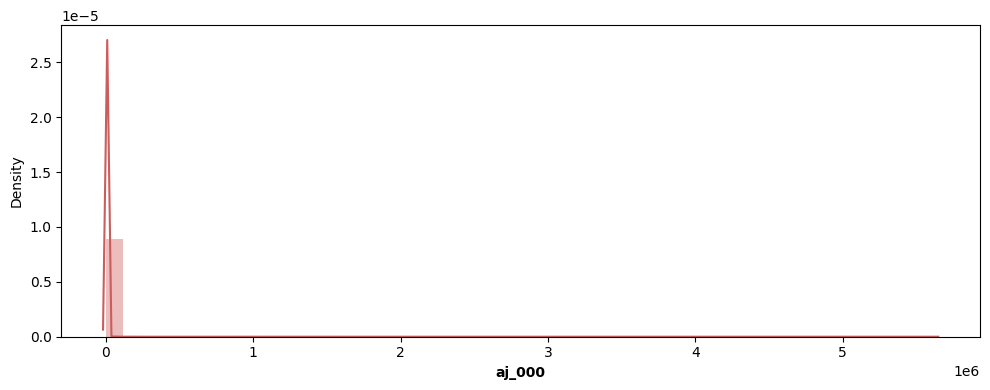

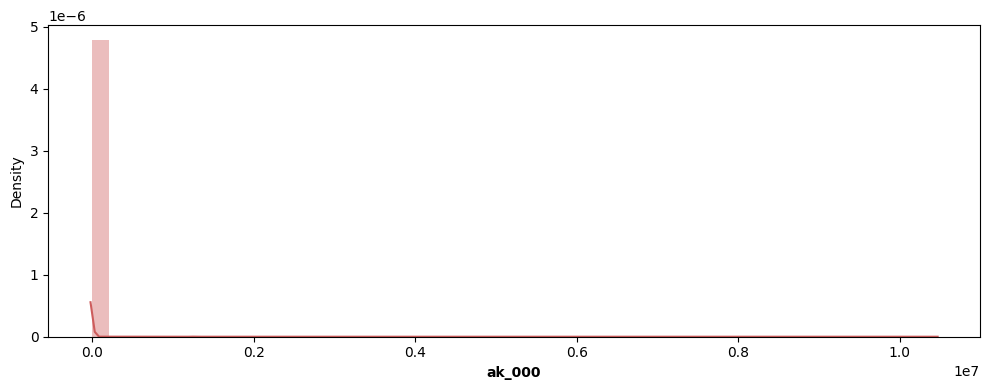

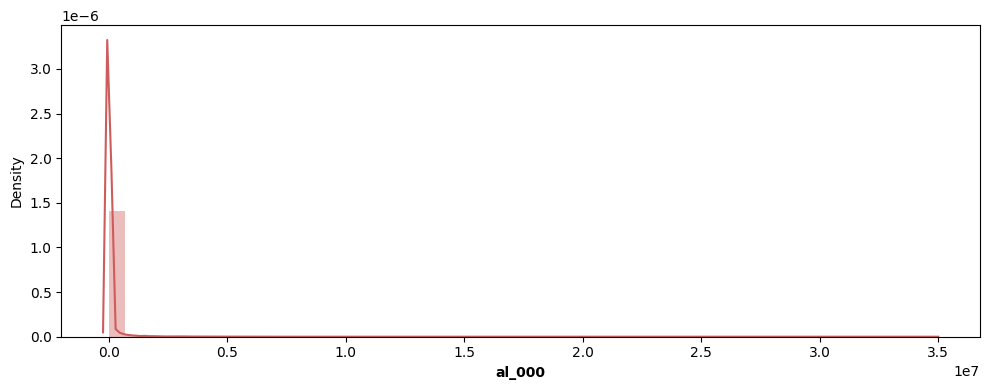

Plotting Batches:  12%|███████████████████▉                                                                                                                                                     | 2/17 [00:12<01:31,  6.09s/batch]

Processing and plotting batch 3/17


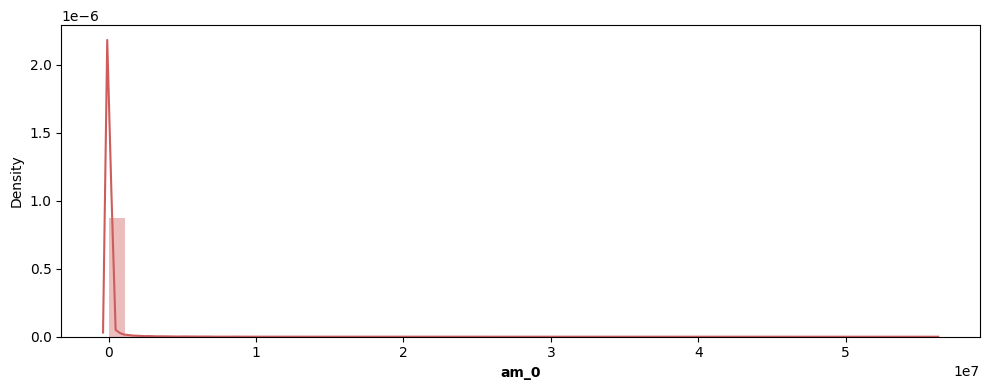

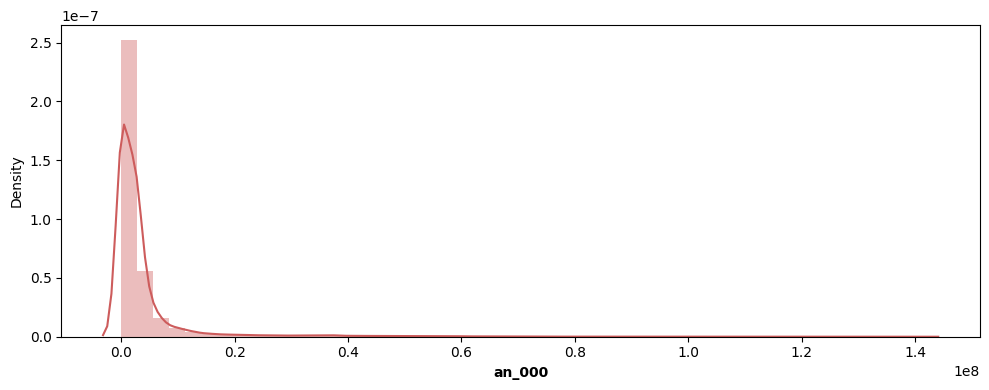

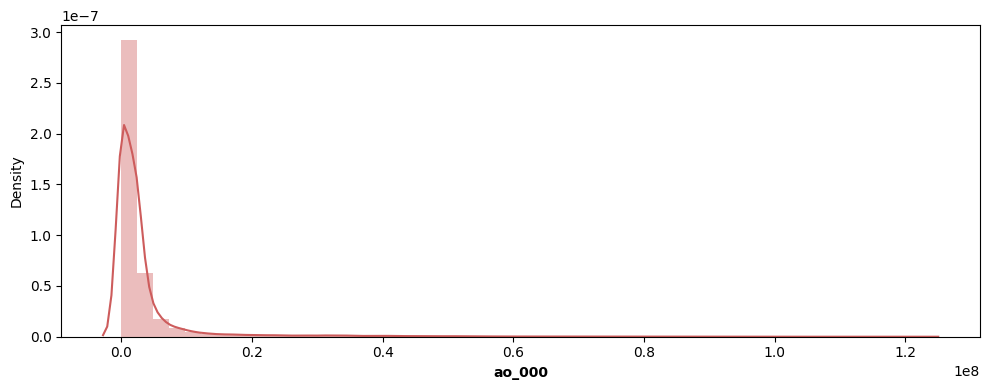

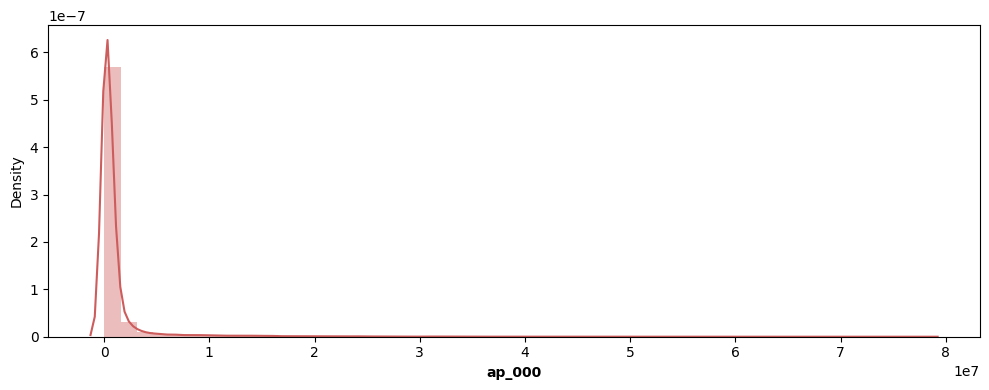

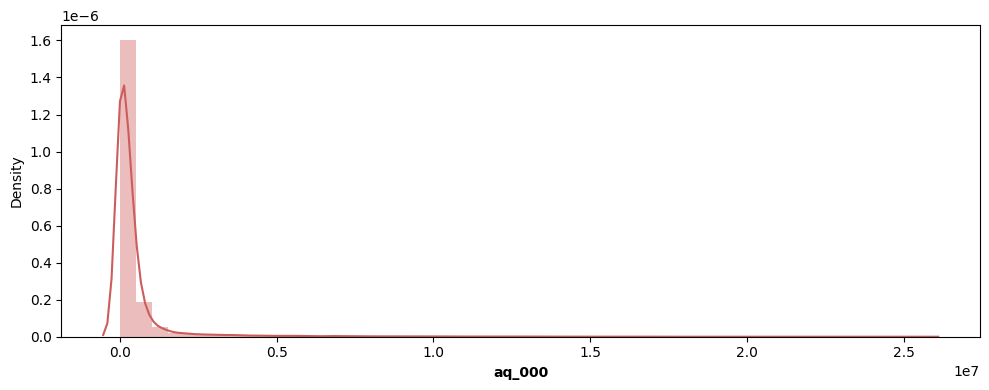

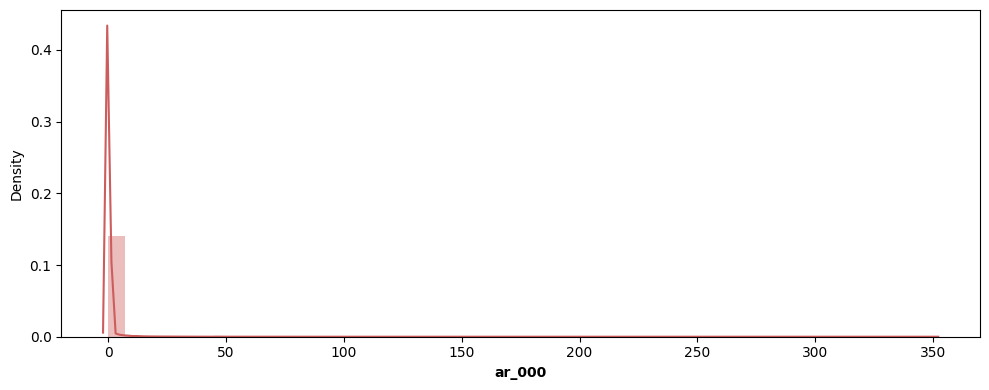

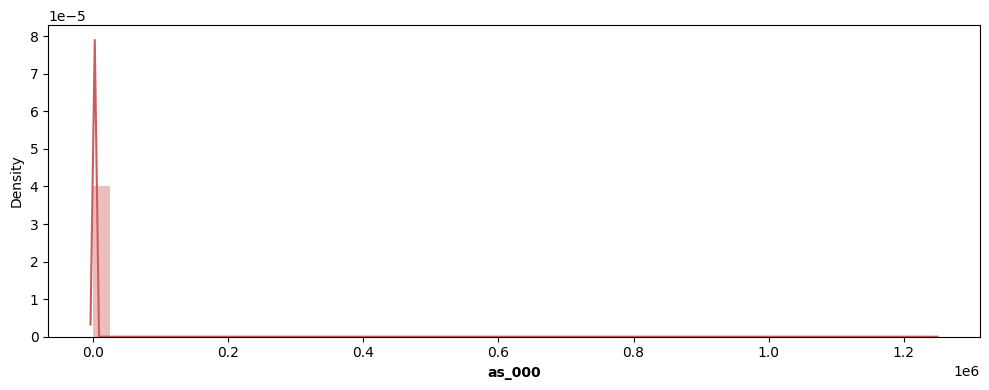

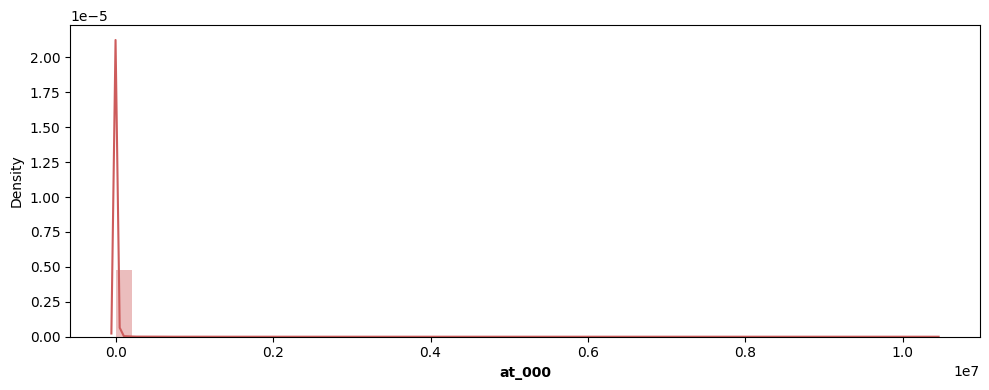

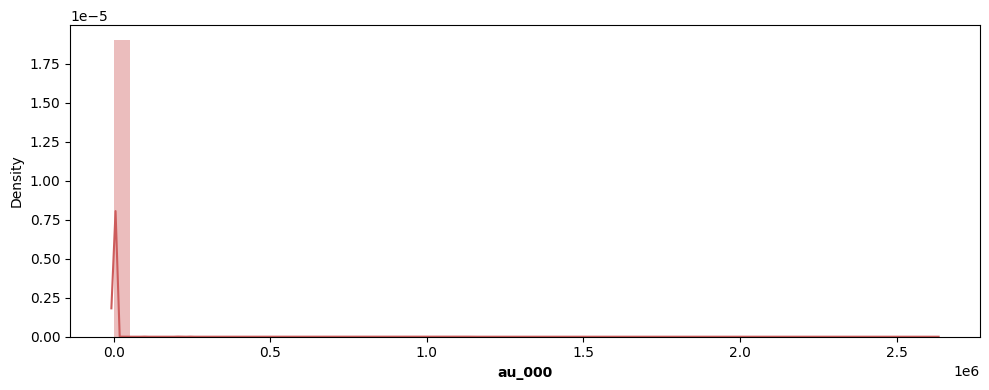

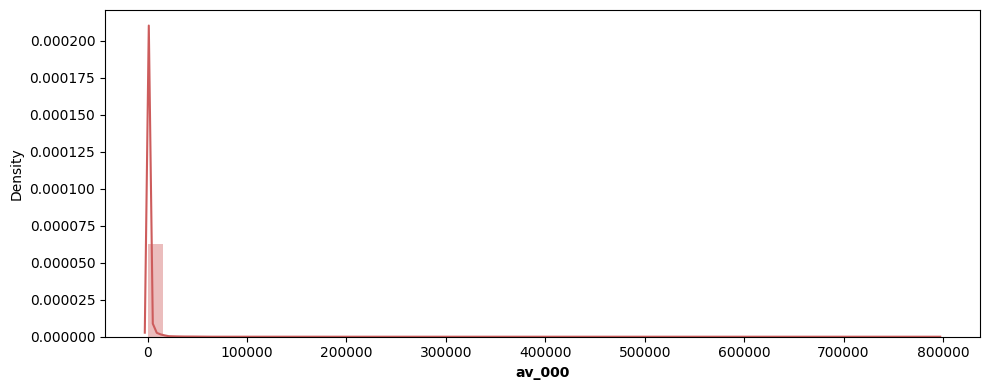

Plotting Batches:  18%|█████████████████████████████▊                                                                                                                                           | 3/17 [00:18<01:26,  6.16s/batch]

Processing and plotting batch 4/17


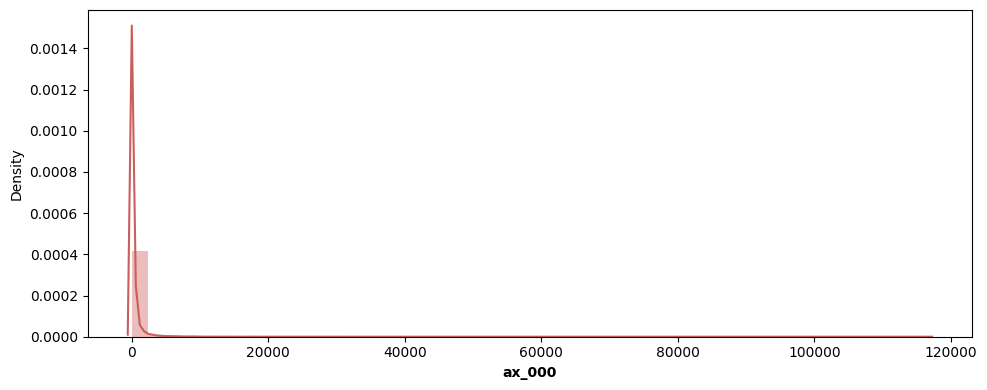

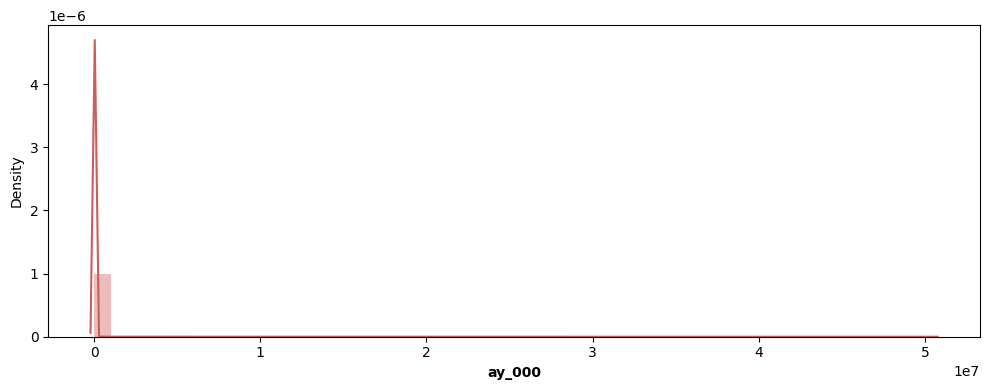

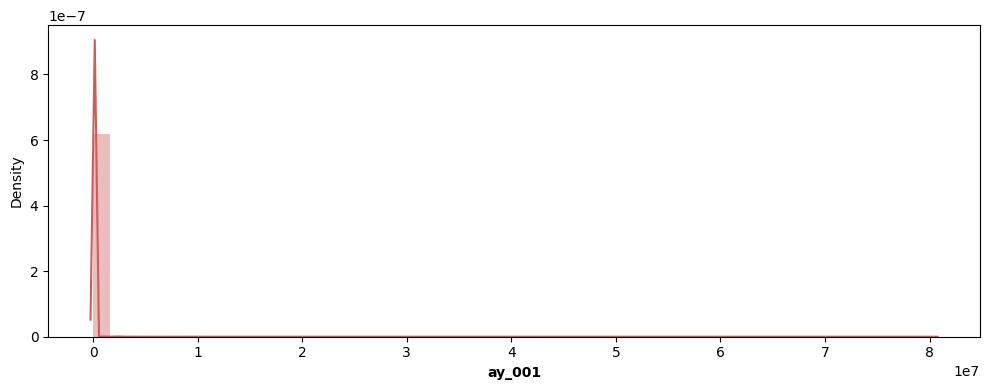

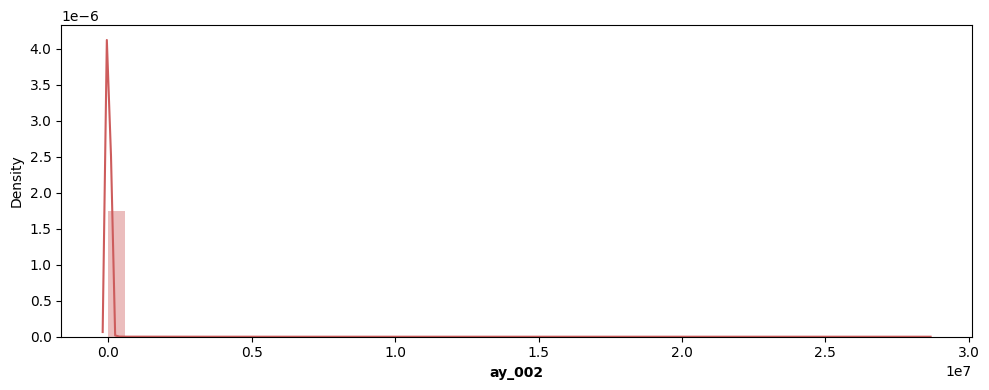

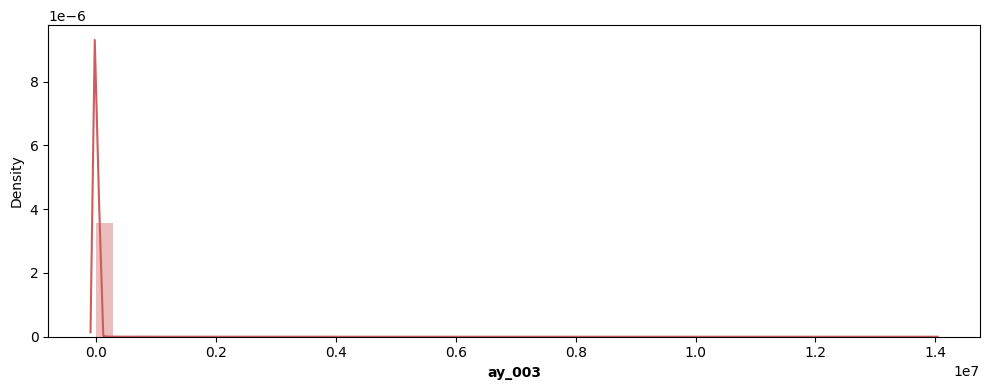

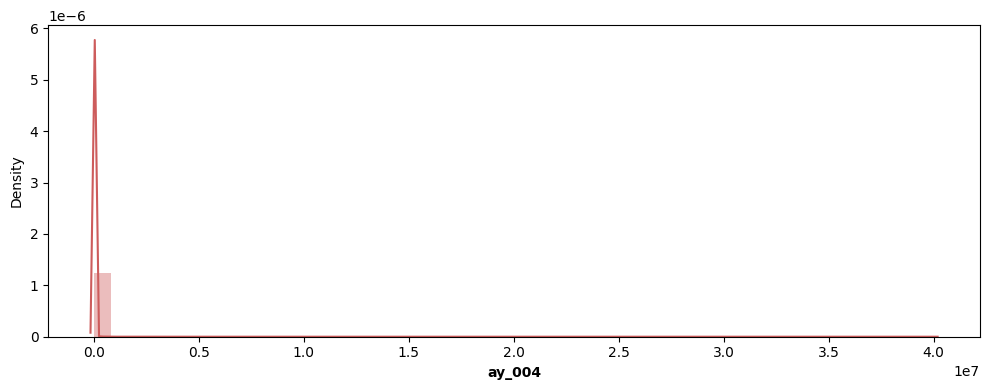

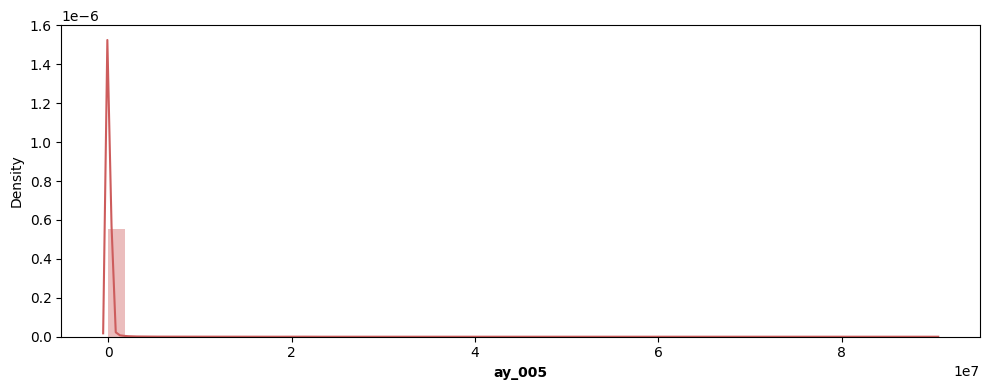

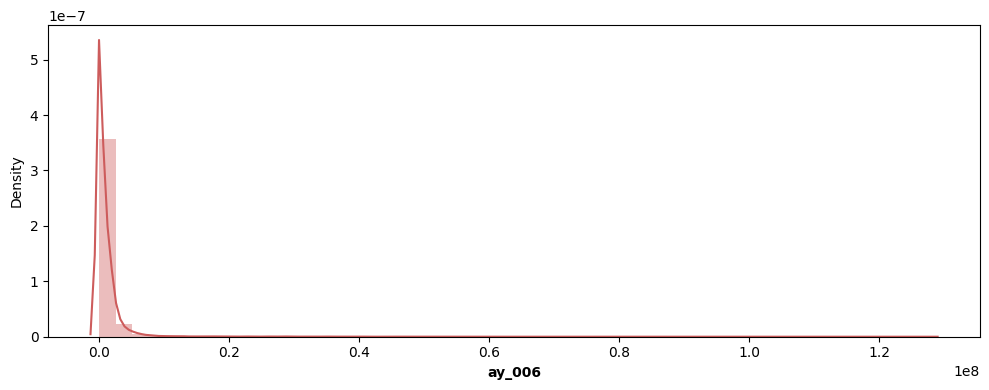

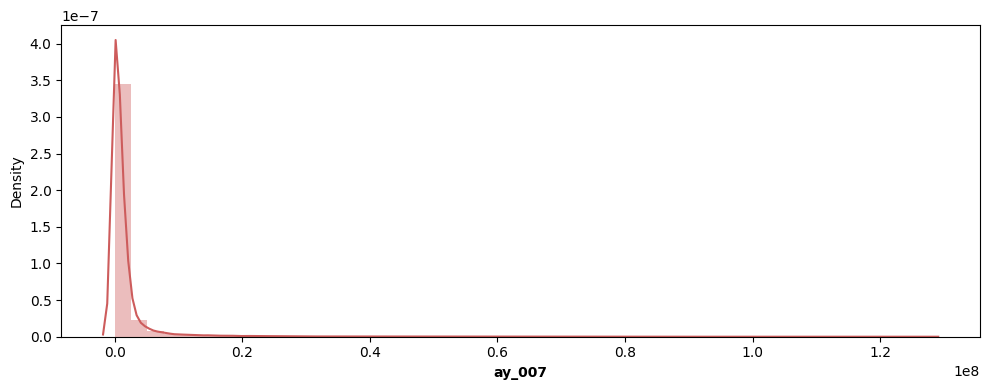

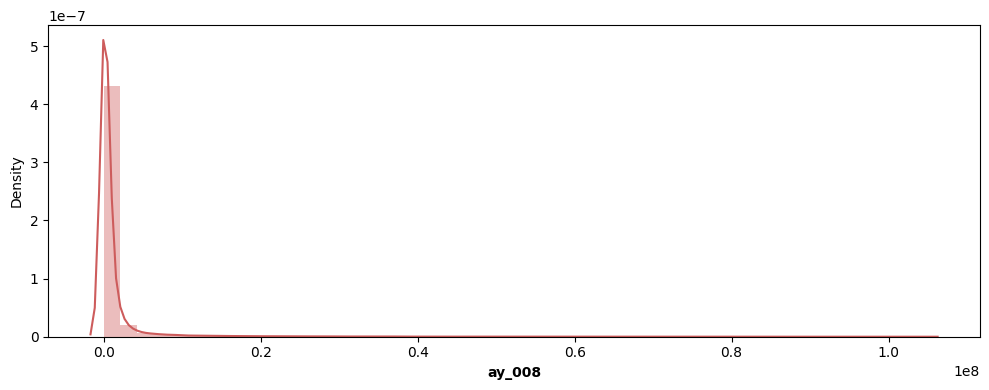

Plotting Batches:  24%|███████████████████████████████████████▊                                                                                                                                 | 4/17 [00:24<01:17,  5.98s/batch]

Processing and plotting batch 5/17


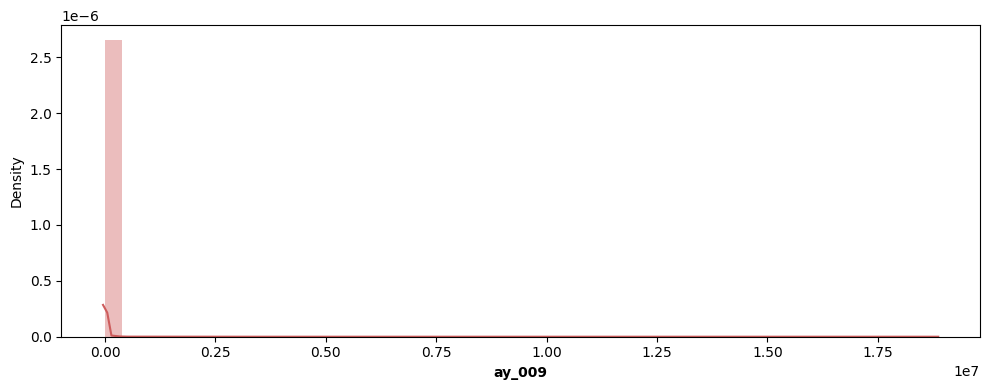

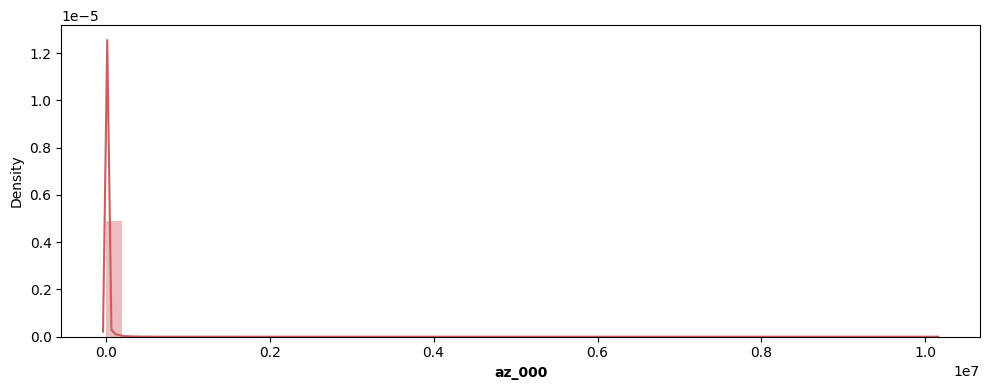

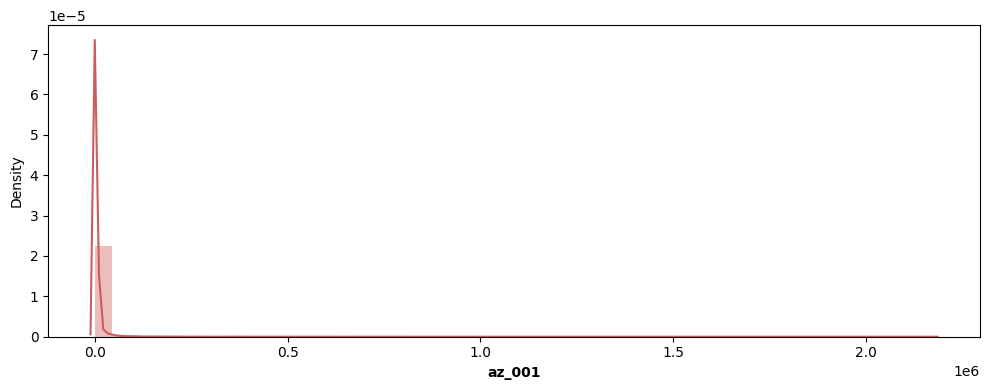

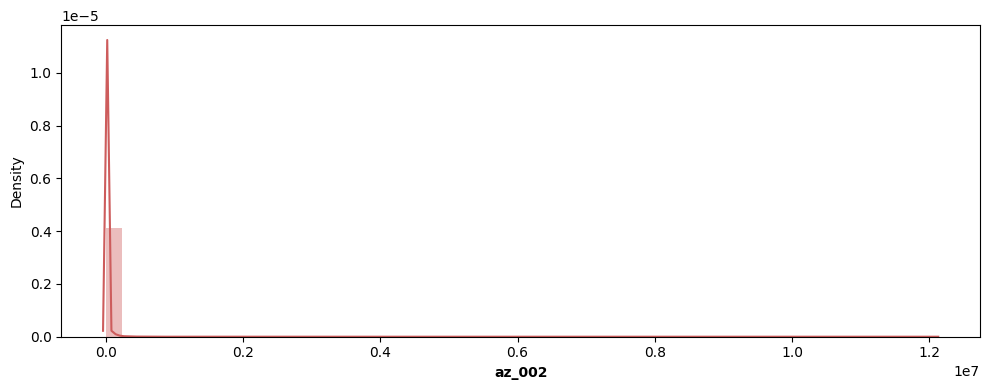

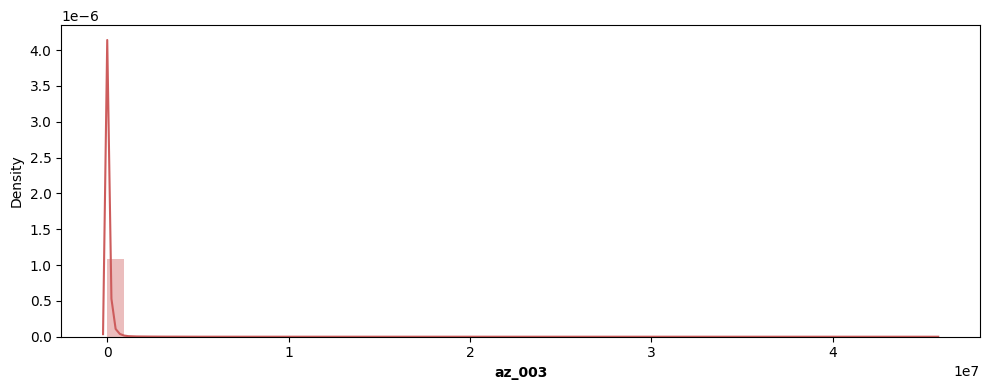

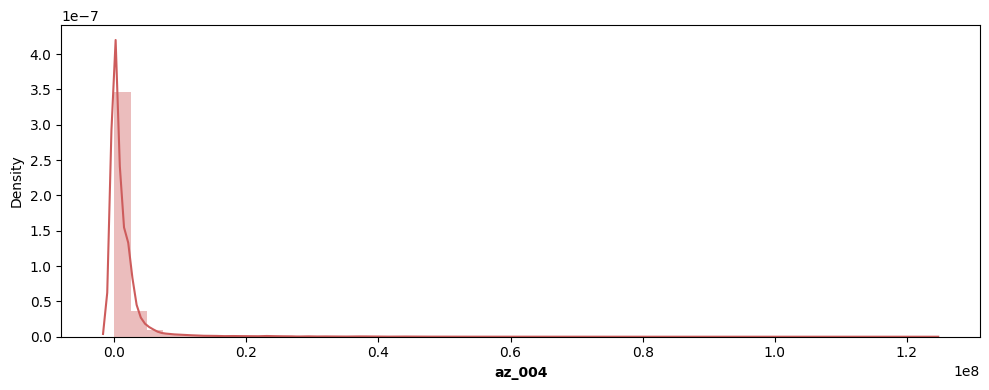

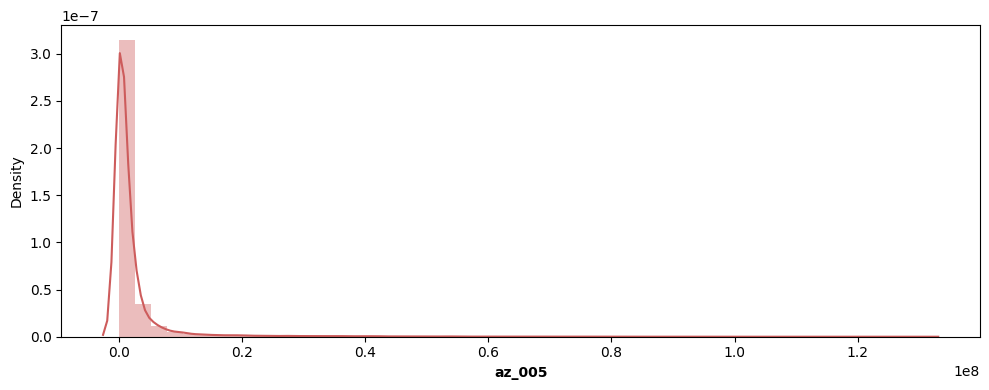

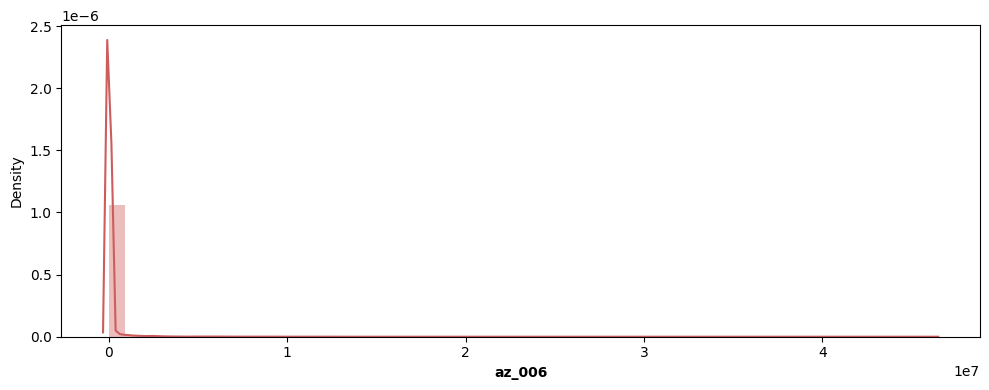

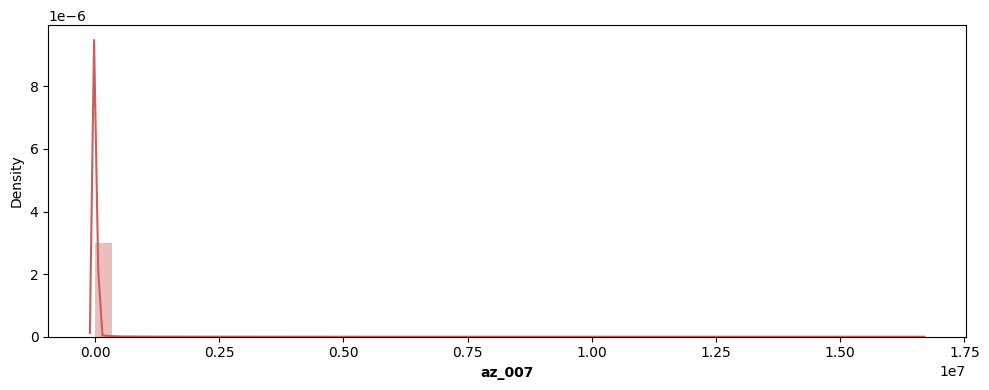

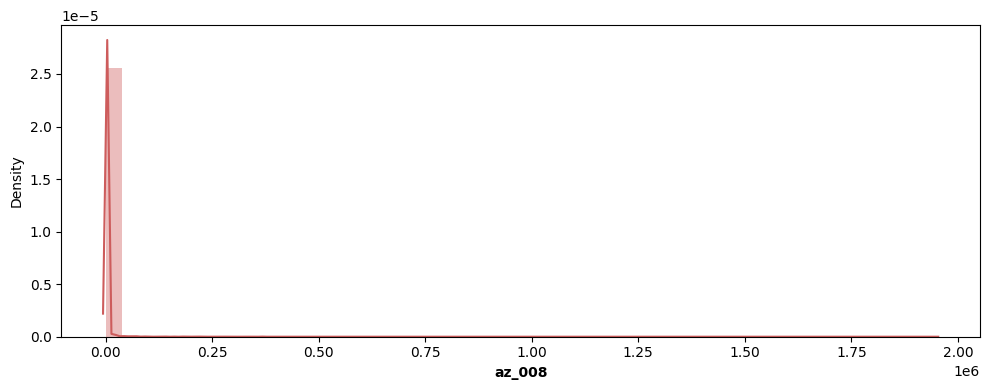

Plotting Batches:  29%|█████████████████████████████████████████████████▋                                                                                                                       | 5/17 [00:29<01:10,  5.87s/batch]

Processing and plotting batch 6/17


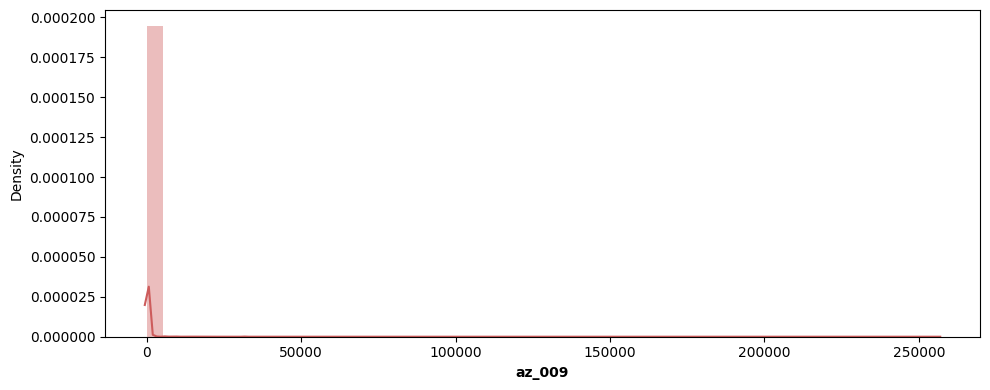

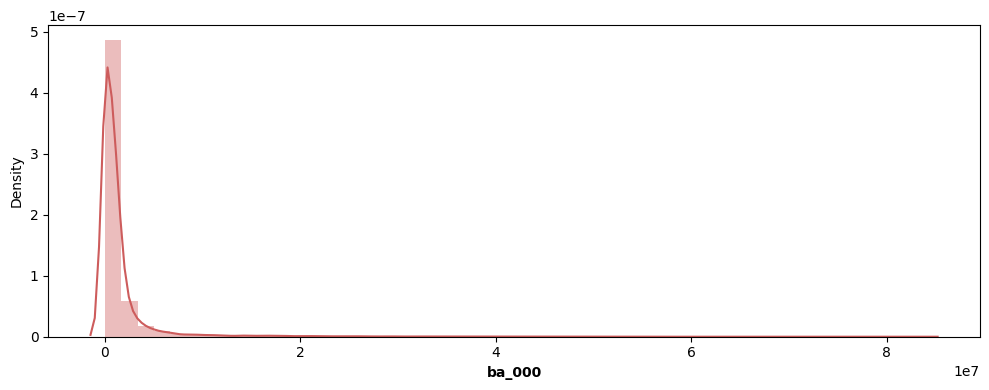

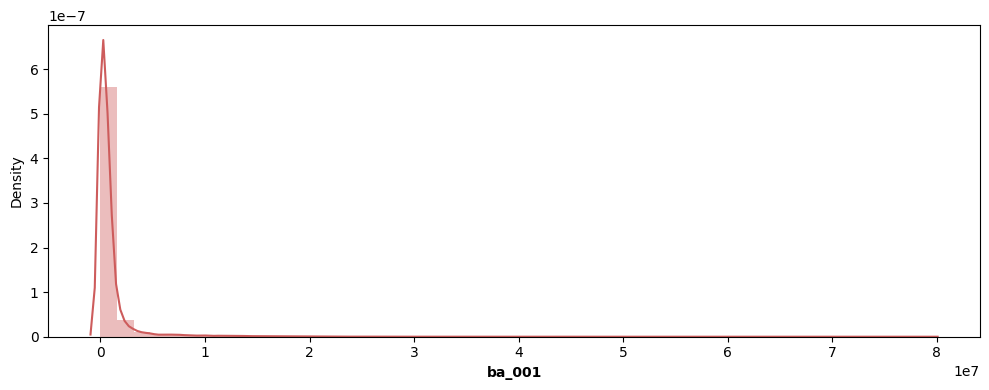

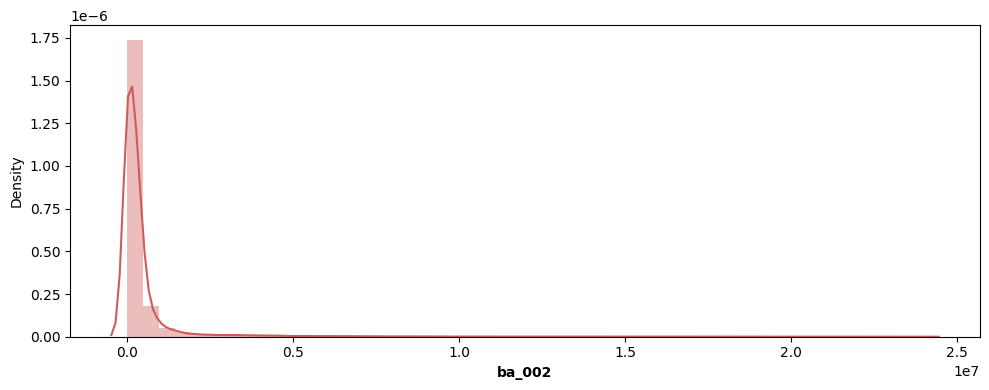

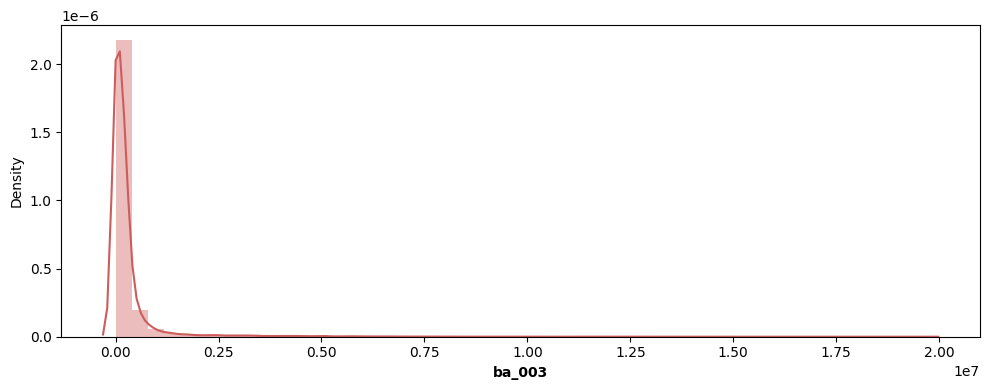

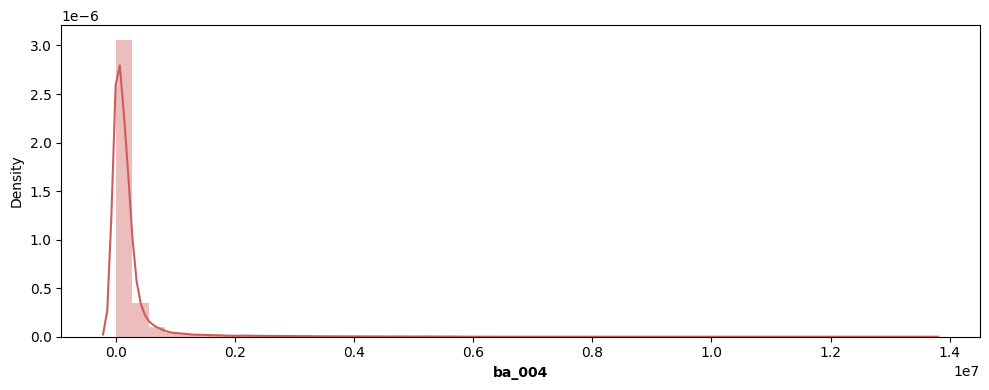

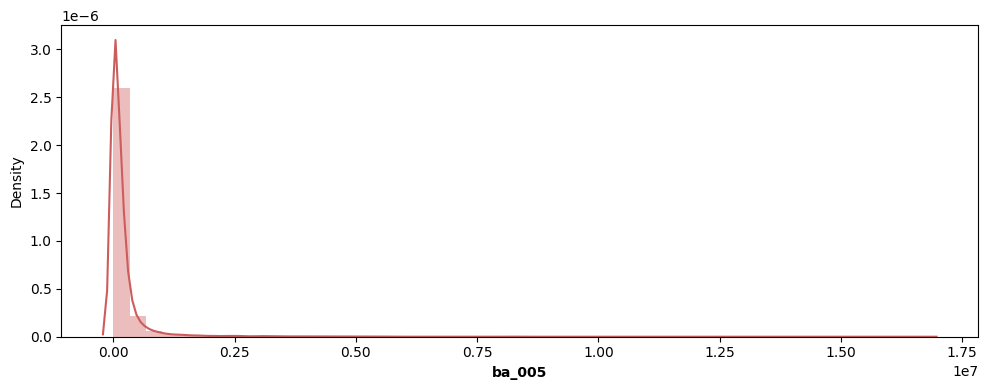

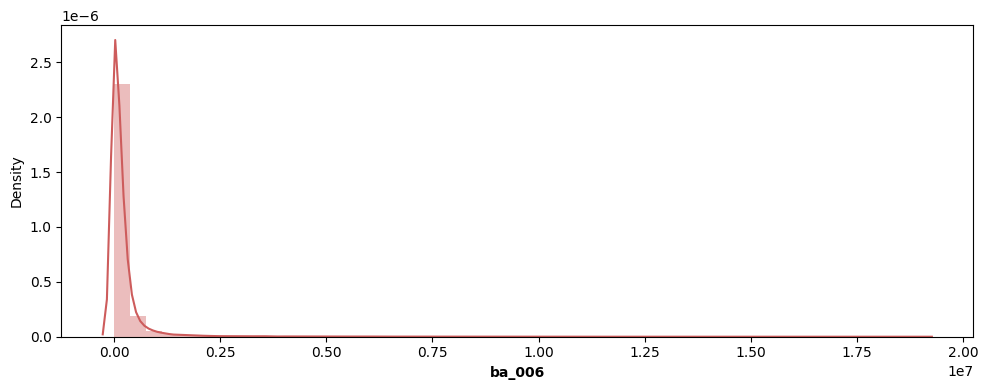

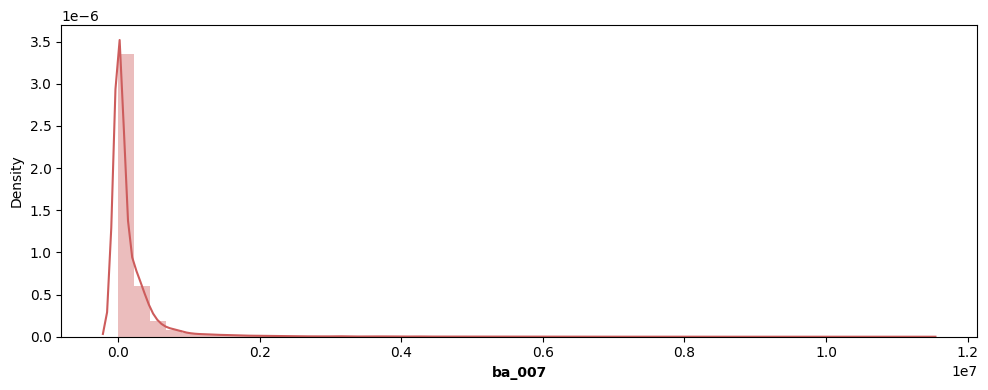

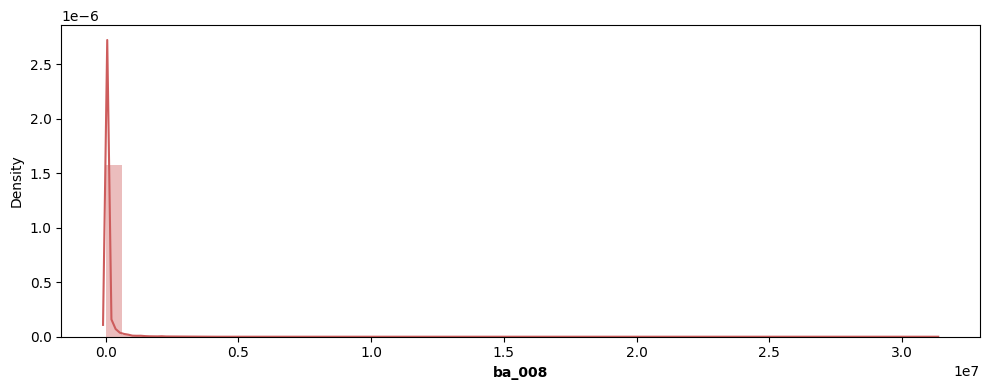

Plotting Batches:  35%|███████████████████████████████████████████████████████████▋                                                                                                             | 6/17 [00:35<01:05,  5.97s/batch]

Processing and plotting batch 7/17


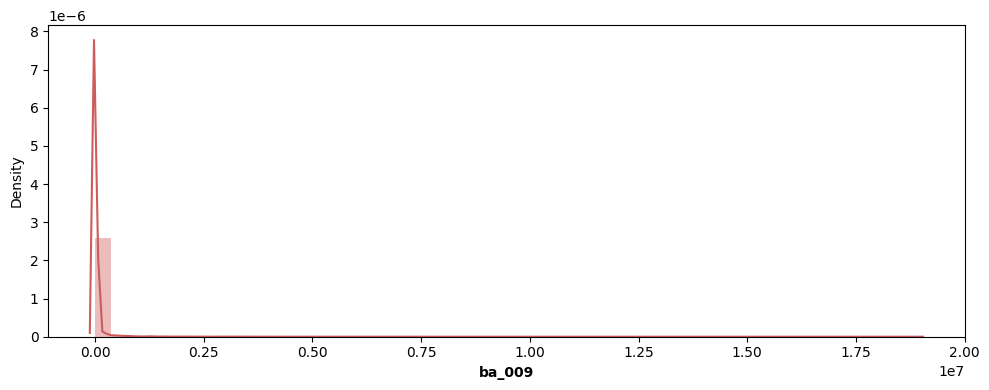

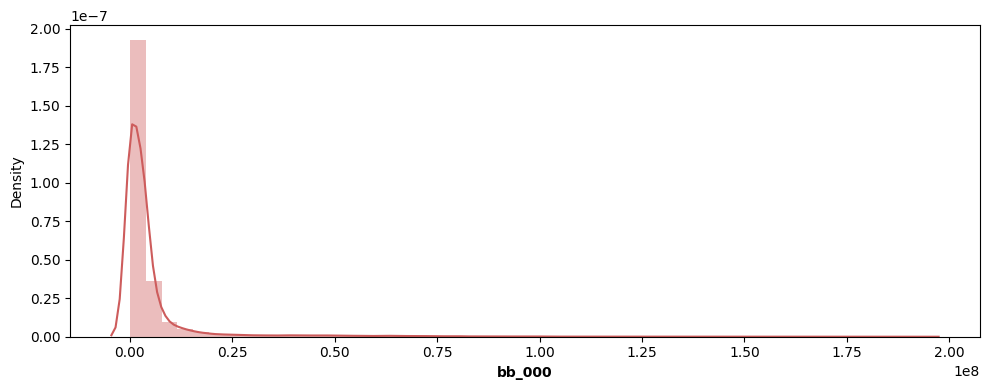

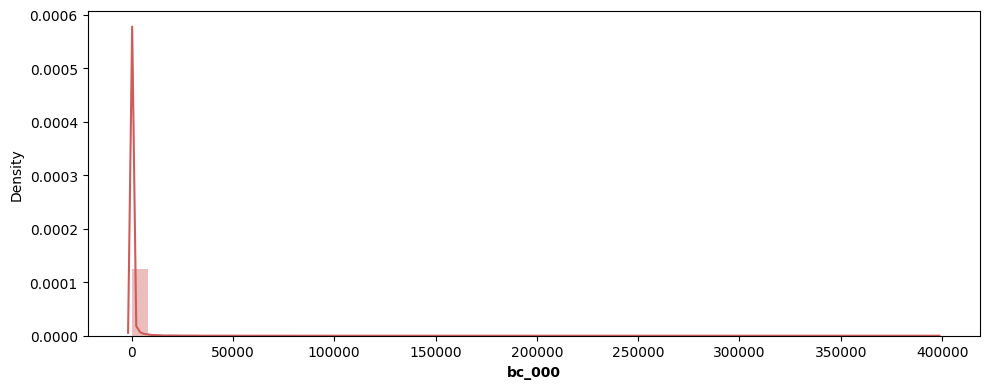

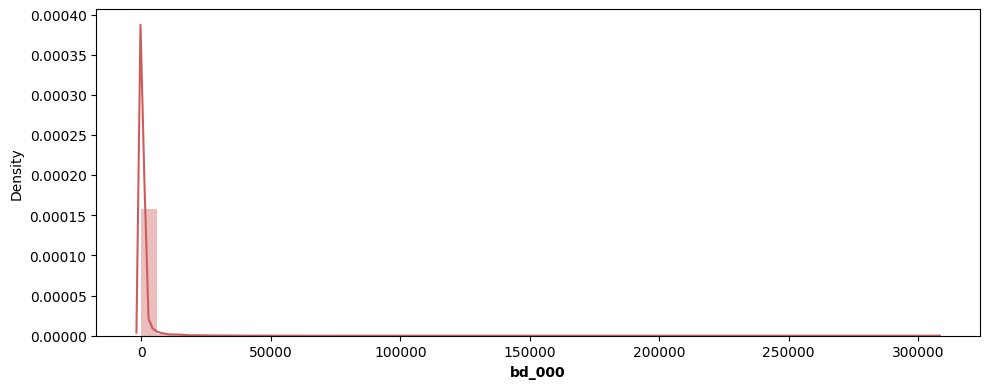

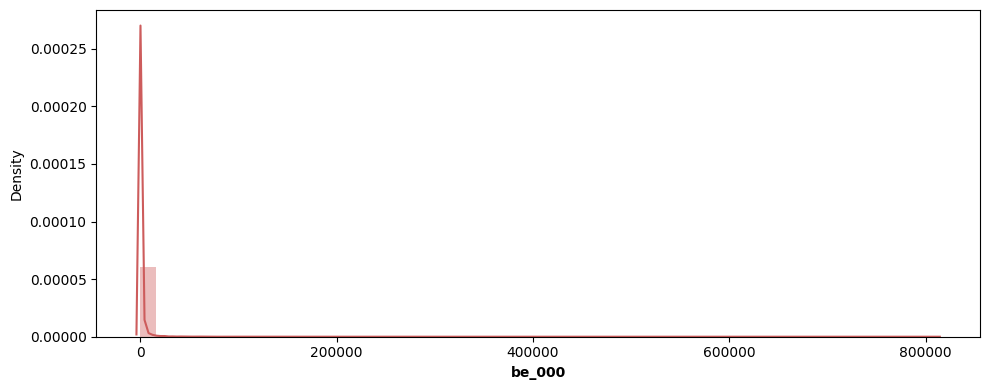

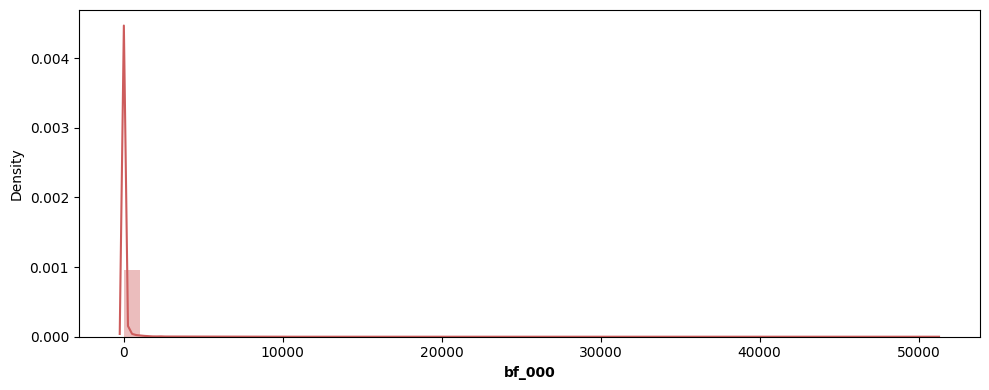

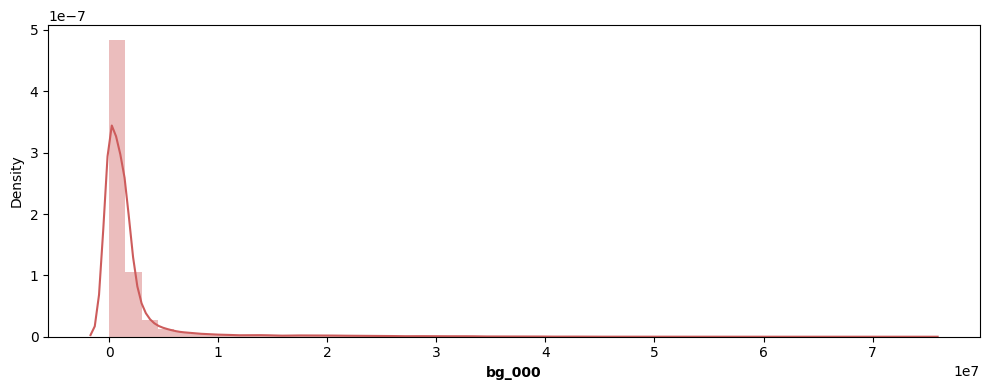

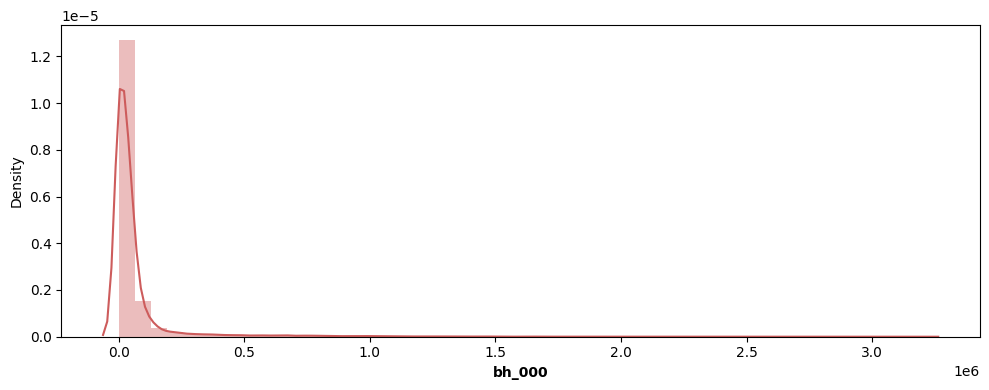

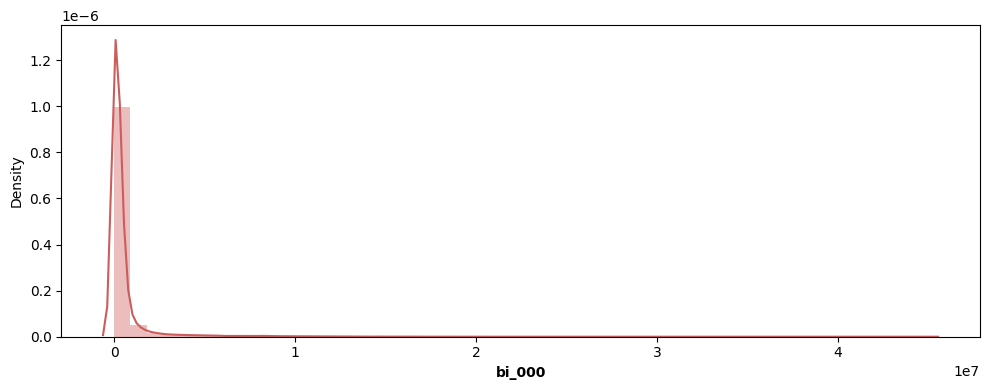

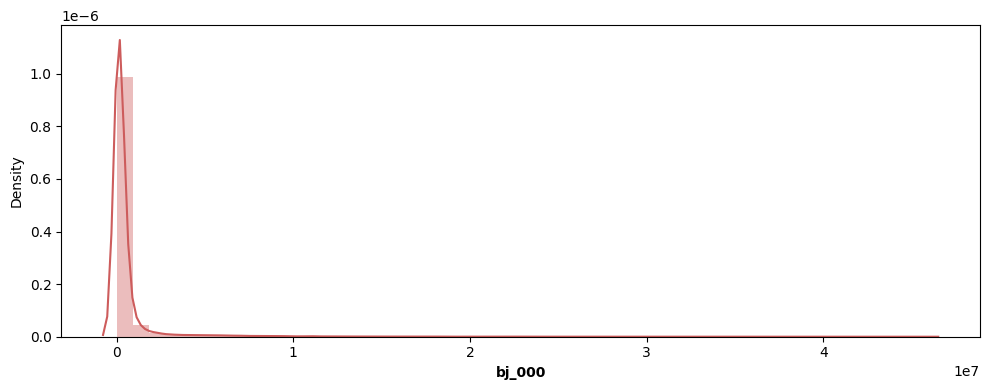

Plotting Batches:  41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 7/17 [00:42<01:00,  6.02s/batch]

Processing and plotting batch 8/17


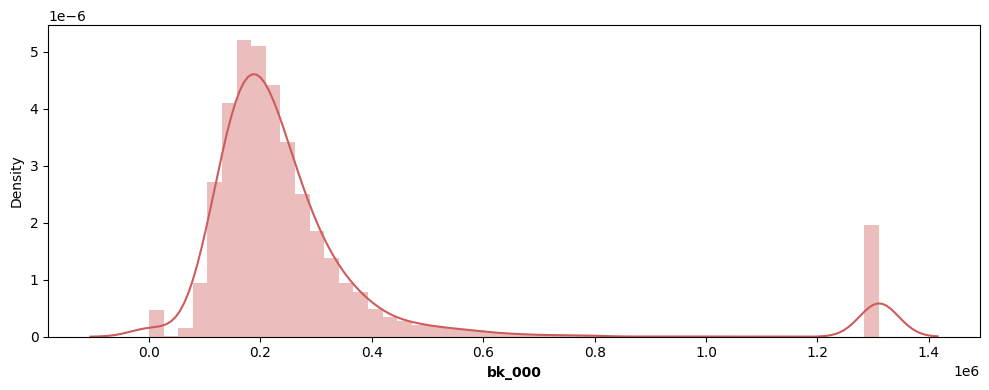

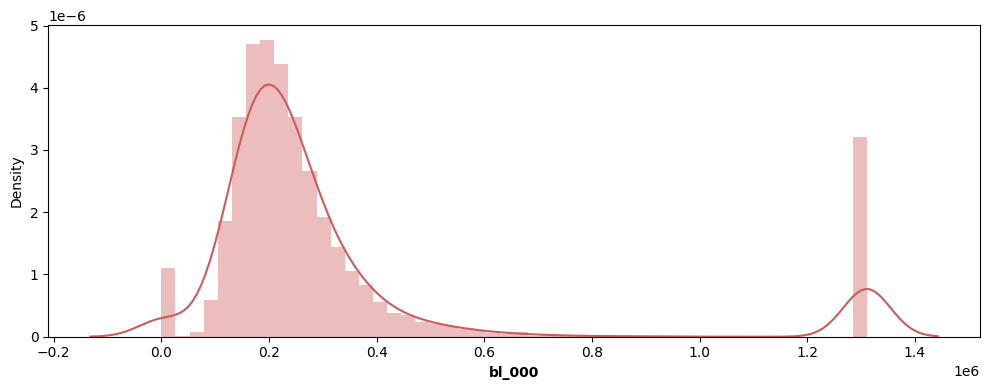

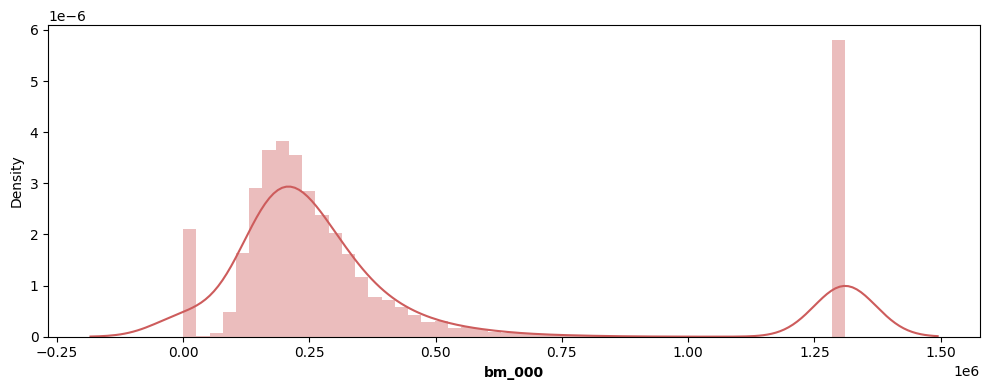

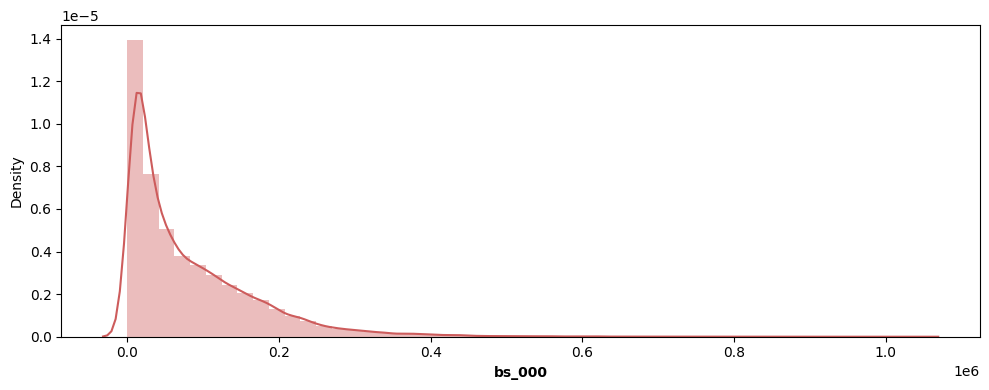

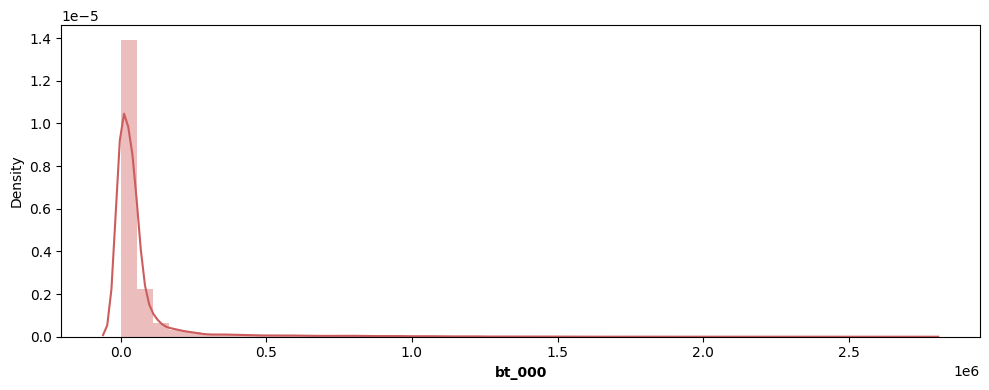

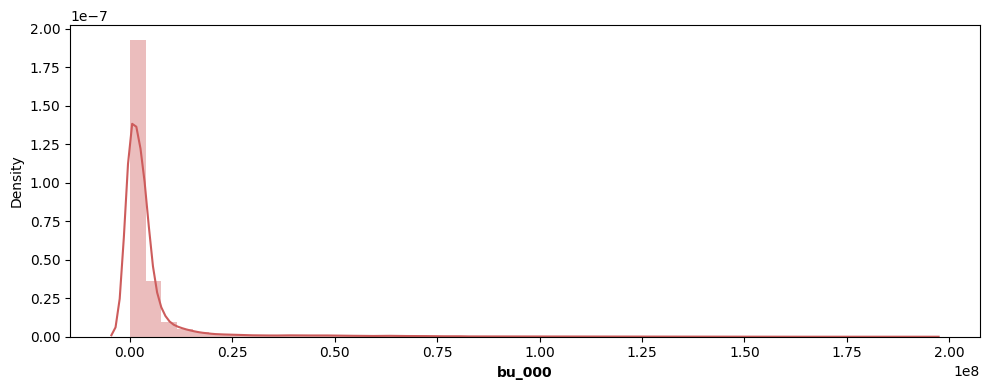

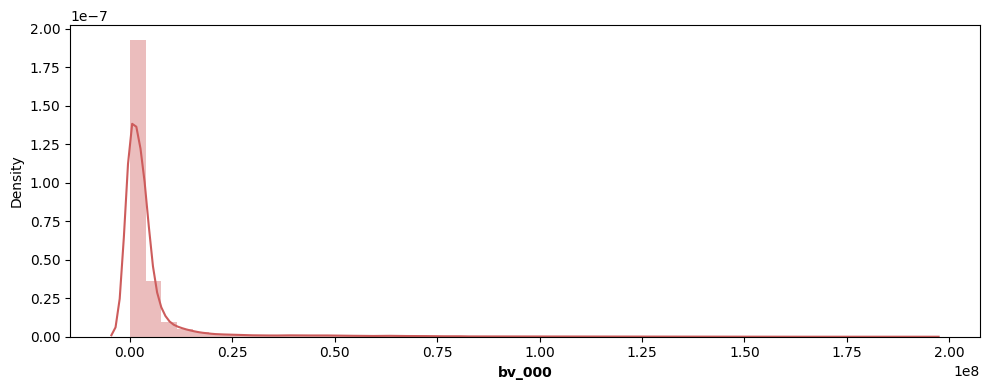

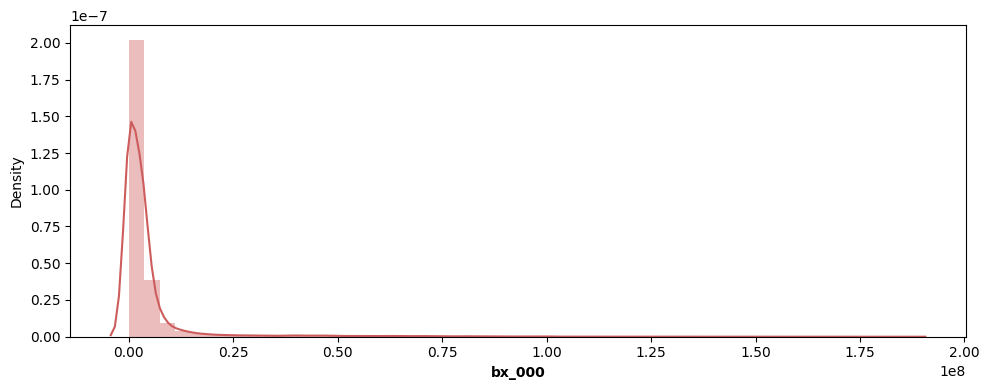

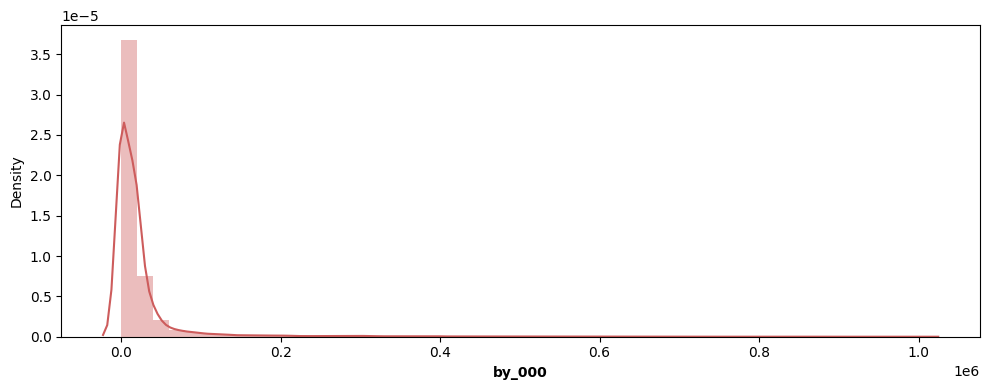

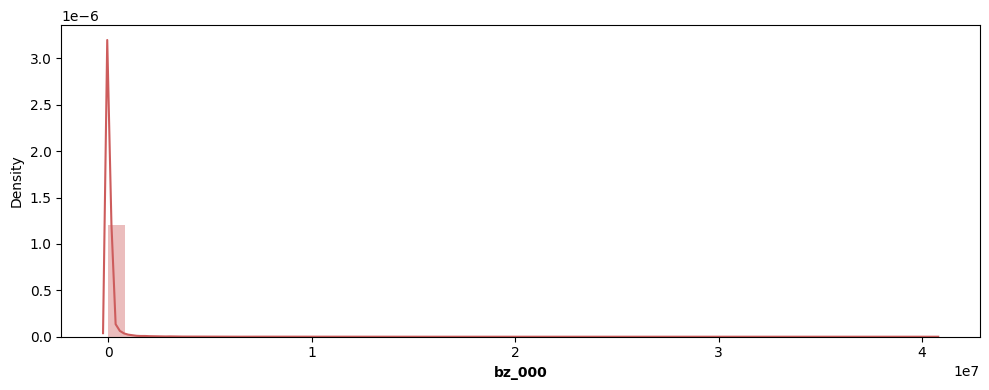

Plotting Batches:  47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                         | 8/17 [00:49<00:57,  6.44s/batch]

Processing and plotting batch 9/17


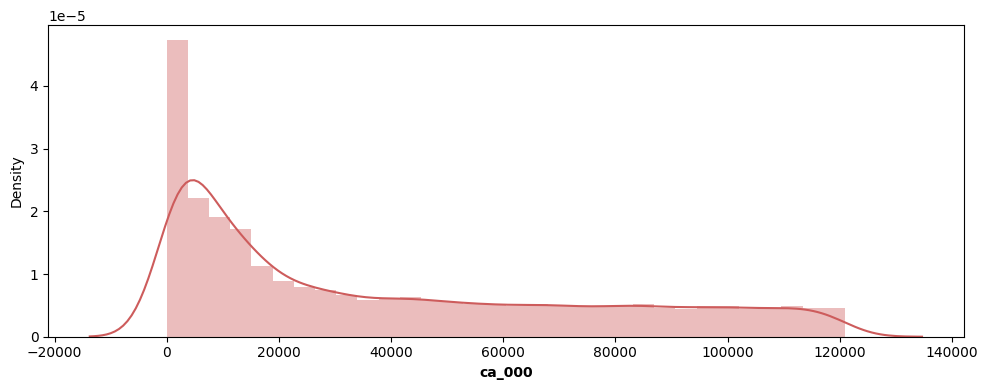

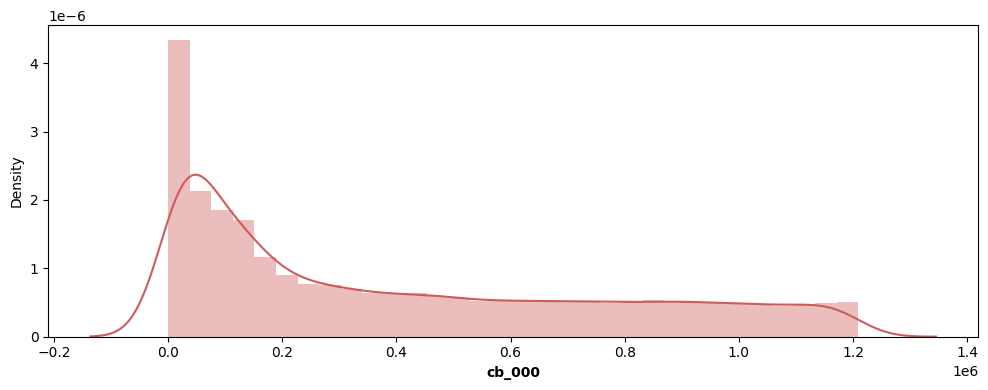

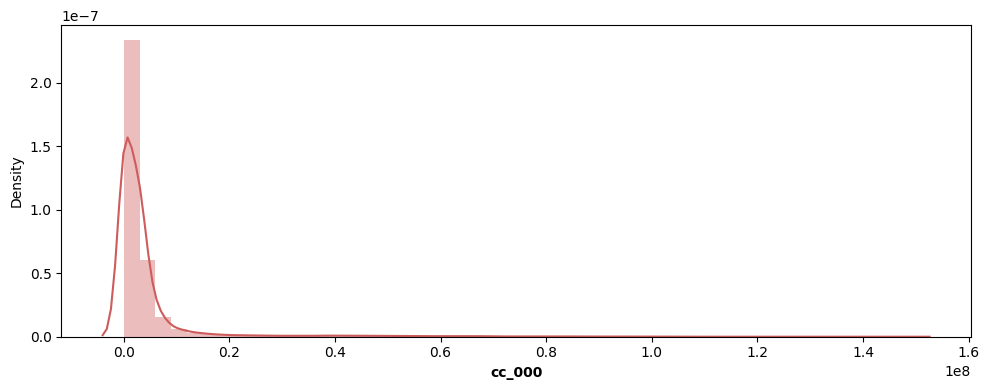

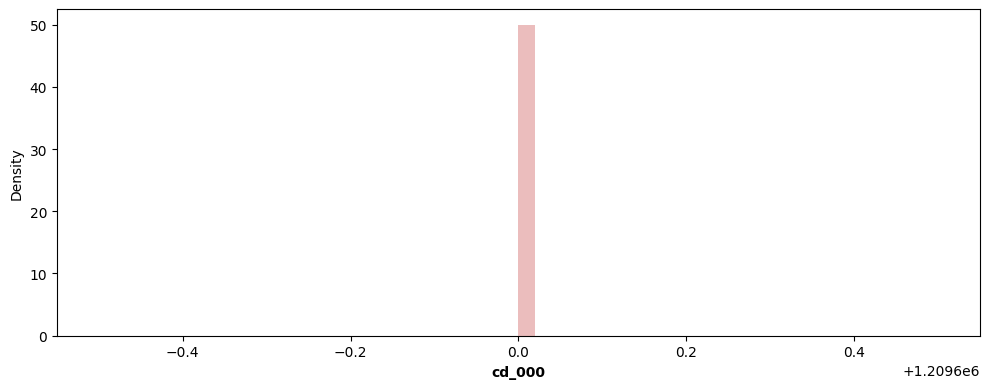

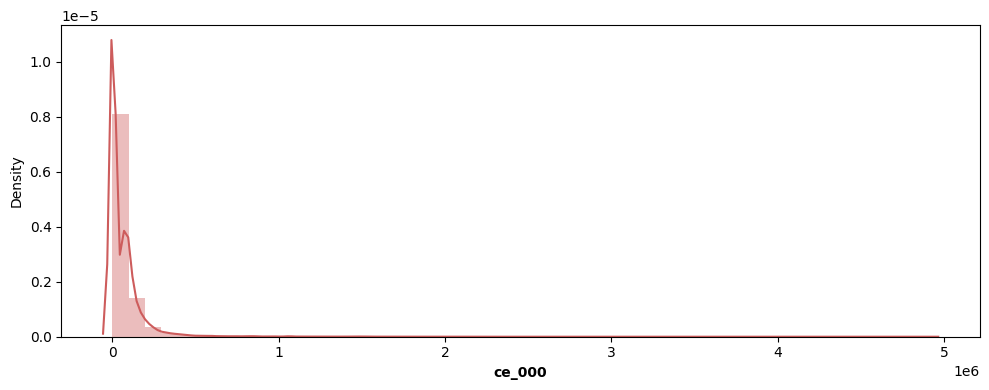

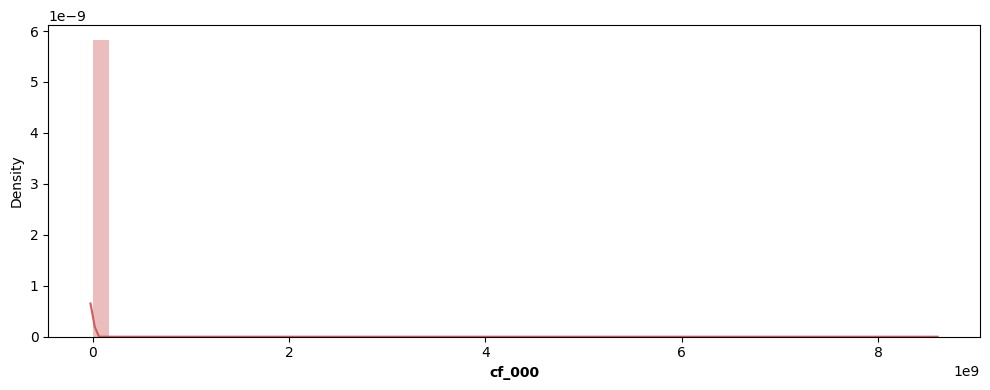

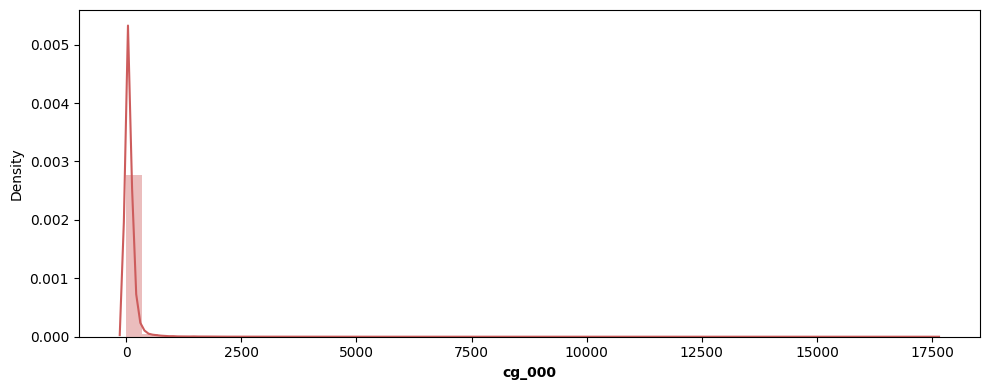

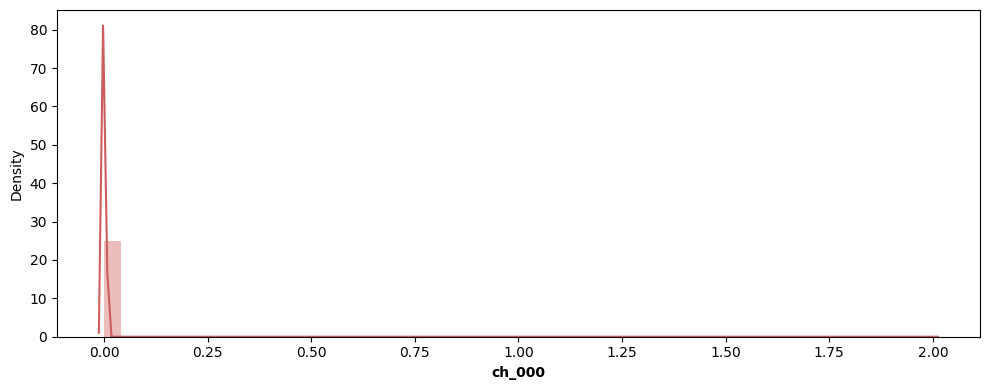

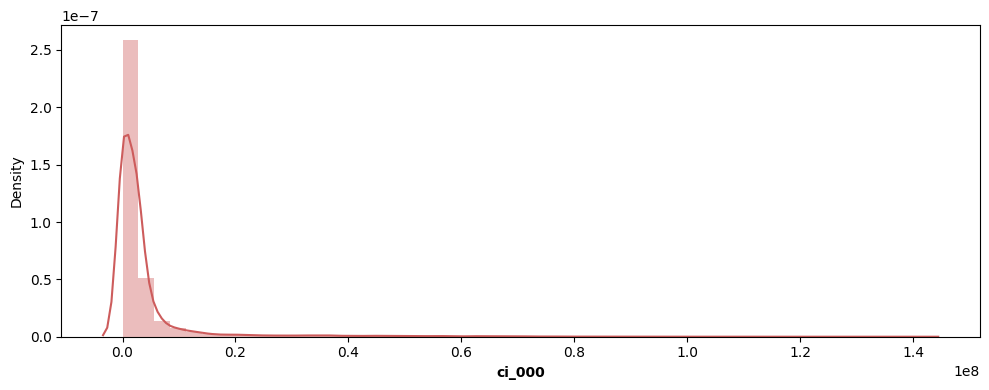

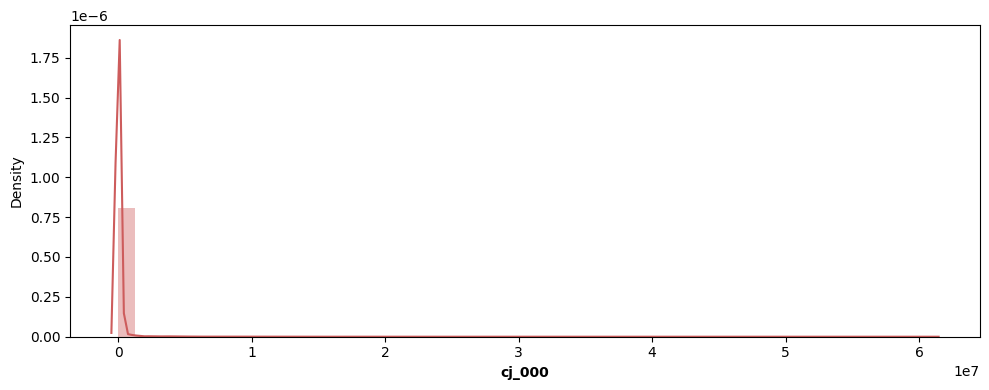

Plotting Batches:  53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 9/17 [00:56<00:52,  6.56s/batch]

Processing and plotting batch 10/17


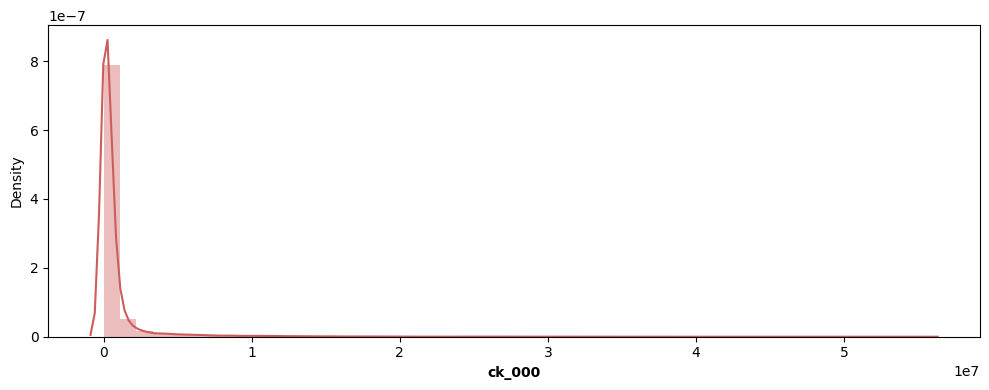

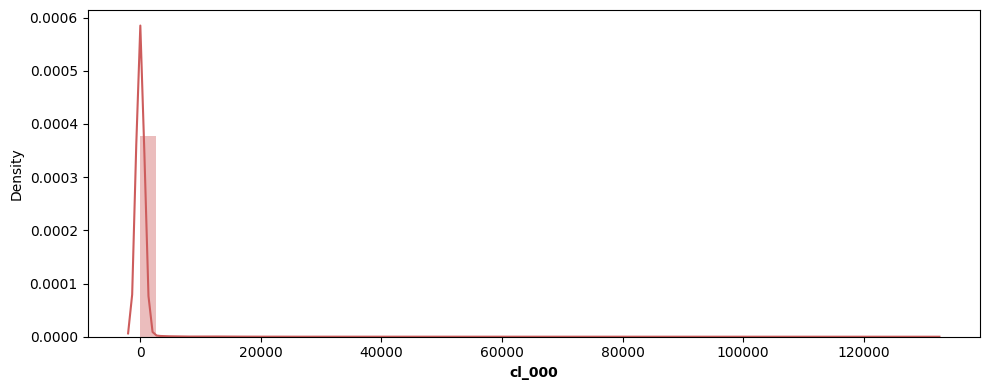

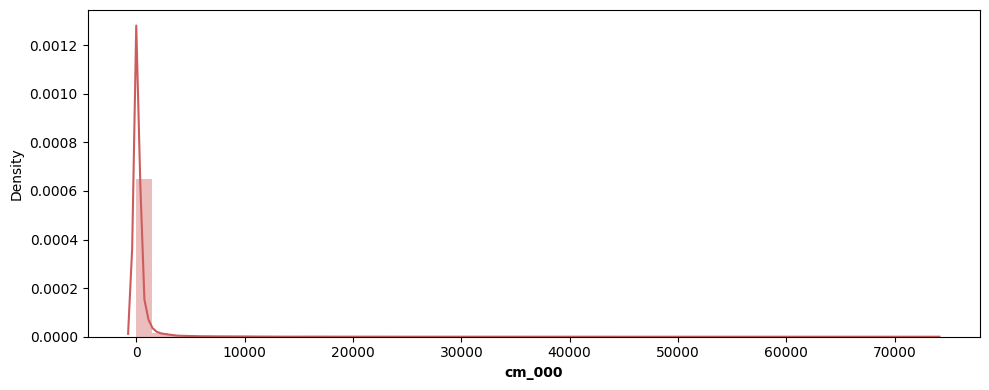

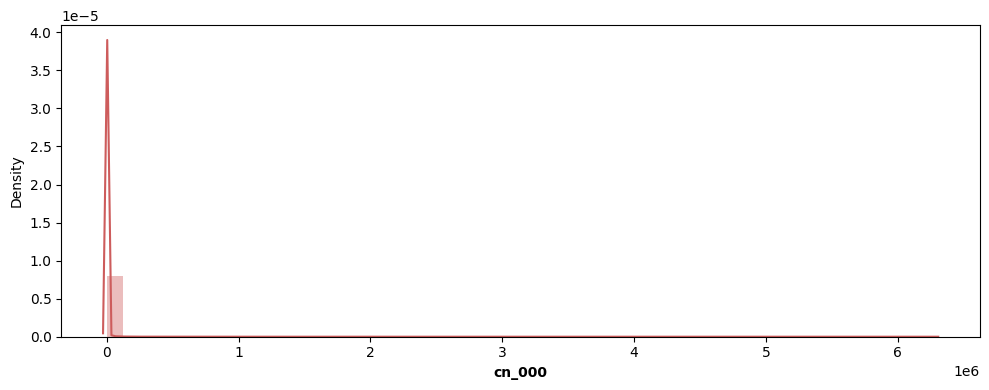

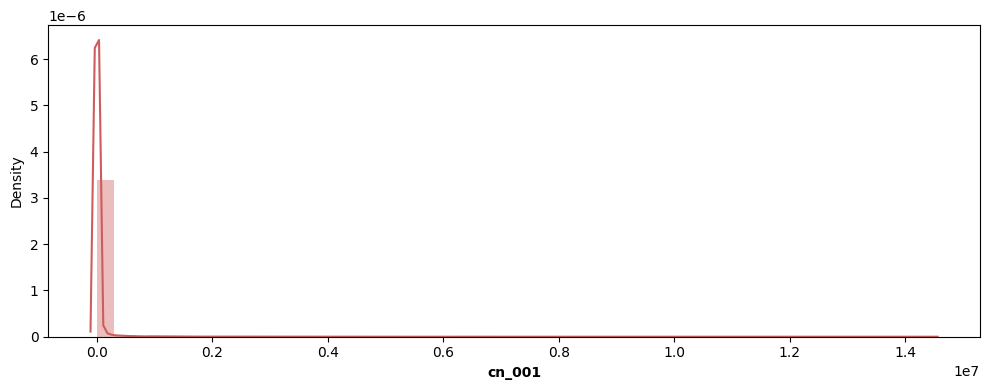

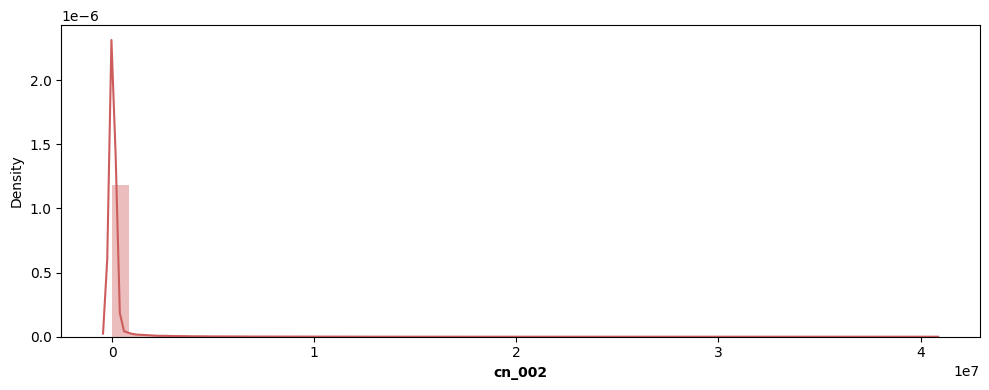

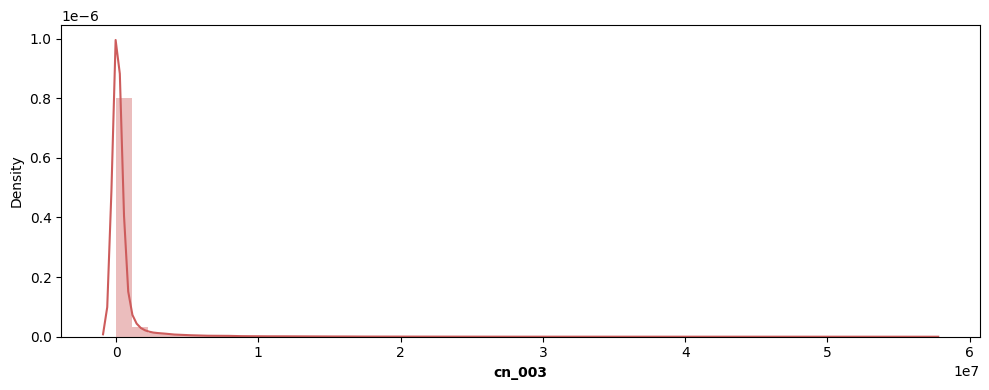

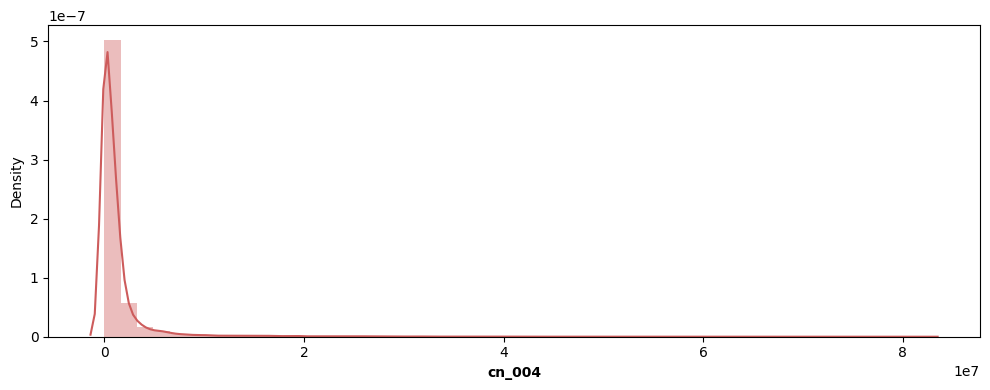

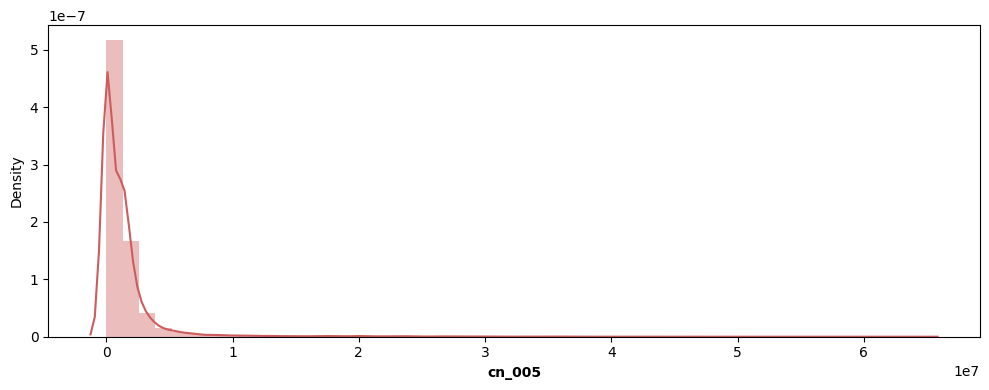

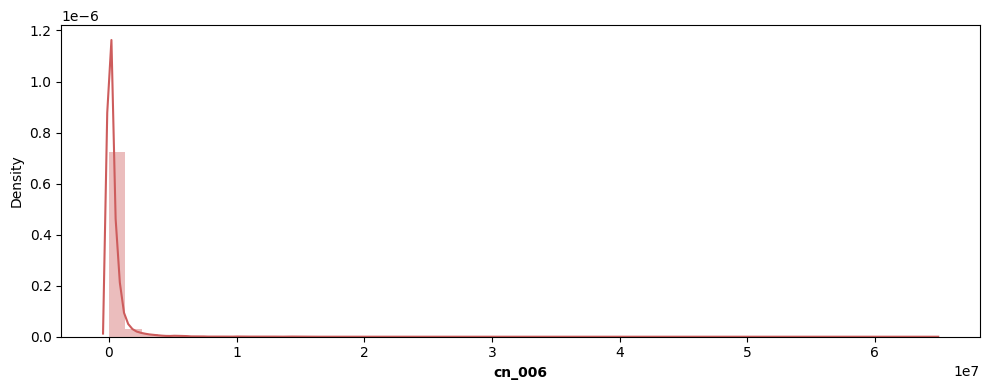

Plotting Batches:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 10/17 [01:02<00:44,  6.40s/batch]

Processing and plotting batch 11/17


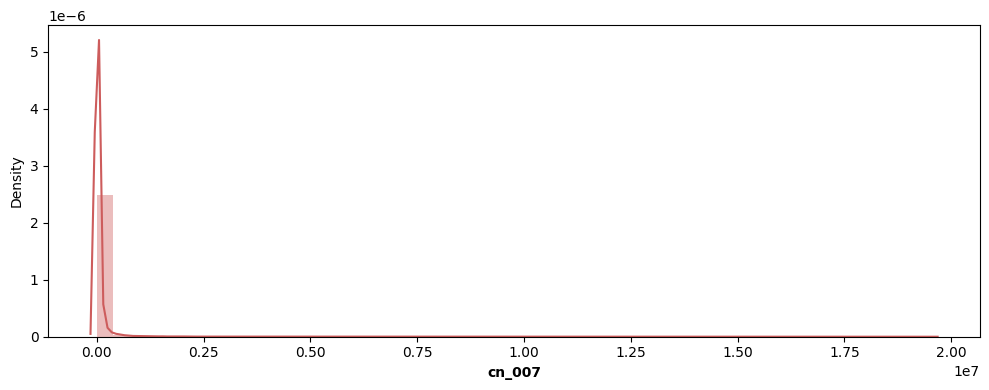

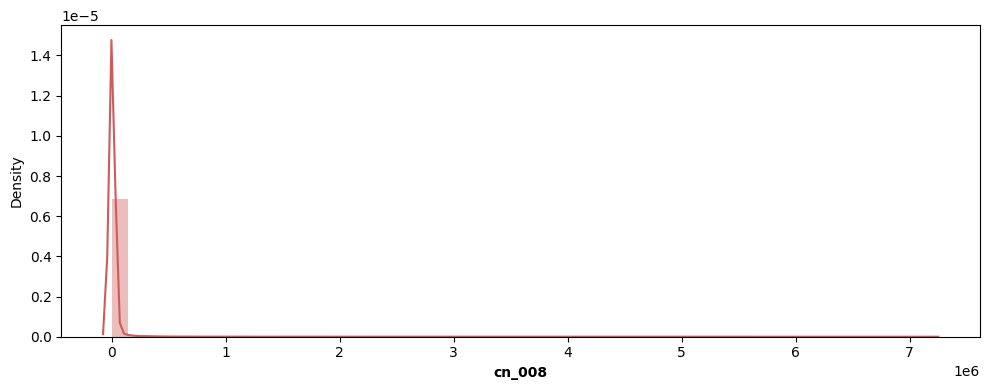

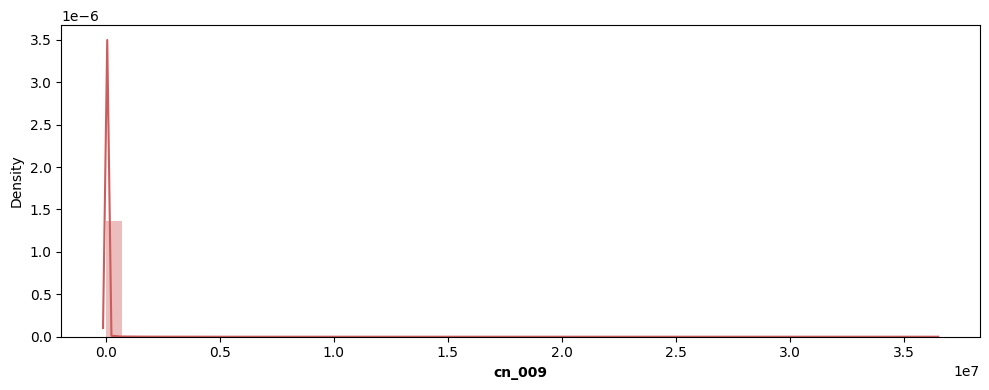

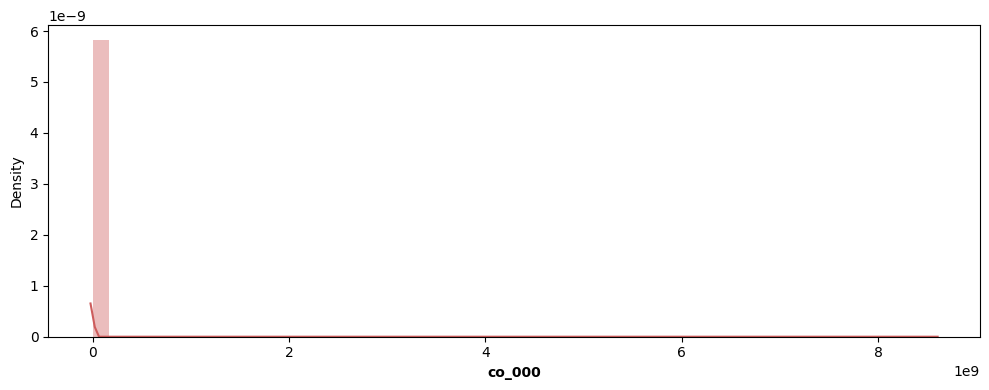

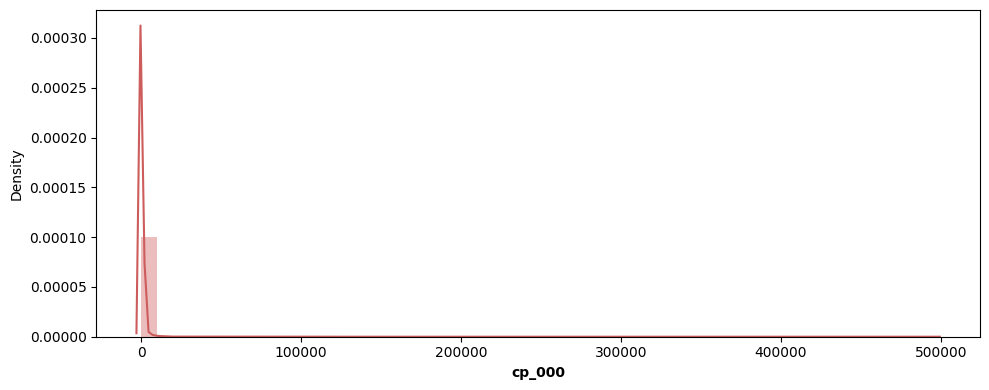

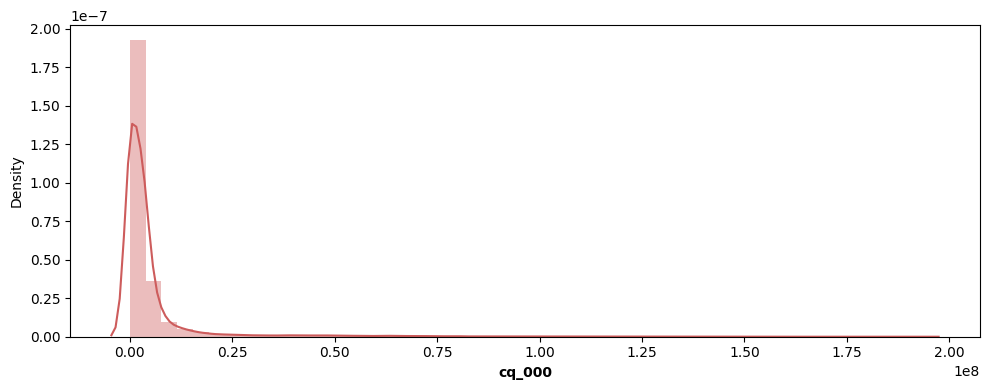

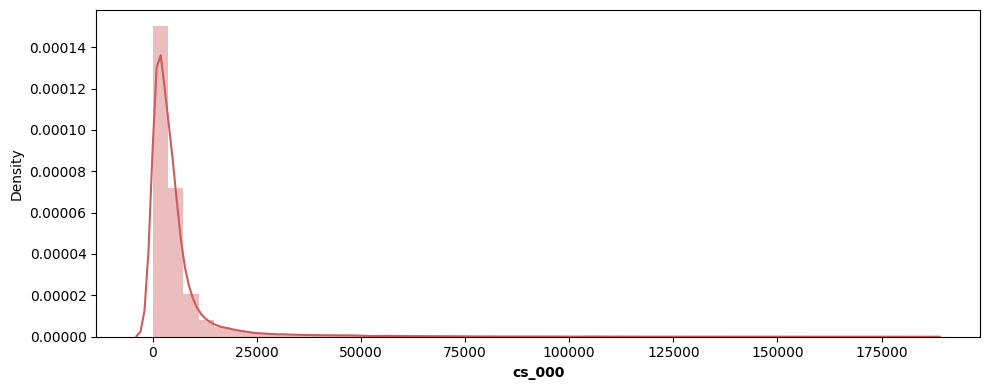

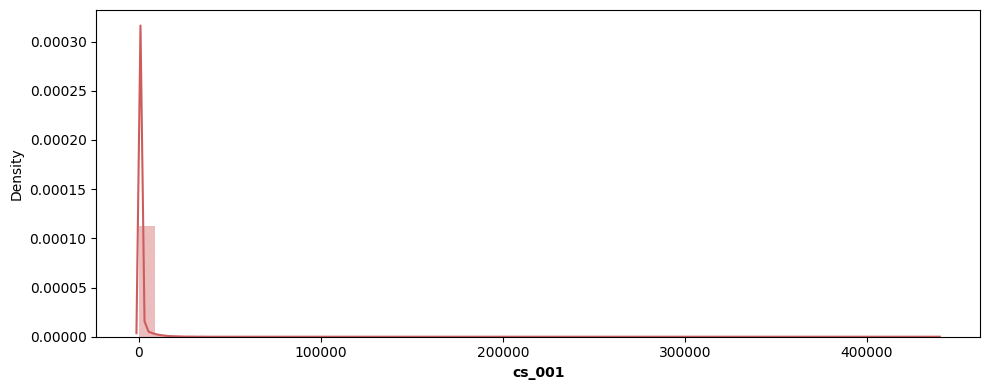

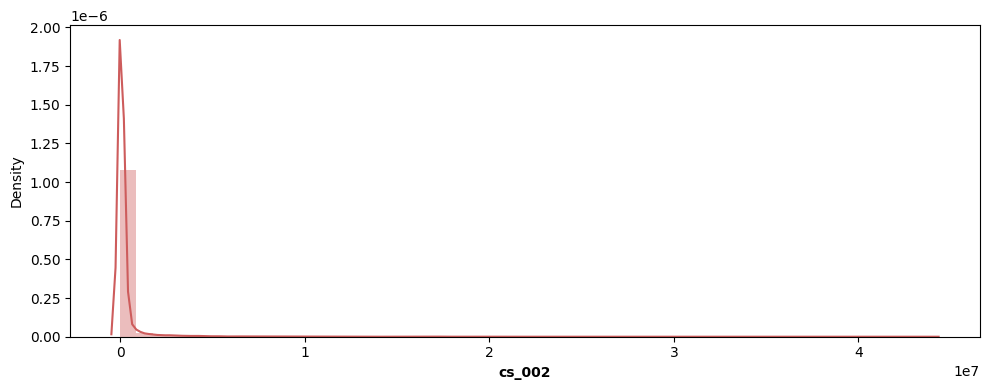

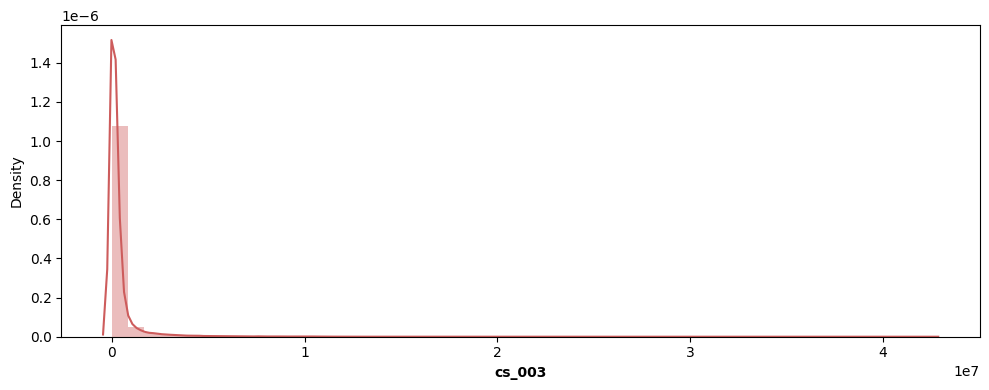

Plotting Batches:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 11/17 [01:08<00:37,  6.22s/batch]

Processing and plotting batch 12/17


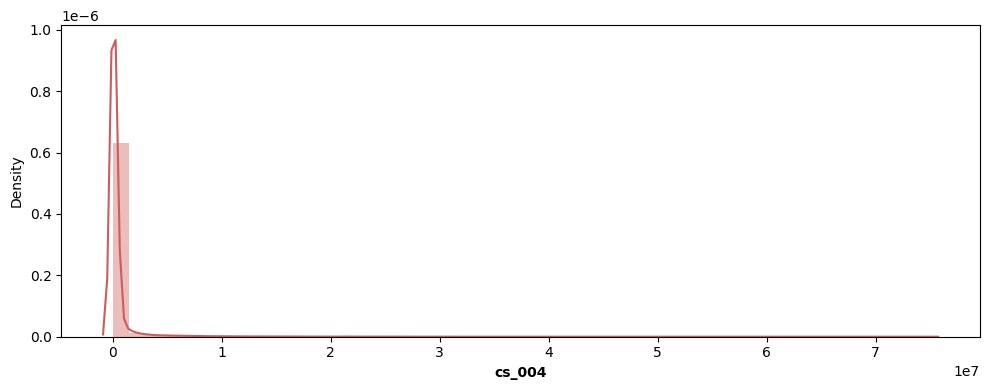

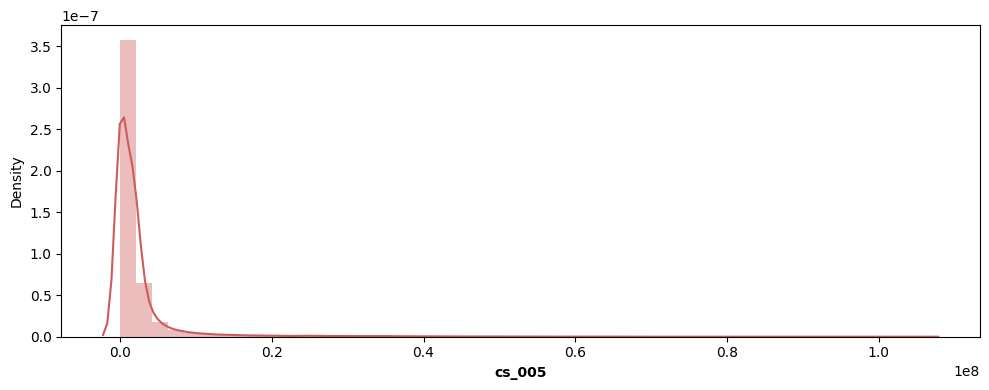

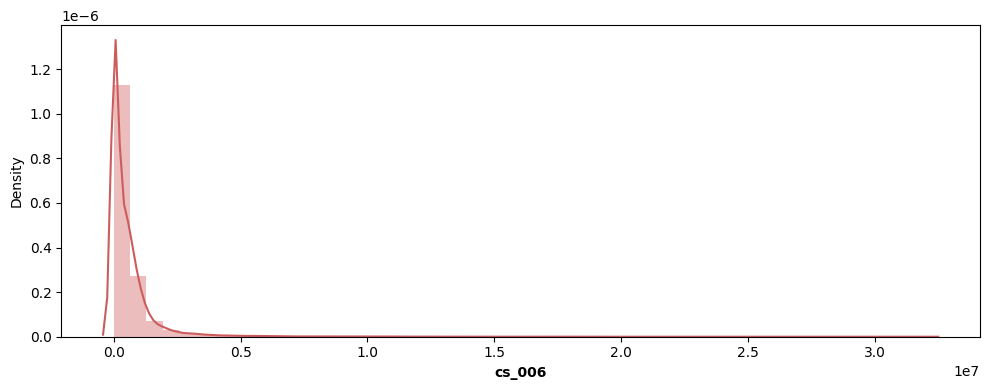

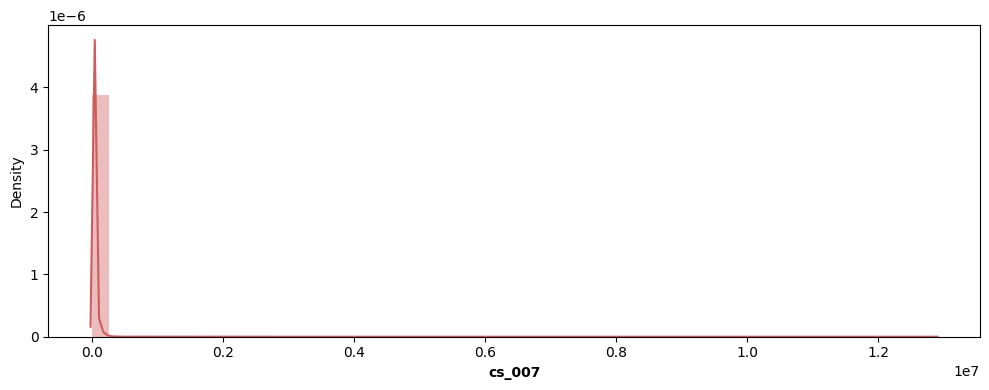

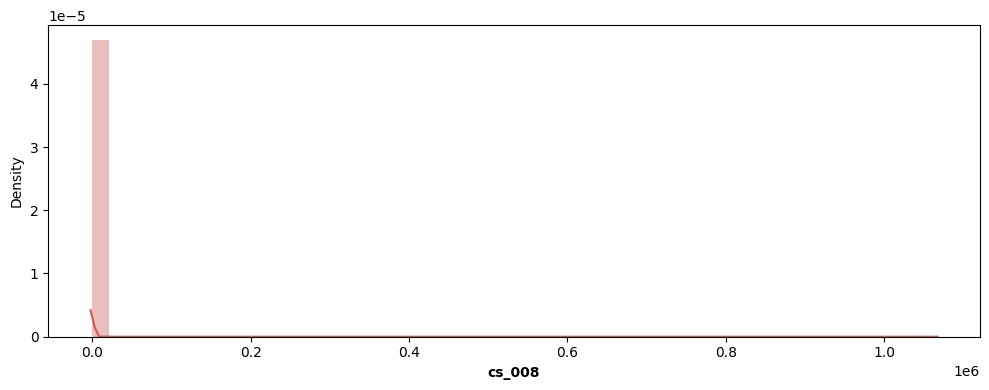

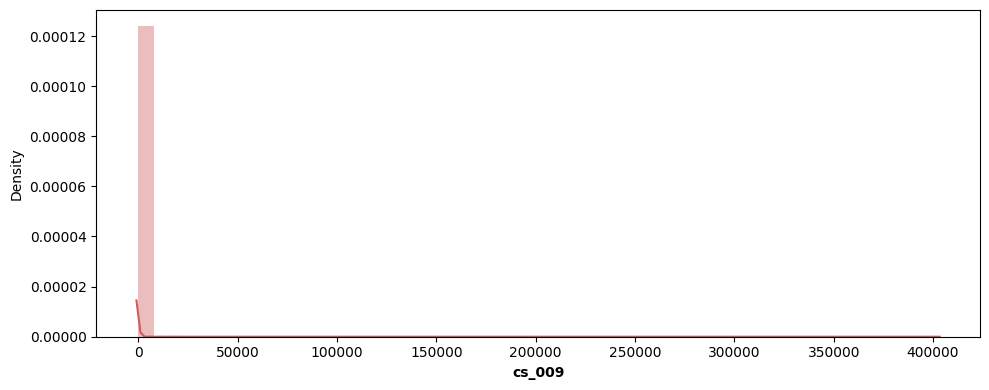

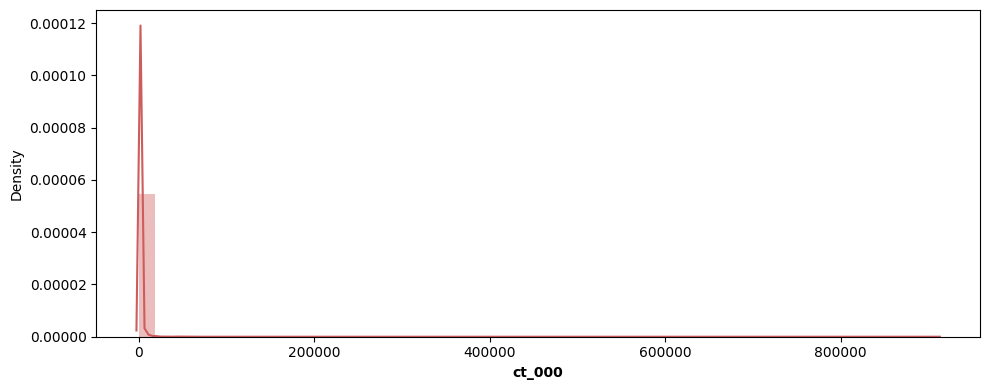

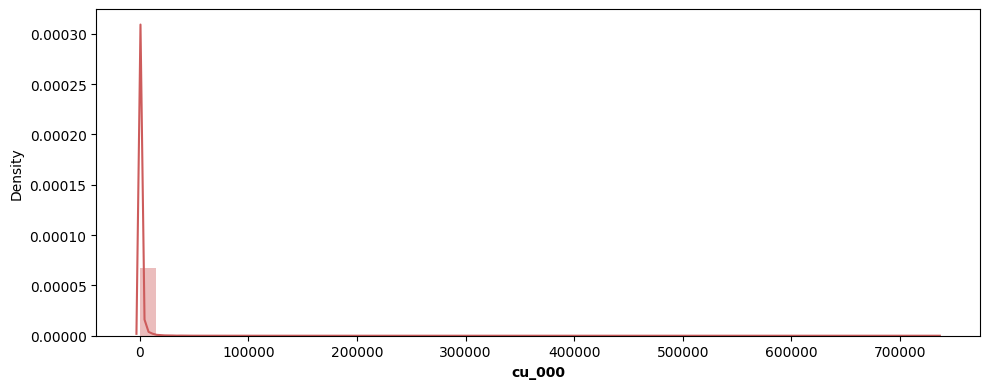

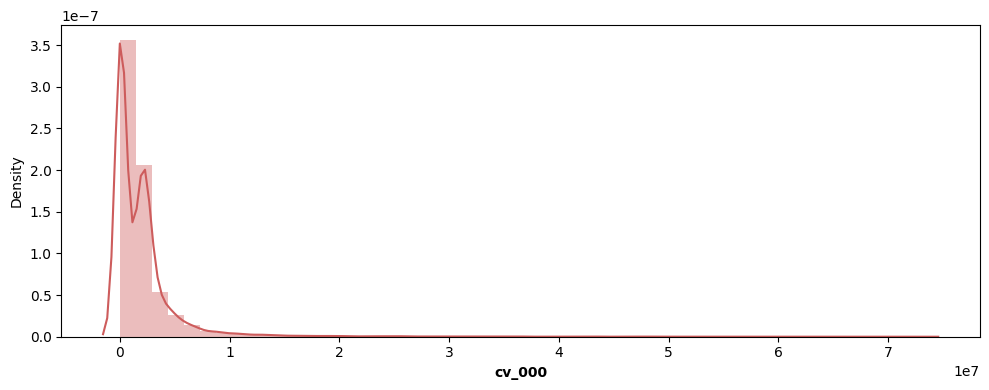

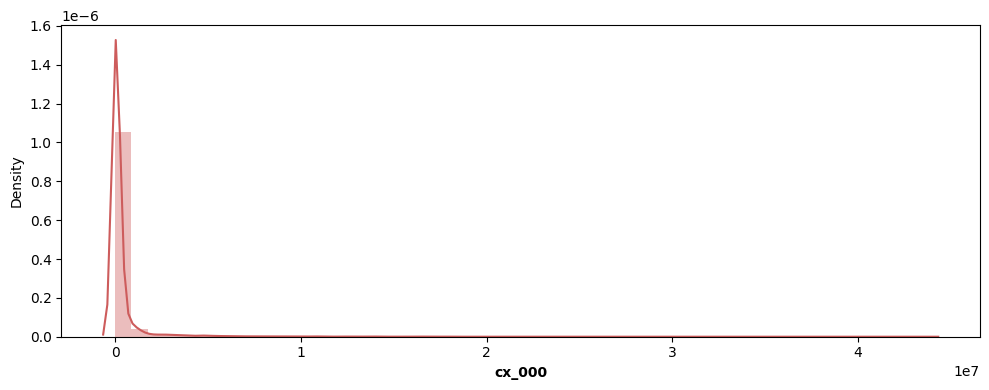

Plotting Batches:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 12/17 [01:13<00:30,  6.03s/batch]

Processing and plotting batch 13/17


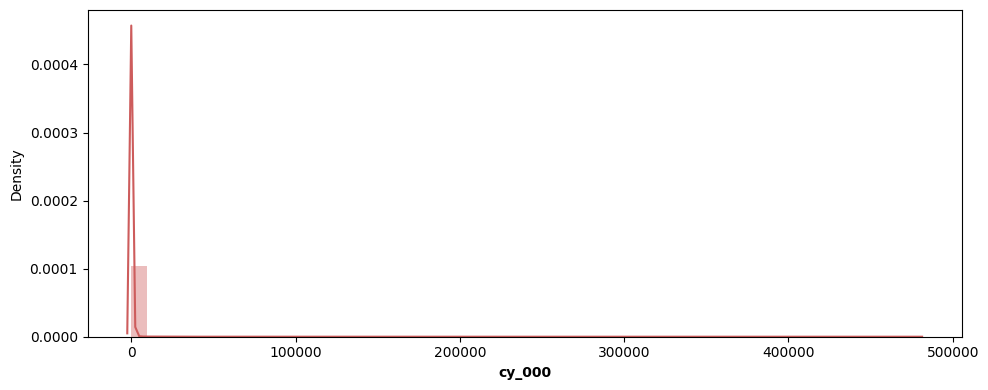

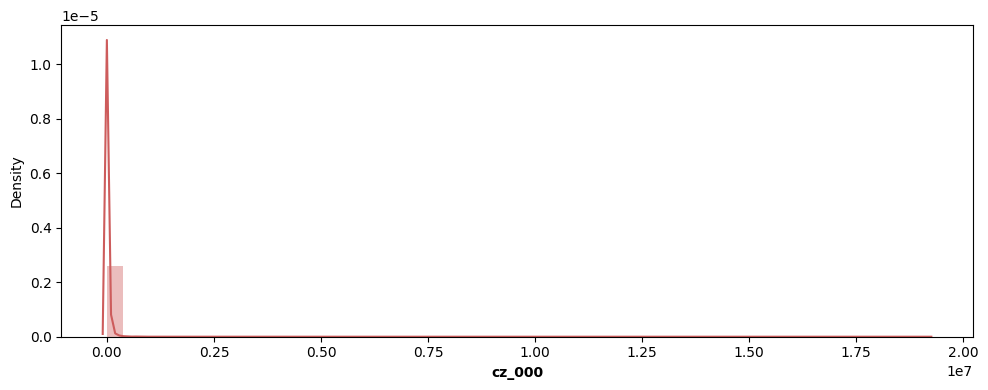

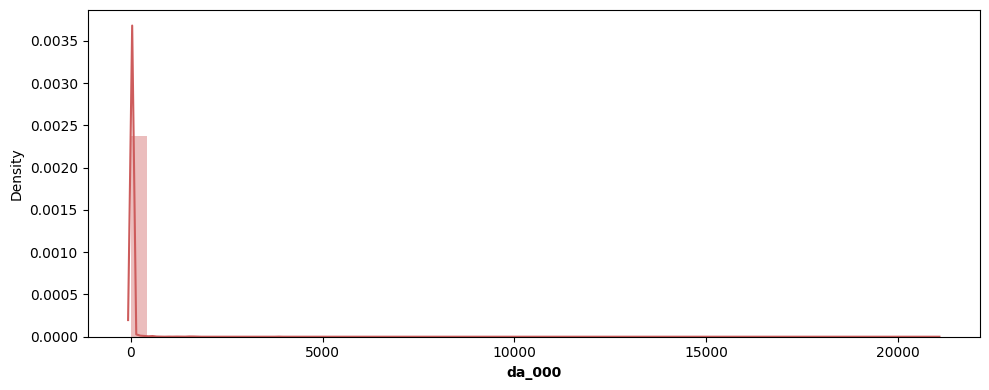

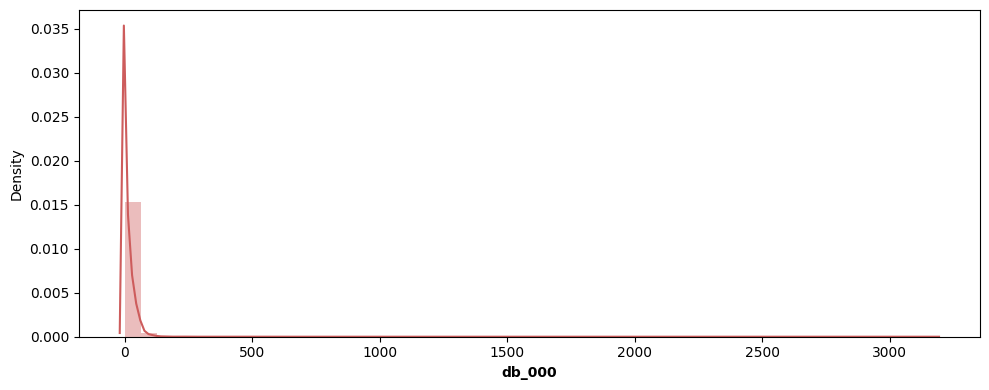

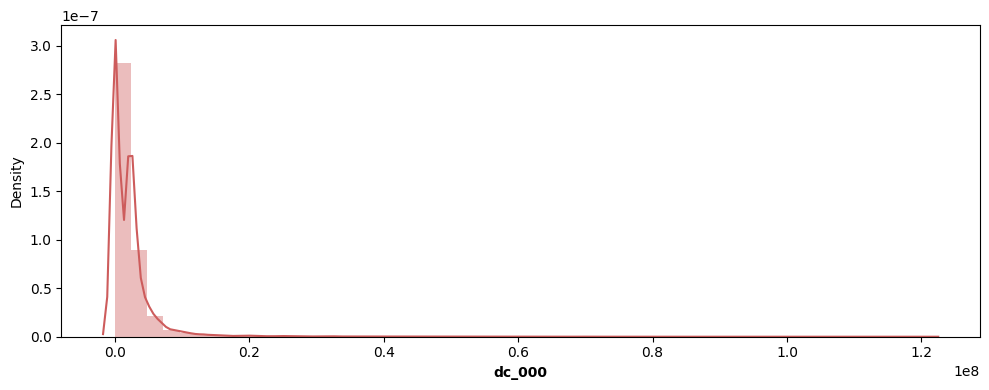

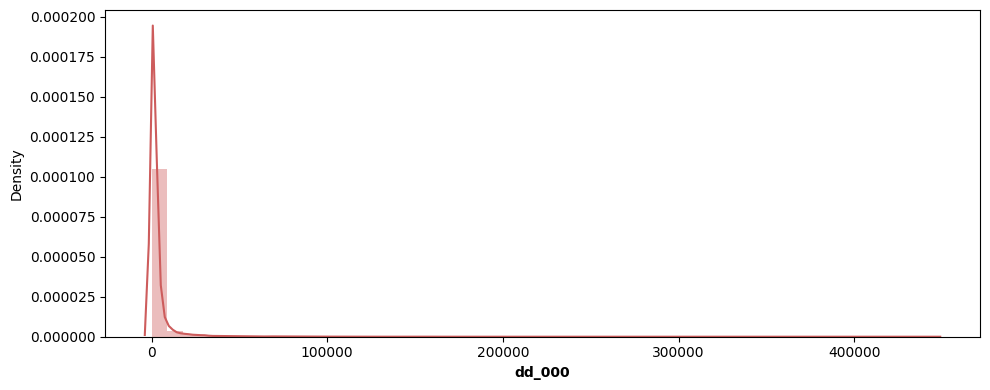

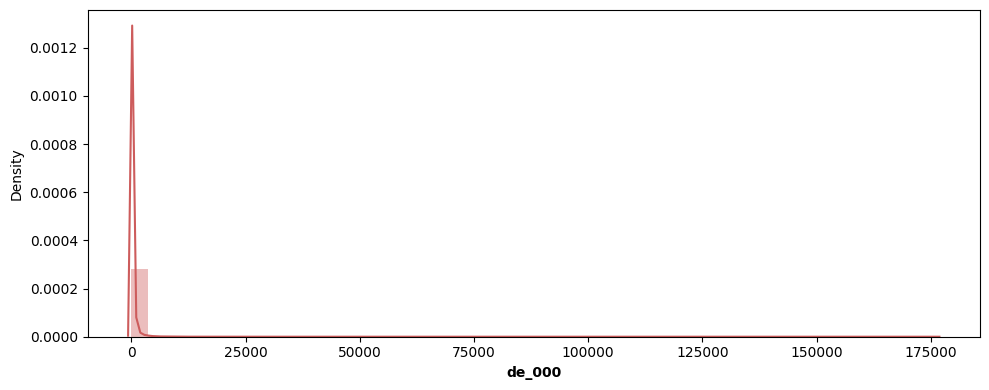

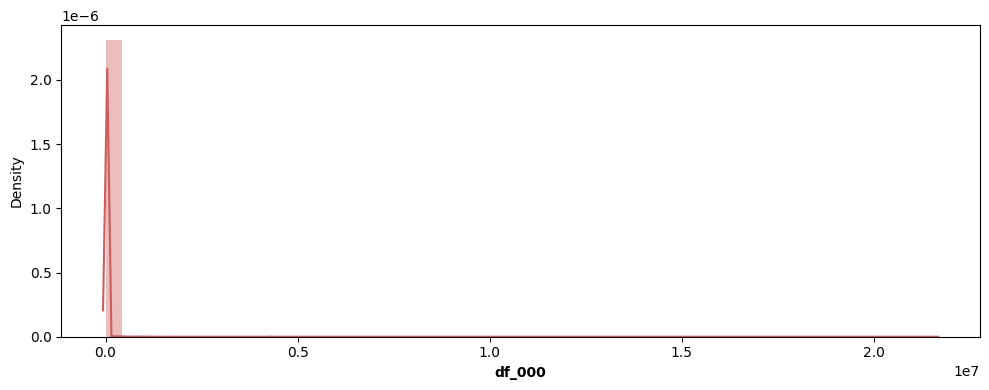

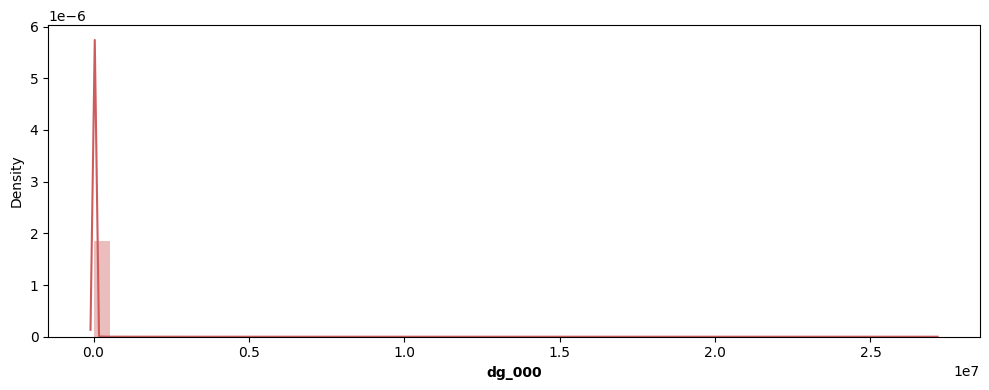

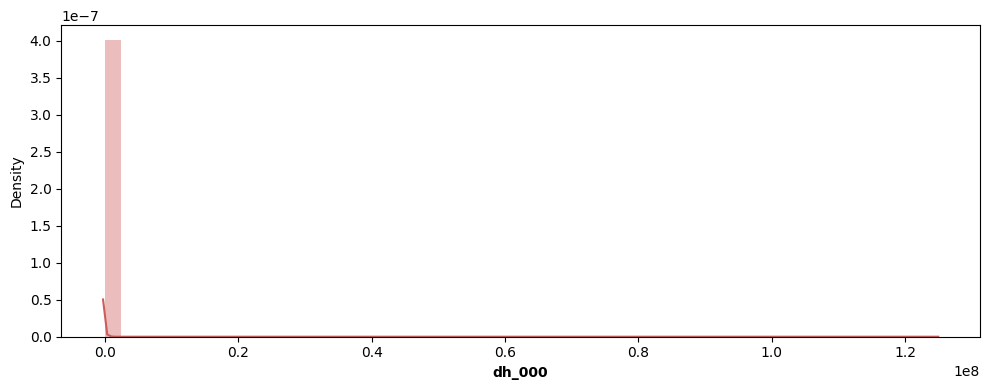

Plotting Batches:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 13/17 [01:18<00:23,  5.78s/batch]

Processing and plotting batch 14/17


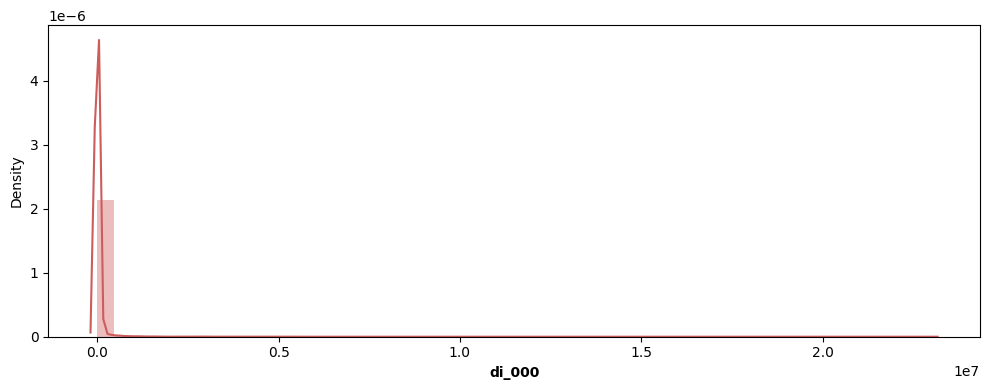

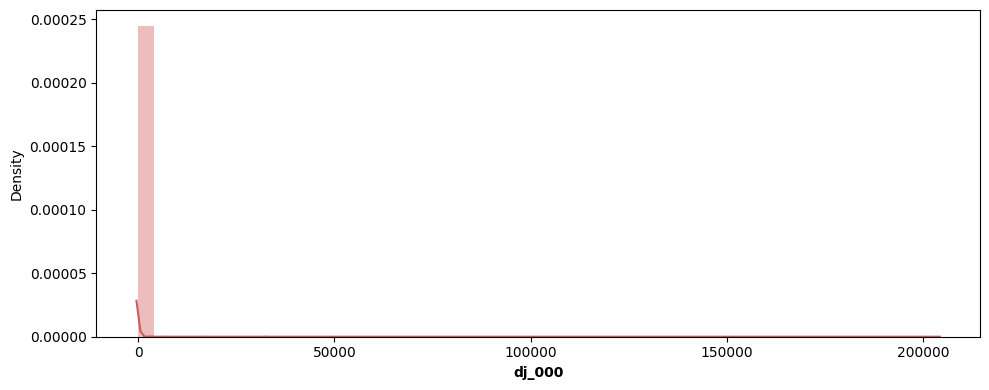

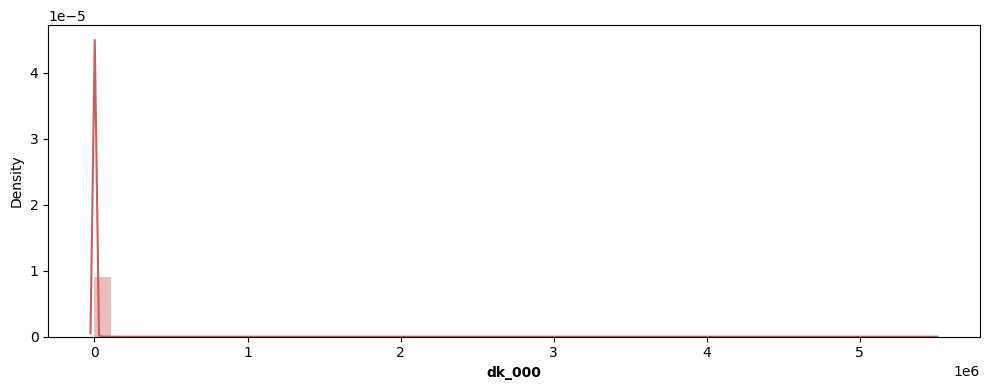

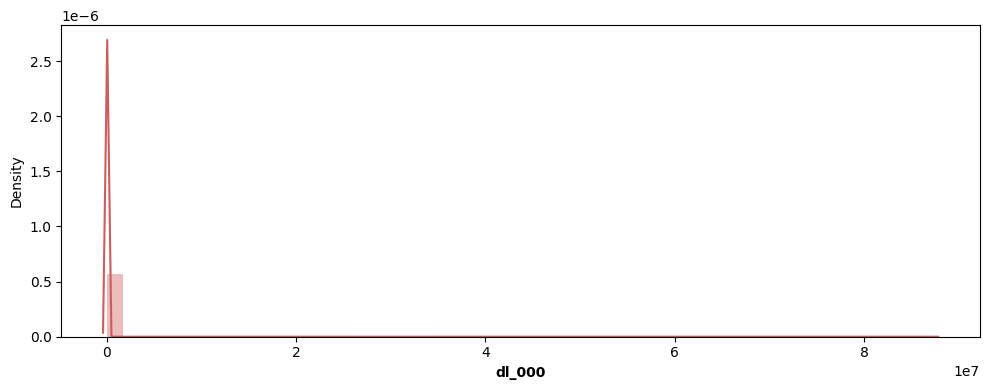

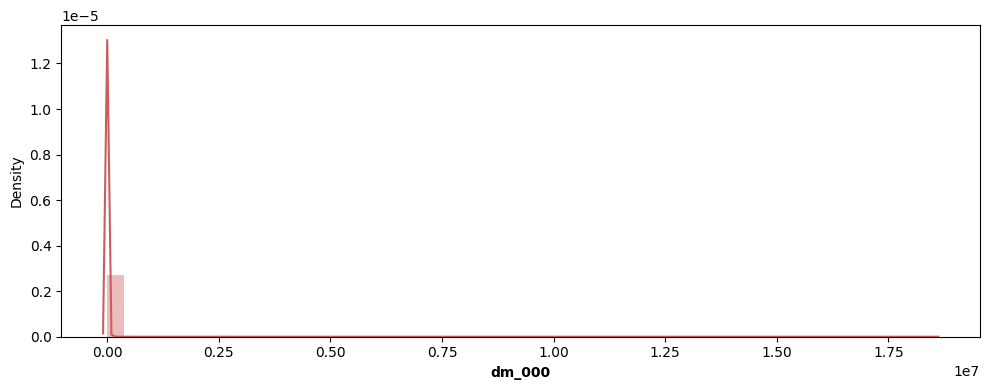

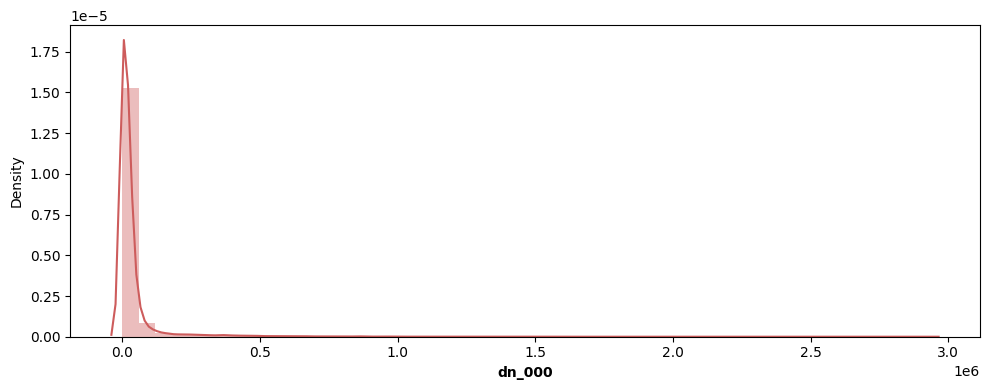

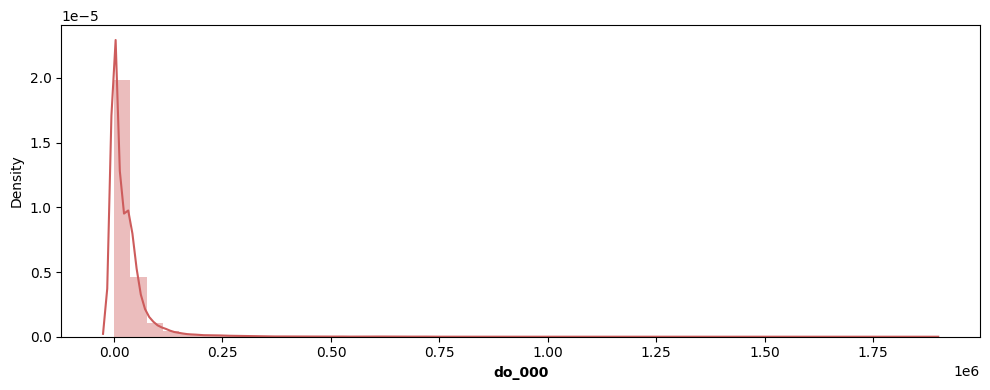

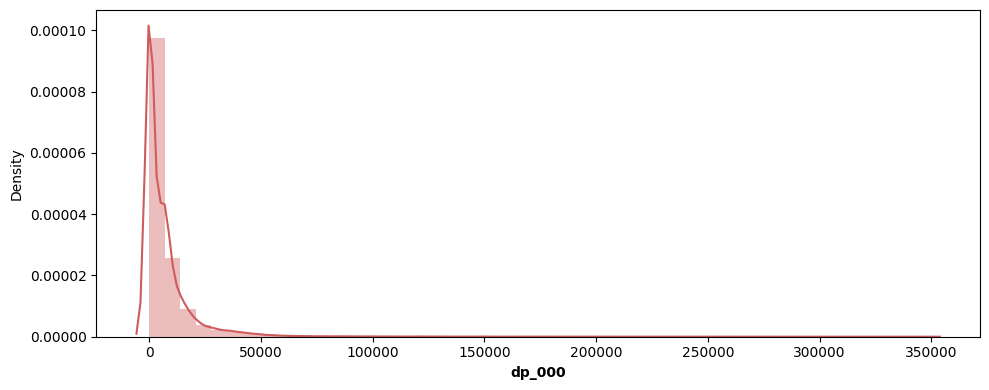

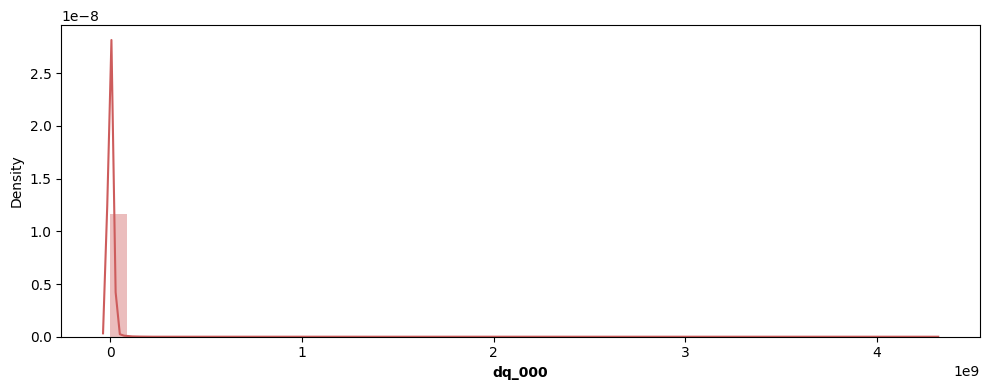

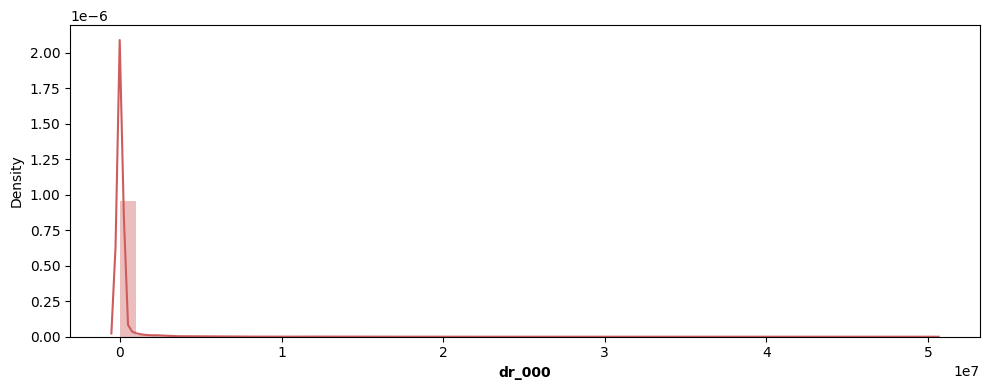

Plotting Batches:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 14/17 [01:24<00:17,  5.70s/batch]

Processing and plotting batch 15/17


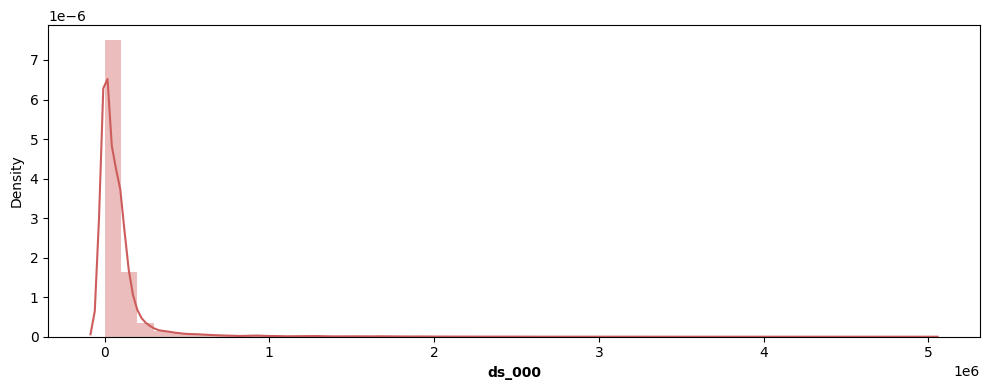

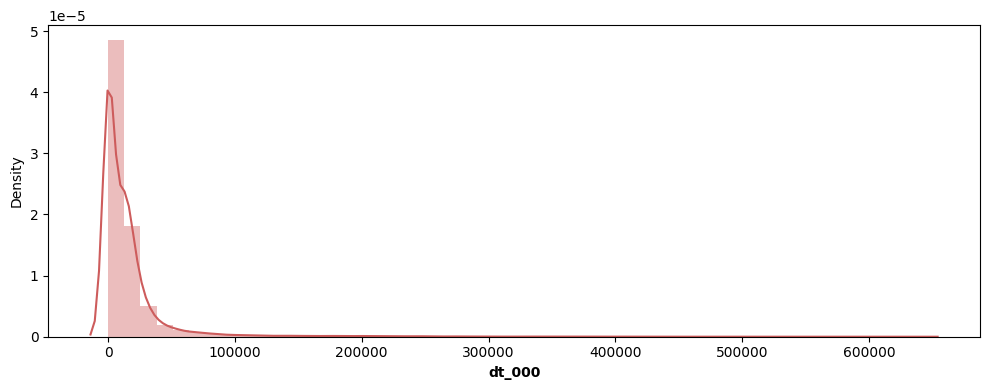

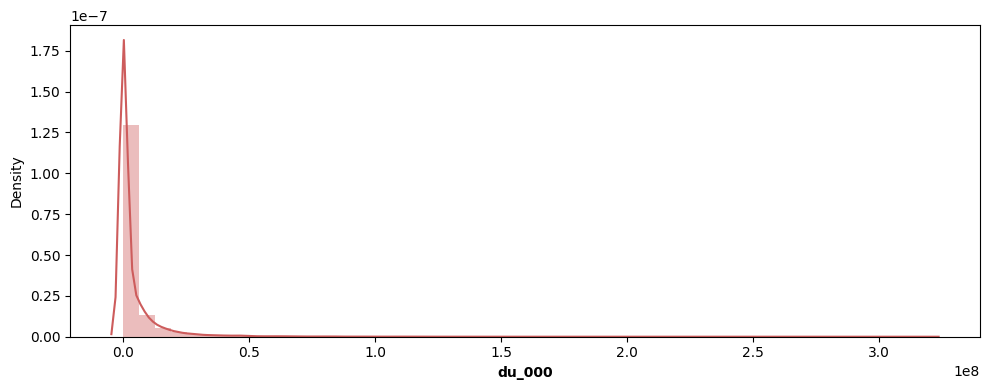

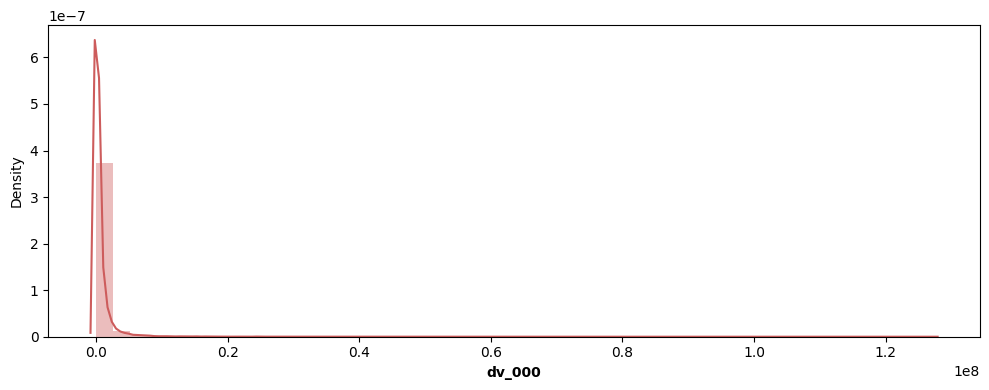

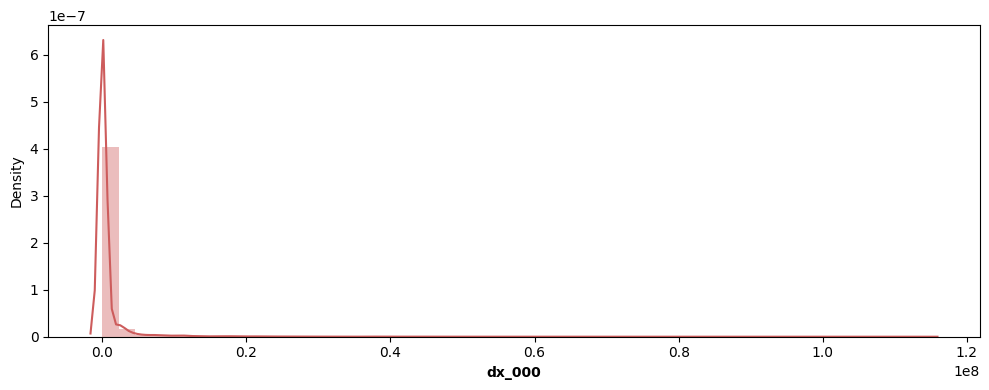

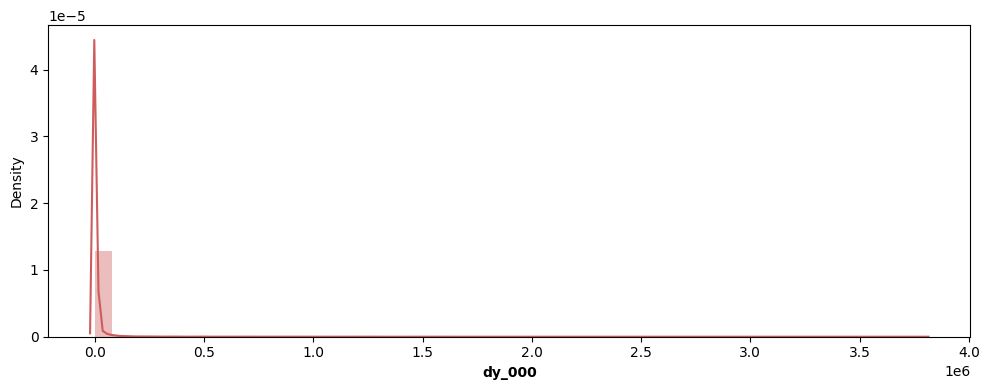

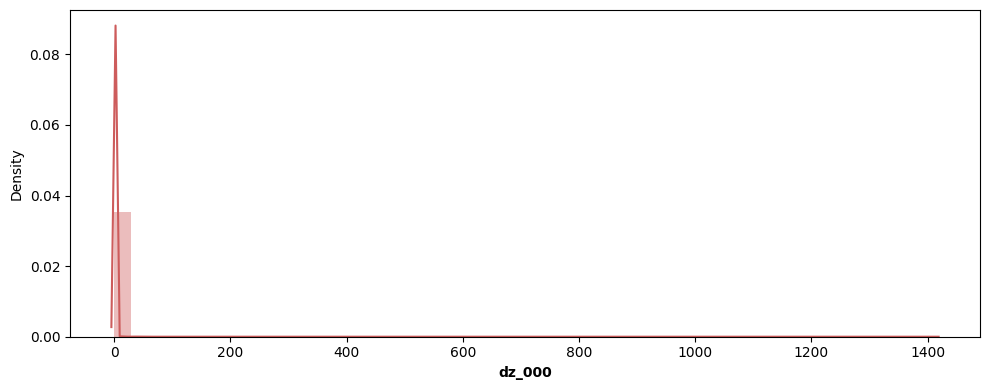

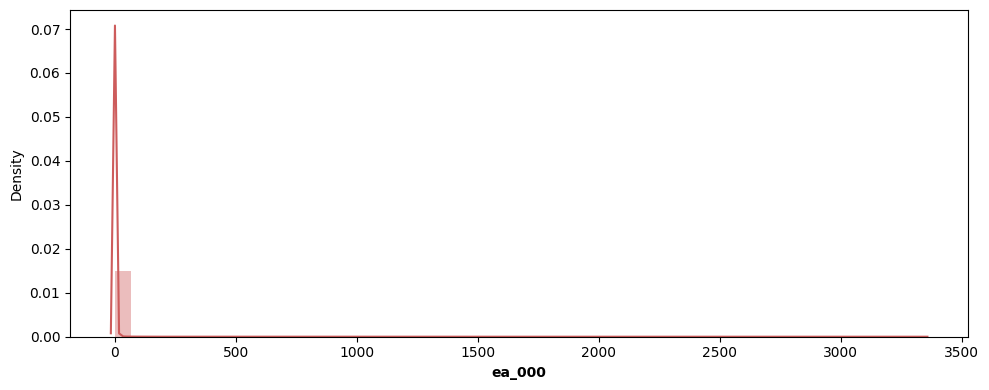

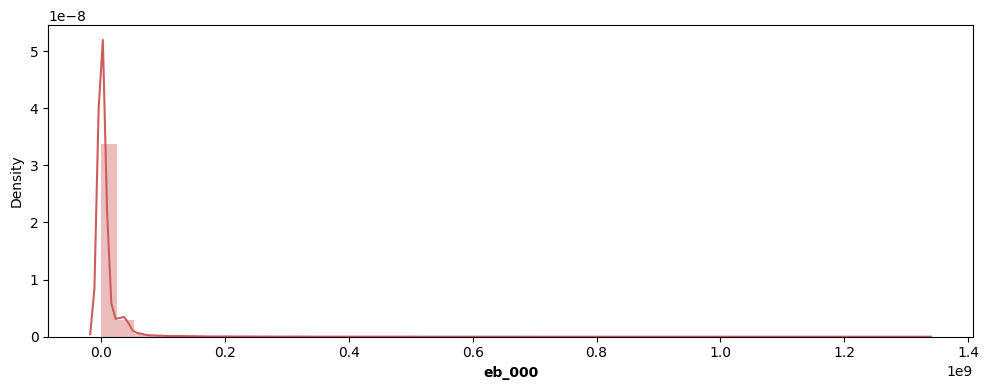

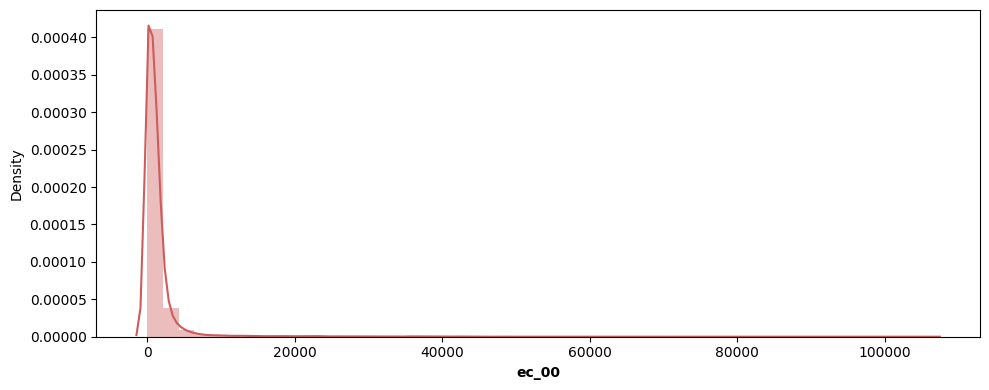

Plotting Batches:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 15/17 [01:30<00:11,  5.72s/batch]

Processing and plotting batch 16/17


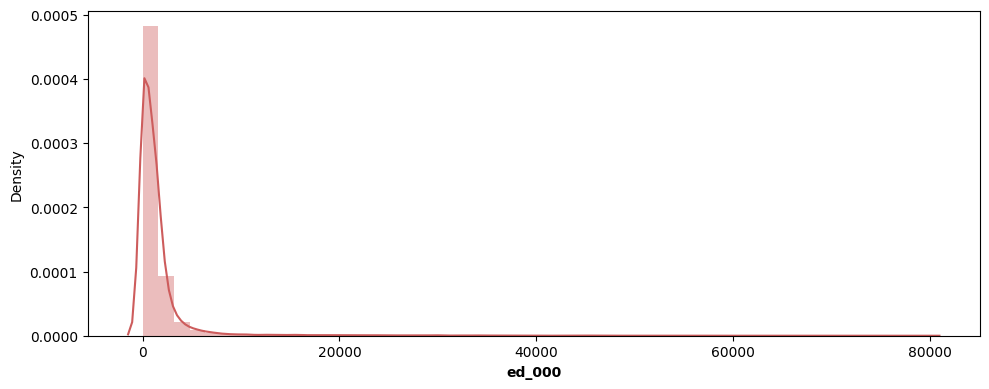

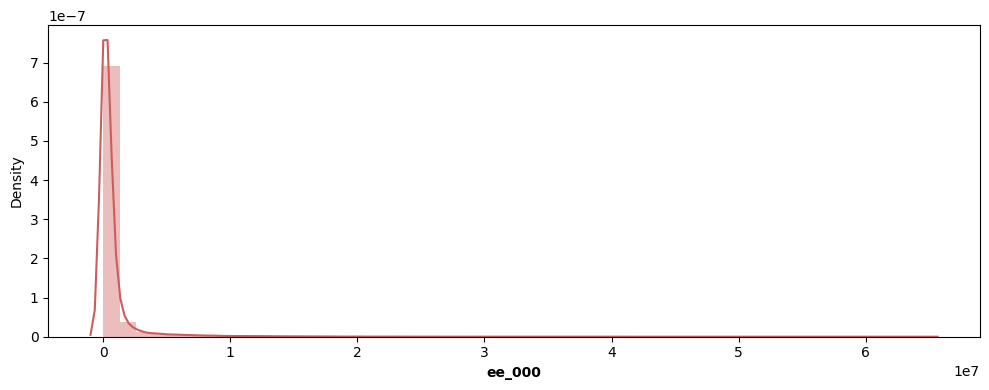

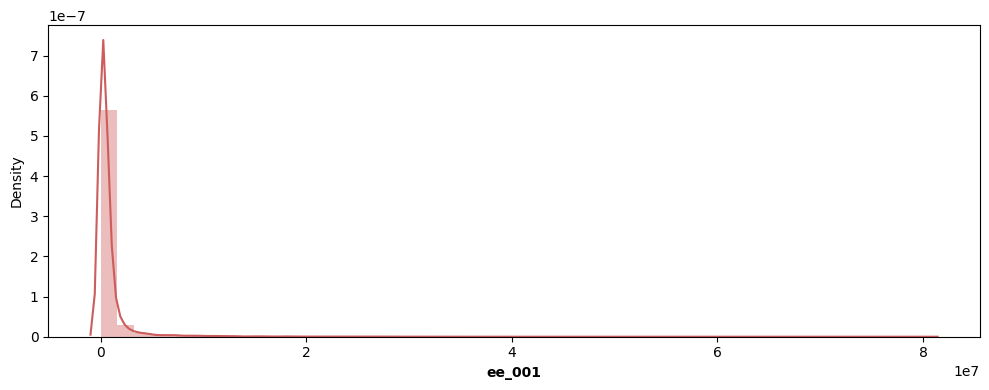

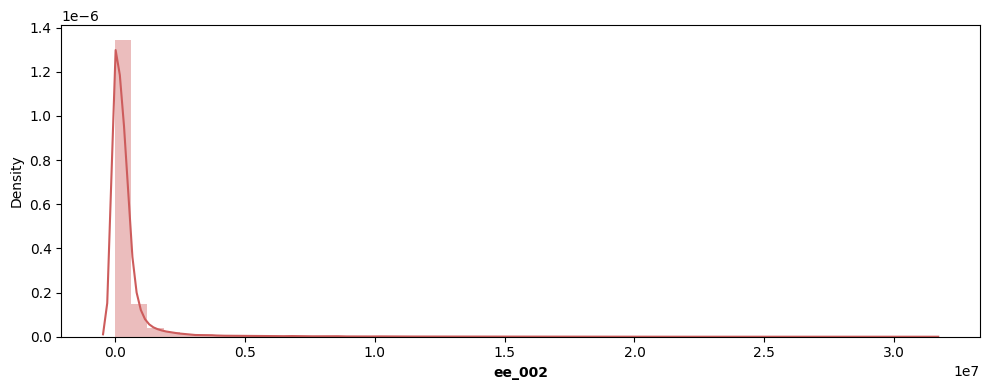

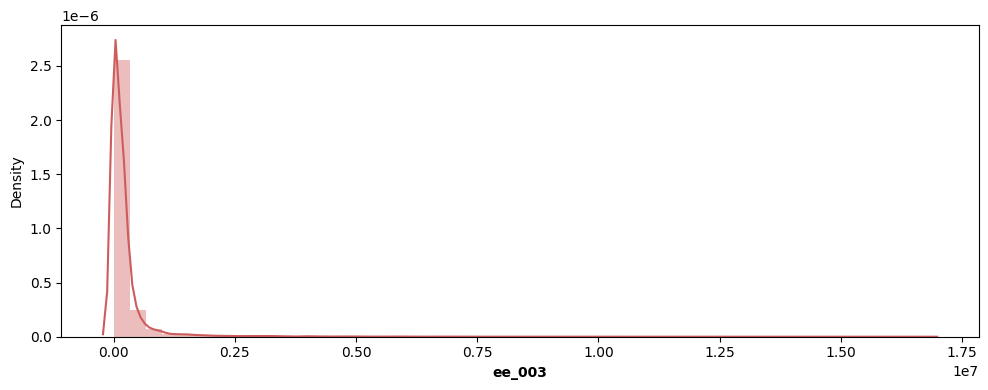

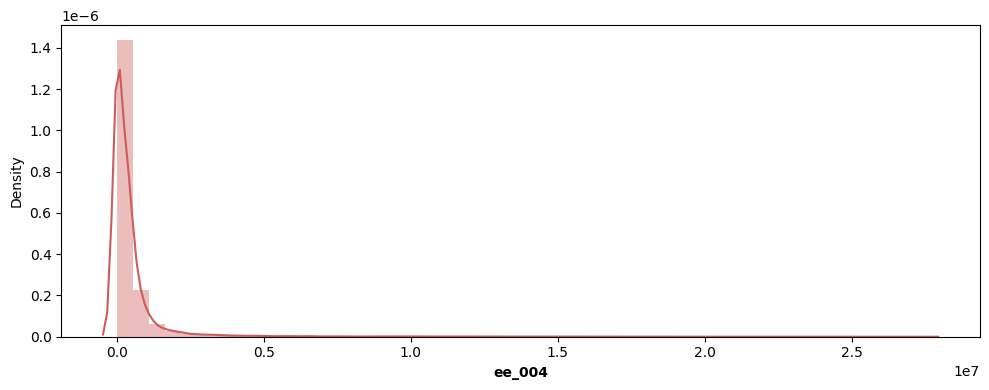

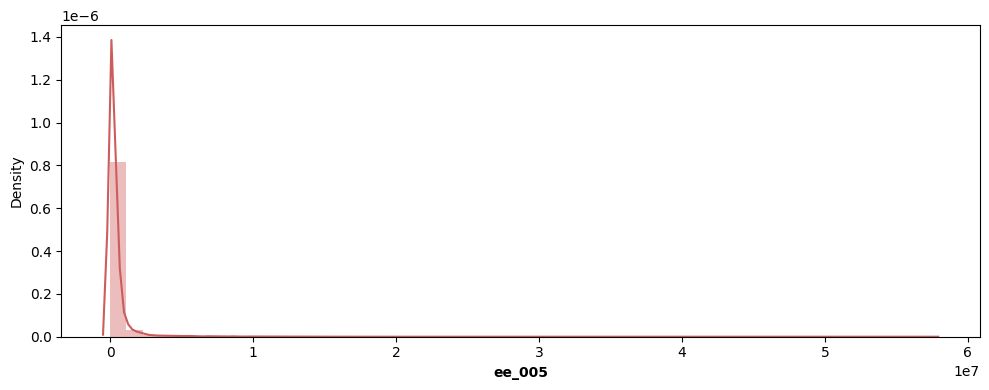

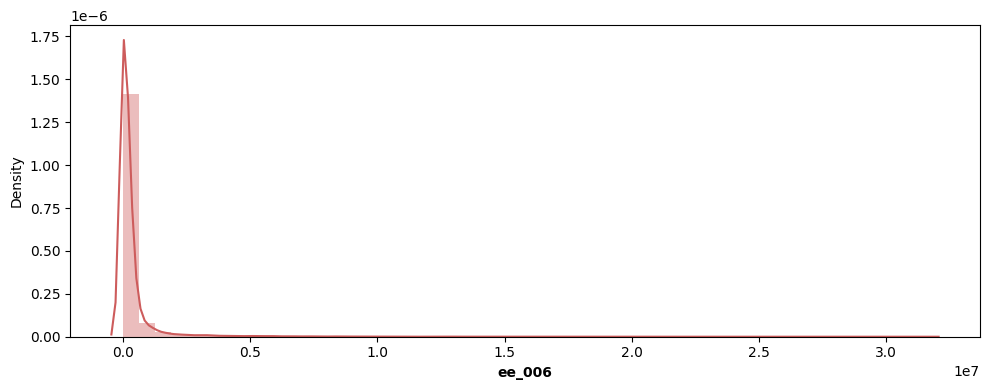

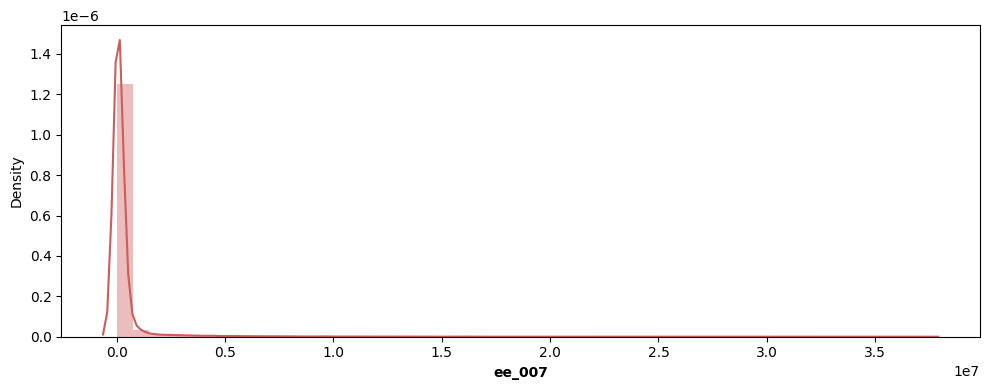

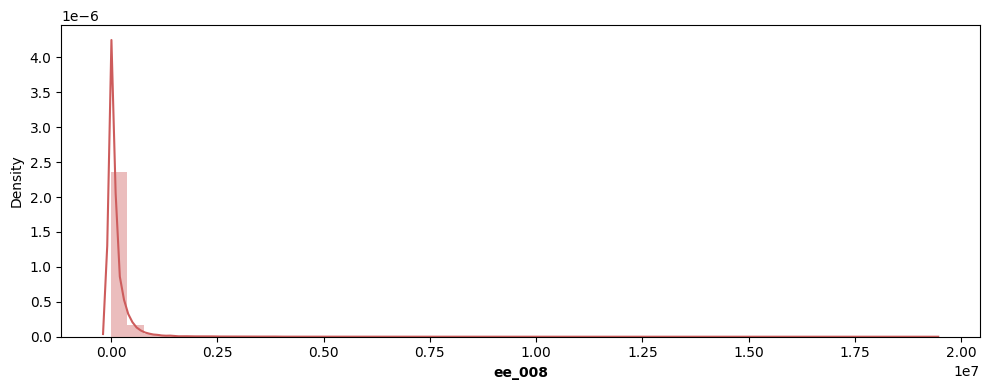

Plotting Batches:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 16/17 [01:36<00:05,  5.81s/batch]

Processing and plotting batch 17/17


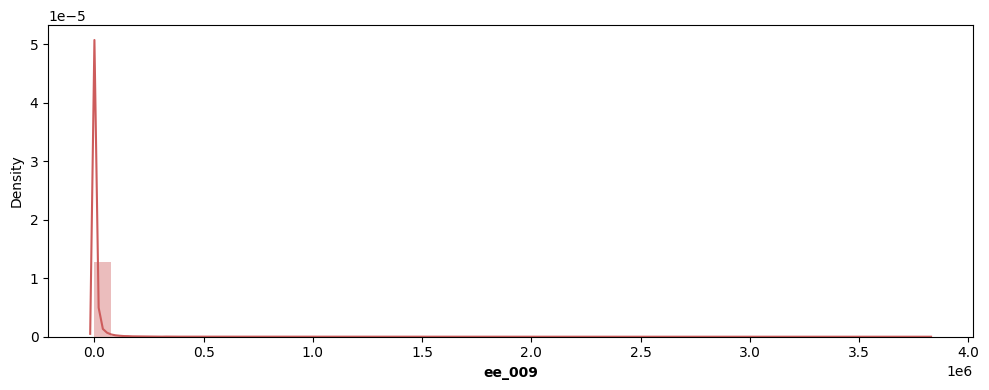

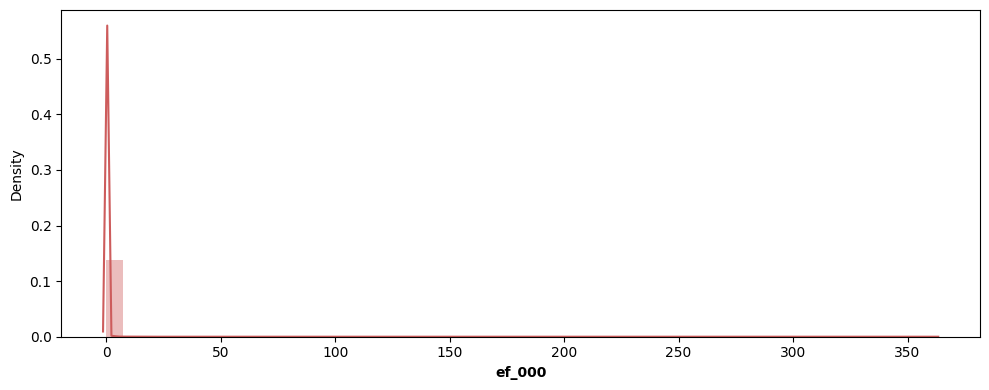

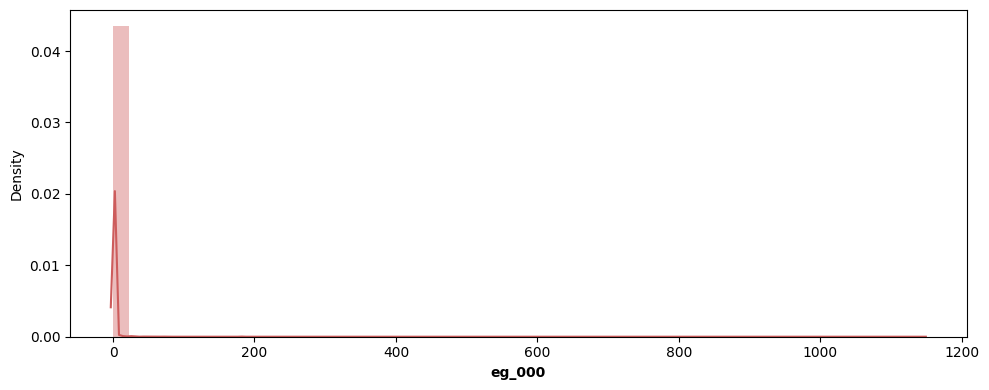

Plotting Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:37<00:00,  5.76s/batch]


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

# Use the inline backend to display plots directly in the notebook
%matplotlib inline

# List of numerical features
numerical_features = [feature for feature in df.columns if df[feature].dtype != "O"]

# Initialize 17 lists to store the features
f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, f15, f16, f17 = ([] for _ in range(17))

# List of lists to hold the 17 feature lists
feature_lists = [f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, f15, f16, f17]

# Distribute features across the 17 lists
batch_size = 10
for i in range(len(feature_lists)):
    start_index = i * batch_size
    end_index = start_index + batch_size
    feature_lists[i].extend(numerical_features[start_index:end_index])

# Now, `feature_lists` contains 17 lists with up to 10 features each.

# Process each list one by one
for batch_num, feature_list in enumerate(tqdm(feature_lists, desc="Plotting Batches", unit="batch")):
    print(f"Processing and plotting batch {batch_num + 1}/{len(feature_lists)}")

    for col in feature_list:
        plt.figure(figsize=(10, 4))
        sns.distplot(df[col], color="indianred", kde=True)
        plt.xlabel(col, weight="bold")
        plt.tight_layout()
        plt.show()  # Display the plot inline

    # After processing, delete the list to free up memory
    del feature_list
    gc.collect()  # Explicit garbage collection to free memory


In [29]:
#splitting X and Y for all Experiments
X = df.drop("class",axis = 1)
Y = df["class"]

In [30]:
Y = Y.replace({"pos":1,"neg":0})

# Evaluate Modl on DIfferent experiments

In [31]:
#Exp1 = Knn

In [32]:
print("pra")

pra


In [54]:
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)


In [55]:
#finding optimal n_neighbour value for knn imputer

In [56]:
results=[]
# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, X1, Y, scoring='accuracy', cv=2, n_jobs=-1)
    results.append(scores)
    print('n_neighbors= %s || accuracy (%.4f)' % (s , mean(scores)))

n_neighbors= 1 || accuracy (0.7501)
n_neighbors= 3 || accuracy (0.7146)
n_neighbors= 5 || accuracy (0.7187)
n_neighbors= 7 || accuracy (0.7118)
n_neighbors= 9 || accuracy (0.7212)


In [ ]:
#we observe n_neighbor = 3 able to produce good accuracy

#Pipeline for KNN imputer

In [35]:
num_features = X.select_dtypes(exclude = "object").columns

#fit the knn imputer with selected k-value
knn_pipeline = Pipeline(steps=[
    ("imputer",KNNImputer(n_neighbors=1)),
    ("RobustScaler",RobustScaler())
    ])

In [36]:
X_knn = knn_pipeline.fit_transform(X)

In [25]:
#handling imbalanced data

In [26]:
!pip install imblearn

You should consider upgrading via the 'C:\prabhakar\projects\live-sensor-fault-detection\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [37]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=13,sampling_strategy="minority",n_jobs=-1)

X_res,Y_res = smt.fit_resample(X_knn,Y)

Initialize Deafault Models in a Dictonary

In [43]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree":DecisionTreeClassifier(),
    "Gradient Boosting":GradientBoostingClassifier(),
    "Logistic Regression":LogisticRegression(),
    "K-Neighbors Classifier":KNeighborsClassifier(),
    "XGBCLassifier":XGBClassifier(),
    "CatBoosting Classifier":CatBoostClassifier(verbose=False),
    "AdaBoost Classifier":AdaBoostClassifier()
}

In [29]:
#fit knn imputerd data for models in dictonary

In [30]:
report_knn = evaluate_models(X_res,Y_res,models)


Random Forest
Model performance for Training set
--Accuracy: 1.0000
--F1 score: 1.0000
--Precision: 1.0000
--Recall: 1.0000
--ROC AUC score: 1.0000
---Cost: 0
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9931
--F1 score: 0.9931
--Precision: 0.9904
--Recall: 0.9959
--ROC AUC score: 0.9931
---Cost: 15180


Decision Tree
Model performance for Training set
--Accuracy: 1.0000
--F1 score: 1.0000
--Precision: 1.0000
--Recall: 1.0000
--ROC AUC score: 1.0000
---Cost: 0
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9869
--F1 score: 0.9870
--Precision: 0.9825
--Recall: 0.9915
--ROC AUC score: 0.9869
---Cost: 31240


Gradient Boosting
Model performance for Training set
--Accuracy: 0.9844
--F1 score: 0.9844
--Precision: 0.9816
--Recall: 0.9873
--ROC AUC score: 0.9844
---Cost: 182700
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9825
--F1 

In [31]:
report_knn

,Model Name,Cost
5,XGBCLassifier,4880
6,CatBoosting Classifier,5510
0,Random Forest,15180
1,Decision Tree,31240
4,K-Neighbors Classifier,56090
2,Gradient Boosting,56350
7,AdaBoost Classifier,81630
3,Logistic Regression,315810


In [32]:
#Experiment 2 = Simple Imputer with Strategy Median


In [33]:
num_features = X.select_dtypes(exclude ="object").columns

median_pipeline = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("RobustScaler",RobustScaler())
])


In [34]:
X_median = median_pipeline.fit_transform(X)

In [35]:
#Resampling minority class
smt = SMOTETomek(random_state = 12,sampling_strategy = "minority")
X_res ,Y_res = smt.fit_resample(X_median,Y)

In [36]:
report_median = evaluate_models(X_res,Y_res,models)

Random Forest
Model performance for Training set
--Accuracy: 1.0000
--F1 score: 1.0000
--Precision: 1.0000
--Recall: 1.0000
--ROC AUC score: 1.0000
---Cost: 0
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9924
--F1 score: 0.9925
--Precision: 0.9874
--Recall: 0.9976
--ROC AUC score: 0.9925
---Cost: 9390


Decision Tree
Model performance for Training set
--Accuracy: 1.0000
--F1 score: 1.0000
--Precision: 1.0000
--Recall: 1.0000
--ROC AUC score: 1.0000
---Cost: 0
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9852
--F1 score: 0.9852
--Precision: 0.9814
--Recall: 0.9890
--ROC AUC score: 0.9852
---Cost: 39810


Gradient Boosting
Model performance for Training set
--Accuracy: 0.9836
--F1 score: 0.9836
--Precision: 0.9815
--Recall: 0.9858
--ROC AUC score: 0.9836
---Cost: 204720
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9802
--F1 s

In [37]:
report_median

,Model Name,Cost
5,XGBCLassifier,3540
6,CatBoosting Classifier,8690
0,Random Forest,9390
1,Decision Tree,39810
2,Gradient Boosting,53250
4,K-Neighbors Classifier,53710
7,AdaBoost Classifier,81510
3,Logistic Regression,308170


In [38]:
#Experiment 3 = Mice for Imputing Null values

In [39]:
!pip install miceforest


You should consider upgrading via the 'C:\prabhakar\projects\live-sensor-fault-detection\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [40]:
import miceforest as mf

X_mice = X.copy()
kernel = mf.ImputationKernel(
    X_mice,
    save_all_iterations = True,
    random_state = 12
)


In [41]:
X_mice = kernel.complete_data()


In [42]:
mice_pipeline = Pipeline(steps=[
    ("RobustScaler",RobustScaler())
])


In [43]:
X_mice = mice_pipeline.fit_transform(X_mice)

In [44]:
#resampling minortity class
smt = SMOTETomek(random_state=12,sampling_strategy="minority",n_jobs=-1)

X_res,Y_res =smt.fit_resample(X_mice,Y)

In [45]:
#training model
report_mice = evaluate_models(X_res,Y_res,models)

Random Forest
Model performance for Training set
--Accuracy: 1.0000
--F1 score: 1.0000
--Precision: 1.0000
--Recall: 1.0000
--ROC AUC score: 1.0000
---Cost: 0
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9915
--F1 score: 0.9915
--Precision: 0.9873
--Recall: 0.9959
--ROC AUC score: 0.9915
---Cost: 15400


Decision Tree
Model performance for Training set
--Accuracy: 1.0000
--F1 score: 1.0000
--Precision: 1.0000
--Recall: 1.0000
--ROC AUC score: 1.0000
---Cost: 0
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9824
--F1 score: 0.9825
--Precision: 0.9769
--Recall: 0.9882
--ROC AUC score: 0.9824
---Cost: 43140


Gradient Boosting
Model performance for Training set
--Accuracy: 0.9851
--F1 score: 0.9852
--Precision: 0.9819
--Recall: 0.9884
--ROC AUC score: 0.9851
---Cost: 167110
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9822
--F1 

In [46]:
report_mice

,Model Name,Cost
5,XGBCLassifier,4410
6,CatBoosting Classifier,8610
0,Random Forest,15400
1,Decision Tree,43140
2,Gradient Boosting,45120
4,K-Neighbors Classifier,55600
7,AdaBoost Classifier,76270
3,Logistic Regression,187380


In [47]:
#Experiment 4 = Simple Imputer with Strategy Constant

In [63]:
constant_pipeline = Pipeline(steps=[
    ("Imputer",SimpleImputer(strategy="constant",fill_value =0)),
    ("RobustScaler",RobustScaler())
])




In [64]:
X_const = constant_pipeline.fit_transform(X)

In [65]:
#resampling minortity class
smt = SMOTETomek(random_state=12,sampling_strategy="minority",n_jobs=-1)

X_res,Y_res =smt.fit_resample(X_const,Y)

In [66]:
report_const = evaluate_models(X_res,Y_res,models)

Random Forest
Model performance for Training set
--Accuracy: 1.0000
--F1 score: 1.0000
--Precision: 1.0000
--Recall: 1.0000
--ROC AUC score: 1.0000
---Cost: 0
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9916
--F1 score: 0.9917
--Precision: 0.9859
--Recall: 0.9974
--ROC AUC score: 0.9916
---Cost: 10000


Decision Tree
Model performance for Training set
--Accuracy: 1.0000
--F1 score: 1.0000
--Precision: 1.0000
--Recall: 1.0000
--ROC AUC score: 1.0000
---Cost: 0
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9862
--F1 score: 0.9863
--Precision: 0.9826
--Recall: 0.9900
--ROC AUC score: 0.9862
---Cost: 36230


Gradient Boosting
Model performance for Training set
--Accuracy: 0.9835
--F1 score: 0.9836
--Precision: 0.9805
--Recall: 0.9867
--ROC AUC score: 0.9835
---Cost: 192010
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9804
--F1 

In [67]:
report_const

,Model Name,Cost
5,XGBCLassifier,6020
6,CatBoosting Classifier,8690
0,Random Forest,10000
1,Decision Tree,36230
4,K-Neighbors Classifier,51760
2,Gradient Boosting,54200
7,AdaBoost Classifier,87550
3,Logistic Regression,98320


In [68]:
#Experiment 5 = Simple Imputer with Strategy Mean


In [48]:
mean_pipeline = Pipeline(steps=[
    ("Imputer",SimpleImputer(strategy="mean")),
    ("RobustScaler",RobustScaler())
])


In [49]:
X_mean = mean_pipeline.fit_transform(X)

In [50]:
#resampling minortity class
smt = SMOTETomek(random_state=12,sampling_strategy="minority",n_jobs=-1)

X_res,Y_res =smt.fit_resample(X_mean,Y)

In [51]:
report_mean = evaluate_models(X_res,Y_res,models)

Random Forest
Model performance for Training set
--Accuracy: 1.0000
--F1 score: 1.0000
--Precision: 1.0000
--Recall: 1.0000
--ROC AUC score: 1.0000
---Cost: 0
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9934
--F1 score: 0.9934
--Precision: 0.9884
--Recall: 0.9984
--ROC AUC score: 0.9934
---Cost: 6320


Decision Tree
Model performance for Training set
--Accuracy: 1.0000
--F1 score: 1.0000
--Precision: 1.0000
--Recall: 1.0000
--ROC AUC score: 1.0000
---Cost: 0
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9878
--F1 score: 0.9879
--Precision: 0.9828
--Recall: 0.9930
--ROC AUC score: 0.9878
---Cost: 25720


Gradient Boosting
Model performance for Training set
--Accuracy: 0.9855
--F1 score: 0.9855
--Precision: 0.9829
--Recall: 0.9881
--ROC AUC score: 0.9855
---Cost: 171820
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9827
--F1 s

In [73]:
report_mean

,Model Name,Cost
5,XGBCLassifier,2020
6,CatBoosting Classifier,6580
0,Random Forest,7300
1,Decision Tree,25790
4,K-Neighbors Classifier,36040
2,Gradient Boosting,51910
7,AdaBoost Classifier,88890
3,Logistic Regression,311460


**Experiment 6**  PCA with Imputing mean

In [ ]:
from sklearn.decomposition import PCA

In [21]:
pca_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])



X_pca = pca_pipeline.fit_transform(X)


#Applying PCA
from sklearn.decomposition import PCA
var_ratio={}
for n in range(2,150):
    pc=PCA(n_components=n)
    df_pca=pc.fit(X_pca)
    var_ratio[n]=sum(df_pca.explained_variance_ratio_)

<Axes: >

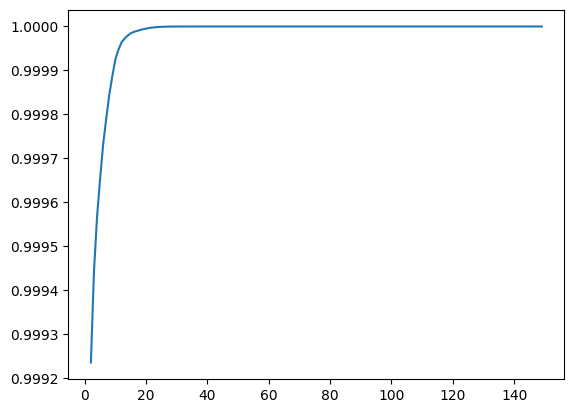

In [22]:
# plotting variance ratio
pd.Series(var_ratio).plot()

<Figure size 500x500 with 0 Axes>

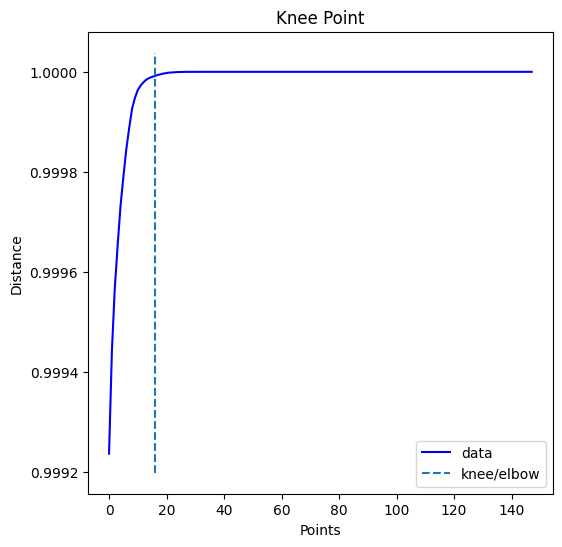

Knee Locator k = 18


In [25]:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio= list(var_ratio.values())
components=  list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= components[knee.knee]
print('Knee Locator k =', k)



In [40]:
# Reducing the dimensions of the data 
pca_final=PCA(n_components=18,random_state=42).fit(X_res)

reduced=pca_final.fit_transform(X_pca)

In [44]:
# Training all models
report_pca = evaluate_models(X_res,Y_res, models)

Random Forest
Model performance for Training set
--Accuracy: 1.0000
--F1 score: 1.0000
--Precision: 1.0000
--Recall: 1.0000
--ROC AUC score: 1.0000
---Cost: 0
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9928
--F1 score: 0.9928
--Precision: 0.9898
--Recall: 0.9959
--ROC AUC score: 0.9928
---Cost: 15220


Decision Tree
Model performance for Training set
--Accuracy: 1.0000
--F1 score: 1.0000
--Precision: 1.0000
--Recall: 1.0000
--ROC AUC score: 1.0000
---Cost: 0
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9866
--F1 score: 0.9867
--Precision: 0.9826
--Recall: 0.9908
--ROC AUC score: 0.9866
---Cost: 33730


Gradient Boosting
Model performance for Training set
--Accuracy: 0.9844
--F1 score: 0.9844
--Precision: 0.9816
--Recall: 0.9873
--ROC AUC score: 0.9844
---Cost: 182700
---------------------------------------------------
Model performance for Testing set
--Accuracy: 0.9825
--F1 

### Report for PCA and Mean imputed data

In [45]:
report_pca

,Model Name,Cost
5,XGBCLassifier,4880
6,CatBoosting Classifier,5510
0,Random Forest,15220
1,Decision Tree,33730
4,K-Neighbors Classifier,56090
2,Gradient Boosting,56350
7,AdaBoost Classifier,81630
3,Logistic Regression,315810


###FInal Model

In [46]:
from prettytable import PrettyTable

pt=PrettyTable()
pt.field_names=["Model","Imputation_method","Total_cost"]
pt.add_row(["XGBClassifier","Simple Imputer-Constant","2950"])
pt.add_row(["XGBClassifier","Mice","3510"])
pt.add_row(["XGBClassifier","Knn-Imputer","4460"])
pt.add_row(["XGBClassifier","Simple Imputer-Mean","4950"])
pt.add_row(["CatBoostClassifier","Median","5760"])
pt.add_row(["Random Forest","PCA","34150"])
print(pt)

ModuleNotFoundError: No module named 'prettytable'

In [54]:
final_model = XGBClassifier()

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mean, Y)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

final_model = final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [56]:
print("Final XGBoost Classifier Accuracy Score (Train) :", final_model.score(X_train,y_train))
print("Final XGBoost Classifier Accuracy Score (Test) :", accuracy_score(y_pred,y_test))

Final XGBoost Classifier Accuracy Score (Train) : 0.9999821810406272
Final XGBoost Classifier Accuracy Score (Test) : 0.9967213114754099


In [57]:
print("Final XGBoost Classifier Cost Metric(Test) :",total_cost(y_test, y_pred))

Final XGBoost Classifier Cost Metric(Test) : 1930


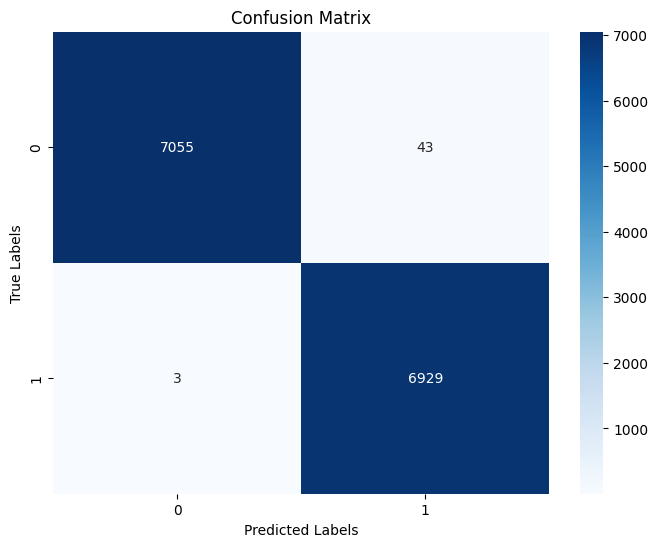

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming final_model is your trained model, and X_test, y_test are your test data and labels

# Predict the labels for the test set
y_pred = final_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()
